# Purpose of this notebook = leverage knowledge about neighbors' formation thicknesses

## What a geologist would do: 
#### Look at neighboring wells to find thickness of unit from a top and base pick, in prediction well flatten on base pick, and see where neighboring top pick lands on well in question. Further evaluation starts there. 
## Feature creation summary:
#### Find thickness of unit in neighboring wells in training dataset. Subtract that thickness from the base pick depth in the well we're going to predict for to find where that top pick would be in the prediction well if the thickness is the same.


## Feature Creation Additional Details:
- We could get quite elaborate with this in terms of whether neighbors are on all sides of prediction well or just one side or which neighbors are most similar in terms of total depth drilled, variances in gamma-ray, etc. 
- For now, we're going going to create two features (1) a prediction feature based on nearest neighbor thickness (2) a prediction feature based on average of nearest 5 neighbors. 
- Neighbor thickness helper features columns will be floats representing the distance from the depth predicted from neighbor thickness and prediction well base pick.
- We will also have column to keep track of the range between the smallest and largest neighbor thickness of that well. 
- This feature creation requires the things below, if they aren't present this shouldn't be used:
    - We have lat/long to determine neighbors.
    - We have a base pick and a top pick for each well.
    - We have reason to believe the thickness of neighbors is a good indicator or where the top will be in this well. Reasons that wouldn't be the case include: presence of faults, known local outliers, and possibly other things I haven't thought of yet. 

In [13]:
# Notebook to find: 
## 1. Check that we have created a subset of wells to use that have both tops and bases for a given unit.
## 2. A number of nearest neighbors of each well
## 3. Thickness of one or more zones for each nearest neighbor in set of n nearest neighbors
## 4. Where in the well a top would be predicted just based on base of unit and thickness of neighbors
### 4. b. Thickness of closest neighbor with both a top and a base
### 4.c Average thickness of nearest N neighbors
### 5. NOTE: We'll want to only use neighbors from the train data samples for the train rows and use both train and test neighbors for test rows. For this, we'll want to already have test and train classes assigned!

### Earlier notebooks were to explore lat/long position of wells & find nearest neighbors and functions to make a dataset of nearest neighbors within certain limits for each well and potentially functions to make a dataset of tops and other characteristics for neighboring wells.
### 

## Import modules and set display options

In [14]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import welly
from welly import Well
import lasio
import glob
from sklearn import neighbors
import pickle
import os
import folium
print("folium",folium.__version__)
import branca.colormap as cm
import os
import math
print("welly",welly.__version__)
import re

folium 0.5.0
welly 0.3.5


In [15]:
%%timeit
import os
env = %env

86.3 µs ± 1.61 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [16]:
pd.set_option('display.max_rows', 2000)

## Load pick, pick dictionary, well information, and well location via csv and text file


In [17]:
picks_dic = pd.read_csv('../../../SPE_006_originalData/OilSandsDB/PICKS_DIC.TXT',delimiter='\t')
picks = pd.read_csv('../../../SPE_006_originalData/OilSandsDB/PICKS.TXT',delimiter='\t')
wells = pd.read_csv('../../../SPE_006_originalData/OilSandsDB/WELLS.TXT',delimiter='\t')
gis = pd.read_csv('../../../well_lat_lng.csv')

## Dataframe of well curves data created in load notebook

In [18]:
loaded_wells_dir = '../loadLAS/'
loaded_wells_splitTrainTest_dir = '../splitTrainTest/'
# loaded_wells_df = 'df_all_wells_noKNNorFeatures_20180920_a.h5'
# h5_filename_df_wells_wTrainTestSplitCol = 'df_all_wells_noKNNorFeatures_wTrainSplit_20180927_c.h5'

loaded_wells_splitTrainTest_df = 'df_all_wells_noKNNorFeatures_wTrainSplit_20180927_c.h5'

## h5 file to write to at end:

In [19]:
h5_name_wells_curves_picks_knn_nofeature = 'wells_curves_picks_knn_nofeatures_20190928_a.h5'

## Give top pick code that we want to predict
## and give base pick code that we want to assume we have 

In [20]:
####old verbage
# picks_new=picks[picks['HorID']==13000]
# picks_paleoz=picks[picks['HorID']==14000]

#### top pick code we are going to predict
picks_targetTop=picks[picks['HorID']==13000]
#### base pick code we are going to assume we have
picks_targetBase=picks[picks['HorID']==14000]

#### Note: these need to be in this order as we'll assume the second one will be written as 'HorID_x' by pandas as two columns can't have the same name

## Merge information from the various files into a pandas dataframe

In [21]:


df_new = pd.merge(wells, picks_targetTop, on='SitID')
df_paleoz = pd.merge(wells, picks_targetBase, on='SitID')
df_gis = pd.merge(df_paleoz, gis, on='SitID')
df_new=pd.merge(df_gis, df_new, on='SitID')
df_new.head()

SitID    UWI (AGS)_x                UWI_x  HorID_x Pick_x  Quality_x  \
0  102496  0674010812000  00/12-08-067-01W4/0    14000    561          1   
1  102497  0674020807000  00/07-08-067-02W4/0    14000  604.5          1   
2  102498  0674021109000  00/09-11-067-02W4/0    14000    564          1   
3  102500  0674022910000  00/10-29-067-02W4/0    14000  636.5          1   
4  102501  0674023406000  00/06-34-067-02W4/0    14000    613          1   

     UWI (AGS)_y                UWI_y  HorID_y Pick_y  Quality_y        lat  \
0  0674010812000  00/12-08-067-01W4/0    13000    475          3  54.785907   
1  0674020807000  00/07-08-067-02W4/0    13000    515          3  54.782284   
2  0674021109000  00/09-11-067-02W4/0    13000    480          3  54.785892   
3  0674022910000  00/10-29-067-02W4/0    13000    549          3  54.829624   
4  0674023406000  00/06-34-067-02W4/0    13000    529          2  54.840471   

          lng      UWI (AGS)                  UWI  HorID Pick  Quality  
0 -110.129320  0674010812000  00/12-08-067-01W4/0  13000  475        3  
1 -110.269446  0674020807000  00/07-08-067-02W4/0  13000  515        3  
2 -110.186851  0674021109000  00/09-11-067-02W4/0  13000  480        3  
3 -110.269422  0674022910000  00/10-29-067-02W4/0  13000  549        3  
4 -110.224832  0674023406000  00/06-34-067-02W4/0  13000  529        2

In [22]:
df_new.tail()

SitID    UWI (AGS)_x                UWI_x  HorID_x  Pick_x  Quality_x  \
2188  126239  1014133011AA0  AA/11-30-101-13W4/0    14000     497          1   
2189  126240  1014140811AA0  AA/11-08-101-14W4/0    14000     505          2   
2190  126241  1014141414AA0  AA/14-14-101-14W4/0    14000  502.31          1   
2191  126243  1014142906AA0  AA/06-29-101-14W4/0    14000     538          1   
2192  126244  1014143506AA0  AA/06-35-101-14W4/0    14000     584          1   

        UWI (AGS)_y                UWI_y  HorID_y  Pick_y  Quality_y  \
2188  1014133011AA0  AA/11-30-101-13W4/0    13000     457          3   
2189  1014140811AA0  AA/11-08-101-14W4/0    13000     481          2   
2190  1014141414AA0  AA/14-14-101-14W4/0    13000  471.22          3   
2191  1014142906AA0  AA/06-29-101-14W4/0    13000     517          2   
2192  1014143506AA0  AA/06-35-101-14W4/0    13000   539.7          1   

            lat         lng      UWI (AGS)                  UWI  HorID  \
2188  57.796978 -112.129423  1014133011AA0  AA/11-30-101-13W4/0  13000   
2189  57.753273 -112.266195  1014140811AA0  AA/11-08-101-14W4/0  13000   
2190  57.771518 -112.184135  1014141414AA0  AA/14-14-101-14W4/0  13000   
2191  57.793366 -112.266201  1014142906AA0  AA/06-29-101-14W4/0  13000   
2192  57.807817 -112.184139  1014143506AA0  AA/06-35-101-14W4/0  13000   

        Pick  Quality  
2188     457        3  
2189     481        2  
2190  471.22        3  
2191     517        2  
2192   539.7        1

In [23]:
# ## Possible Steps to Chain for some of the possible features
# 0. Save and access pickle of all the CSVs chained into single data frame
# 1. Return array of UWIs of K neighbor wells, place as list in data frame
# 2. Place nearest well UWI of each well into new column 
# 3. Place nearest well pick depths into new column
# 4. place average pick depths of the array of wells into new column
# 5. do same thing for nearest well and nearest K wells but for average Gr, DPHI, and Resitivity value if present.
# 6. Calculate nearest and average value for distance between pick in question and known pick.

## Now let's import the dataframe of wells that have the tops and curves we want and limit the GIS dataframe to only those wells!

In [24]:
wellsLoaded_df_fromh5 = pd.read_hdf(loaded_wells_splitTrainTest_dir+loaded_wells_splitTrainTest_df, 'df')

In [25]:
wellsLoaded_df_fromh5.tail()

CALI  COND  DELT    DEPT   DPHI  DT      GR      ILD  ILM   NPHI  PHID  \
876   NaN   NaN   NaN  359.00  0.014 NaN  61.724   53.940  NaN  0.191   NaN   
877   NaN   NaN   NaN  359.25  0.014 NaN  59.927   63.882  NaN  0.167   NaN   
878   NaN   NaN   NaN  359.50  0.011 NaN  58.729   74.245  NaN  0.155   NaN   
879   NaN   NaN   NaN  359.75  0.007 NaN  57.529   93.046  NaN  0.148   NaN   
880   NaN   NaN   NaN  360.00  0.006 NaN  56.926  138.167  NaN  0.140   NaN   

     RHOB  SFL  SFLU  SN  SP                      UWI trainOrTest  
876   NaN  NaN   NaN NaN NaN  00-10-35-081-15W4-0.LAS       train  
877   NaN  NaN   NaN NaN NaN  00-10-35-081-15W4-0.LAS       train  
878   NaN  NaN   NaN NaN NaN  00-10-35-081-15W4-0.LAS       train  
879   NaN  NaN   NaN NaN NaN  00-10-35-081-15W4-0.LAS       train  
880   NaN  NaN   NaN NaN NaN  00-10-35-081-15W4-0.LAS       train

## Let's limit the GIS and pick information dataframe to only the wells we're going to use and exclude any we're not going to use for not having the needed tops and curves.

We'll have to change the format of the UWU col slightly to do this

In [26]:
wellsLoaded_list = wellsLoaded_df_fromh5[['UWI']]['UWI'].unique()

In [27]:
len(wellsLoaded_list)

1601

In [28]:
wellsLoaded_list[9:14]

array(['00-11-21-077-07W4-0.LAS', '00-07-26-074-05W4-0.LAS',
       '00-12-19-075-09W4-0.LAS', '00-05-29-078-19W4-0.LAS',
       'AA-11-33-094-06W4-0.LAS'], dtype=object)

In [29]:
def replacenthSubStr(string, sub, wanted, n):
    where = [m.start() for m in re.finditer(sub, string)][n-1]
    before = string[:where]
    after = string[where:]
    after = after.replace(sub, wanted, 1)
    newString = before + after
    return newString

In [30]:
def changeLASfileToBeUWIstr(lasStr):
    string1 = replacenthSubStr(lasStr,'-', '/', 5)
    string2 = replacenthSubStr(string1,'-', '/', 1).replace(".LAS","")
    return string2

In [31]:
def findListOfConvertedUWInamesForWellsLoaded(wellsLoaded_df_fromh5):
    wellsLoaded_list = wellsLoaded_df_fromh5[['UWI']]['UWI'].unique()
    new_wells_loaded_list_inUWIstyle = []
    for lasStr in wellsLoaded_list:
        new_wells_loaded_list_inUWIstyle.append(changeLASfileToBeUWIstr(lasStr))
    return new_wells_loaded_list_inUWIstyle

In [32]:
new_wells_loaded_list_inUWIstyle = findListOfConvertedUWInamesForWellsLoaded(wellsLoaded_df_fromh5)

In [33]:
new_wells_loaded_list_inUWIstyle[5:8]

['00/11-11-080-19W4/0', '00/06-25-082-09W4/0', '00/06-31-067-15W4/0']

In [34]:
print(type(new_wells_loaded_list_inUWIstyle))

<class 'list'>


In [35]:
print(type(df_new))

<class 'pandas.core.frame.DataFrame'>


In [36]:
df_new.head()

SitID    UWI (AGS)_x                UWI_x  HorID_x Pick_x  Quality_x  \
0  102496  0674010812000  00/12-08-067-01W4/0    14000    561          1   
1  102497  0674020807000  00/07-08-067-02W4/0    14000  604.5          1   
2  102498  0674021109000  00/09-11-067-02W4/0    14000    564          1   
3  102500  0674022910000  00/10-29-067-02W4/0    14000  636.5          1   
4  102501  0674023406000  00/06-34-067-02W4/0    14000    613          1   

     UWI (AGS)_y                UWI_y  HorID_y Pick_y  Quality_y        lat  \
0  0674010812000  00/12-08-067-01W4/0    13000    475          3  54.785907   
1  0674020807000  00/07-08-067-02W4/0    13000    515          3  54.782284   
2  0674021109000  00/09-11-067-02W4/0    13000    480          3  54.785892   
3  0674022910000  00/10-29-067-02W4/0    13000    549          3  54.829624   
4  0674023406000  00/06-34-067-02W4/0    13000    529          2  54.840471   

          lng      UWI (AGS)                  UWI  HorID Pick  Quality  
0 -110.129320  0674010812000  00/12-08-067-01W4/0  13000  475        3  
1 -110.269446  0674020807000  00/07-08-067-02W4/0  13000  515        3  
2 -110.186851  0674021109000  00/09-11-067-02W4/0  13000  480        3  
3 -110.269422  0674022910000  00/10-29-067-02W4/0  13000  549        3  
4 -110.224832  0674023406000  00/06-34-067-02W4/0  13000  529        2

In [37]:
df_new_allWells = df_new.copy()
len(df_new_allWells)

2193

### This next step will reduce the total number of wells to just the ones that have at least the tops and curves we need

In [38]:
df_new = df_new[df_new['UWI'].isin(new_wells_loaded_list_inUWIstyle)]

Now that we've reduced the wells, we'll reset the index. We'll do this because another step below will use a loop that gets confused if there are index values missing. 

In [39]:
df_new = df_new.reset_index(drop=True)

In [40]:
df_new

SitID    UWI (AGS)_x                UWI_x  HorID_x  Pick_x  Quality_x  \
0     102496  0674010812000  00/12-08-067-01W4/0    14000     561          1   
1     102497  0674020807000  00/07-08-067-02W4/0    14000   604.5          1   
2     102498  0674021109000  00/09-11-067-02W4/0    14000     564          1   
3     102500  0674022910000  00/10-29-067-02W4/0    14000   636.5          1   
4     102501  0674023406000  00/06-34-067-02W4/0    14000     613          1   
5     102503  0674030411000  00/11-04-067-03W4/0    14000   553.5          1   
6     102505  0674030810000  00/10-08-067-03W4/0    14000   572.5          1   
7     102507  0674031410000  00/10-14-067-03W4/0    14000   606.5          1   
8     102514  0674032810000  00/10-28-067-03W4/0    14000     558          1   
9     102517  0674033607000  00/07-36-067-03W4/0    14000     615          1   
10    102518  0674040210000  00/10-02-067-04W4/0    14000   588.5          1   
11    102565  0674040710000  00/10-07-067-04W4/0    14000   568.5          1   
12    102577  0674042411000  00/11-24-067-04W4/0    14000     552          1   
13    102581  0674043307000  00/07-33-067-04W4/0    14000     570          1   
14    102583  0674050313000  00/13-03-067-05W4/0    14000   543.5          1   
15    102589  0674051606000  00/06-16-067-05W4/0    14000     540          1   
16    102592  0674052507000  00/07-25-067-05W4/0    14000   557.5          1   
17    102596  0674053310000  00/10-33-067-05W4/0    14000   533.5          1   
18    102597  0674060115000  00/15-01-067-06W4/0    14000   531.5          1   
19    102606  0674061706000  00/06-17-067-06W4/0    14000     533          1   
20    141727  0674062307000  00/07-23-067-06W4/0    14000   534.5          1   
21    102609  0674062902000  00/02-29-067-06W4/0    14000     543          1   
22    102610  0674070511000  00/11-05-067-07W4/0    14000     537          1   
23    102611  0674071306000  00/06-13-067-07W4/0    14000     544          1   
24    102614  0674072503000  00/03-25-067-07W4/0    14000     535          2   
25    102615  0674072908000  00/08-29-067-07W4/0    14000     592          1   
26    102619  0674080310000  00/10-03-067-08W4/0    14000     534          2   
27    102620  0674081306000  00/06-13-067-08W4/0    14000     555          2   
28    141732  0674082910000  00/10-29-067-08W4/0    14000     550          1   
29    102626  0674083407000  00/07-34-067-08W4/0    14000   560.5          1   
30    163611  0674102706000  00/06-27-067-10W4/0    14000   567.5          1   
31    163612  0674103109000  00/09-31-067-10W4/0    14000   571.5          1   
32    102630  0674110603000  00/03-06-067-11W4/0    14000     562          4   
33    163614  0674113310000  00/10-33-067-11W4/0    14000     545          1   
34    141733  0674120207000  00/07-02-067-12W4/0    14000     525          1   
35    102633  0674120508000  00/08-05-067-12W4/0    14000     473          1   
36    102640  0674121306000  00/06-13-067-12W4/0    14000   521.5          1   
37    141734  0674122208002  00/08-22-067-12W4/2    14000     461          3   
38    102656  0674130311000  00/11-03-067-13W4/0    14000     498          4   
39    102666  0674133410000  00/10-34-067-13W4/0    14000  458.42          3   
40    102671  0674133611000  00/11-36-067-13W4/0    14000  480.06          1   
41    102672  0674140306000  00/06-03-067-14W4/0    14000     517          2   
42    102679  0674140812000  00/12-08-067-14W4/0    14000     498          1   
43    102681  0674141011000  00/11-10-067-14W4/0    14000   497.5          3   
44    102684  0674141813000  00/13-18-067-14W4/0    14000   489.5          2   
45    102686  0674150208000  00/08-02-067-15W4/0    14000     508          1   
46    141736  0674150610000  00/10-06-067-15W4/0    14000   533.5          1   
47    102698  0674152211000  00/11-22-067-15W4/0    14000     538          1   
48    102702  0674153106000  00/06-31-067-15W4/0    14000  536.45          1   
49    1

## We'll now find nearest N neighbors using a kdtree approach

In [41]:
position = df_new[['lat','lng']]

In [42]:
tree = neighbors.KDTree(position, leaf_size=2) 

### Saving the tree of all the lat/lng points into pickle file named 'latlng_kd_tree_size2'

In [43]:
#### dumping tree to pickle file
pickle.dump( tree, open( "latlng_kd_tree_leaf3.p", "wb" ) )
!ls

MM_Top_Depth_Real_v_predBy_NN1thick_v2.html
latlng_kd_tree_leaf2b.p
latlng_kd_tree_leaf3.p
wellKNN_wKDtree-Post062018_vB.ipynb
wellKNN_wKDtree-Post092018_vC.ipynb
wellKNN_wKDtree-Post092018_vD.ipynb
wellKNN_wKDtree-Post092018_vE_testSplittrain.ipynb
wells_df__NB_KDtreePost062018_vA__NoMcTopLeak_v2.p
wells_df__NB_KDtreePost062018_vA__v1.p


### Let's make sure the kd_tree worked as indended by checking to see if two wells identified as being located near each other in fact have latitude and longitude that is close to each other.

In [44]:
dist, ind = tree.query([position][0], k=8)  

In [45]:
len(dist)

1601

In [46]:
len(ind)

1601

In [47]:
ind[4:5]

array([[ 4,  3, 56, 55,  2,  1, 57, 58]])

In [48]:
df_new[63:64]

SitID    UWI (AGS)_x                UWI_x  HorID_x Pick_x  Quality_x  \
63  103715  0684040211000  00/11-02-068-04W4/0    14000    577          1   

      UWI (AGS)_y                UWI_y  HorID_y Pick_y  Quality_y       lat  \
63  0684040211000  00/11-02-068-04W4/0    13000    511          1  54.85873   

           lng      UWI (AGS)                  UWI  HorID Pick  Quality  
63 -110.504559  0684040211000  00/11-02-068-04W4/0  13000  511        1

In [49]:
df_new[4:5]

SitID    UWI (AGS)_x                UWI_x  HorID_x Pick_x  Quality_x  \
4  102501  0674023406000  00/06-34-067-02W4/0    14000    613          1   

     UWI (AGS)_y                UWI_y  HorID_y Pick_y  Quality_y        lat  \
4  0674023406000  00/06-34-067-02W4/0    13000    529          2  54.840471   

          lng      UWI (AGS)                  UWI  HorID Pick  Quality  
4 -110.224832  0674023406000  00/06-34-067-02W4/0  13000  529        2

### Okay, it appears KD tree has found neigbhors that are in fact near to each other

### Loading pickled tree file that was created above:

In [50]:
#### Load the previously dumped (saved) pickle file
#latlng_kd_tree_leaf2 = pickle.load(open( "latlng_kd_tree_size2b.p", "rb" ) )
latlng_kd_tree_leaf2 = pd.read_pickle("latlng_kd_tree_leaf3.p")
# latlng_kd_tree_leaf2b.p

In [51]:
#### Finding 8 nearest neighbors based on lat/long
#### K is number of neighbors
dist, ind = latlng_kd_tree_leaf2.query([position][0], k=8)  

In [52]:
#### Testing that ind for index array and dist for array of distances between point and neighbors works after pickling
print(ind,dist)

[[   0    2   54 ...    1   57    3]
 [   1    3    4 ...    2   55   60]
 [   2    0    4 ...    3   54   55]
 ...
 [1598 1599 1591 ... 1597 1587 1582]
 [1599 1598 1600 ... 1584 1594 1587]
 [1600 1597 1599 ... 1591 1596 1589]] [[0.         0.057531   0.0874943  ... 0.14017283 0.14539497 0.14676425]
 [0.         0.04734001 0.07332214 ... 0.08267377 0.09089701 0.11681159]
 [0.         0.057531   0.06649379 ... 0.09343692 0.10808167 0.12013968]
 ...
 [0.         0.040093   0.04404393 ... 0.14358519 0.15437856 0.15533278]
 [0.         0.040093   0.08332469 ... 0.17815722 0.18808135 0.18953798]
 [0.         0.05577925 0.08332469 ... 0.12364274 0.13721611 0.17046897]]


## Next step - in 6 parts

A. add an object of neighbors in order of distance as new column

B. Find closest neighbor with top McMurray Pick, make new column with that pick depth

C. Find closest neighbor with base McMurray Pick, make new column with that pick depth

D. Find depth between top and base (B and C), make new column with that depth

E. Depth in D minus base McMurray in each well is nearest neighbor constant thickness prediction of top McMurray prediction

###### F. Do the same thing as B,C,D,E but for min, average, max of remaining neighbors of K wells

--------------------------

#### A. Add an object of neighbors in order of distance as new column

In [53]:
ind[0]

array([ 0,  2, 54, 56,  4,  1, 57,  3])

## This will add a new column to the dataframe that has an object that contains
### 1. {'neighbor': integer, 'UWI': 'string', 'distance': float}
### for N number of neighbors

In [54]:
def makeKNearNeighObj(df_new,pickleFileOfKDtree,numberNeighbors):
    #### Takes in 
    #### Returns 
    
    ##### first part......
    #### make a data frame of UWI & index from main dataframe
    UWIs = df_new[['UWI']]
    position = df_new[['lat','lng']]
    #UWIs.join(position, how='outer') 
    UWIs_Geog = pd.concat([UWIs, position], axis=1)
    #print(UWIs_Geog.head())
    #### Add object of tree for 8 neighbors to a dataframe
    latlng_kd_tree_leaf2 = pd.read_pickle(pickleFileOfKDtree)
    #### Finding 8 nearest neighbors based on lat/long
    #### K is number of neighbors
    dist, ind = latlng_kd_tree_leaf2.query([position][0], k=numberNeighbors) 
    neighbor_array_per_well_row = []
    #### for i in ind.length
    for i in range(len(ind)):
        #### get the array of index values of neighbors, note: first one is the point in question which should be ignored!
        neighbors_ind = ind[i][1:]
        # for each index in that array, 
        counter = 1
        array_of_holder_obj = []
        for n in neighbors_ind:
            #### start temp object of {"neighbor":"int","UWI":"string","distance":"float"}
            holder_obj = {"neighbor":"int","UWI":"string","distance":"float"}
            #### get the distance into the temp object using index of i and each,
            holder_obj['distance'] = dist[i][counter]
            #### get the UWI using i and the dataframe
            holder_obj['UWI'] = UWIs_Geog.loc[n,'UWI']
            #### and position via "counter"
            holder_obj['neighbor'] = counter
            #### add the temp object populated as a column entry into an array
            counter = counter + 1
            array_of_holder_obj.append(holder_obj)
        #### turn array of objects into series and add as new column to dataframe
        neighbor_array_per_well_row.append(array_of_holder_obj)
    UWIs_Geog['Neighbors_Obj'] = pd.Series(neighbor_array_per_well_row,index=UWIs.index)
    return UWIs_Geog

In [55]:
UWIs_Geog = makeKNearNeighObj(df_new,"latlng_kd_tree_leaf3.p",8)
UWIs_Geog.head()

UWI        lat         lng  \
0  00/12-08-067-01W4/0  54.785907 -110.129320   
1  00/07-08-067-02W4/0  54.782284 -110.269446   
2  00/09-11-067-02W4/0  54.785892 -110.186851   
3  00/10-29-067-02W4/0  54.829624 -110.269422   
4  00/06-34-067-02W4/0  54.840471 -110.224832   

                                       Neighbors_Obj  
0  [{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0',...  
1  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...  
2  [{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0',...  
3  [{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0',...  
4  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...

In [56]:
#### Test results Part 1

#### Had to change display options to get this to print in full!
# with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
#     pd.set_option('display.max_rows', 500)
#     pd.set_option('display.max_columns', 500)
#     pd.set_option('display.width', 1000)
#     pd.options.display.max_colwidth = 100000
#     print(UWIs_Geog[0:1]['Neighbors_Obj'])

## Now to clean the df_new dataframe, rename columns, and merge with the new dataframe that has the neighbors!

In [57]:
df_new.head()

SitID    UWI (AGS)_x                UWI_x  HorID_x Pick_x  Quality_x  \
0  102496  0674010812000  00/12-08-067-01W4/0    14000    561          1   
1  102497  0674020807000  00/07-08-067-02W4/0    14000  604.5          1   
2  102498  0674021109000  00/09-11-067-02W4/0    14000    564          1   
3  102500  0674022910000  00/10-29-067-02W4/0    14000  636.5          1   
4  102501  0674023406000  00/06-34-067-02W4/0    14000    613          1   

     UWI (AGS)_y                UWI_y  HorID_y Pick_y  Quality_y        lat  \
0  0674010812000  00/12-08-067-01W4/0    13000    475          3  54.785907   
1  0674020807000  00/07-08-067-02W4/0    13000    515          3  54.782284   
2  0674021109000  00/09-11-067-02W4/0    13000    480          3  54.785892   
3  0674022910000  00/10-29-067-02W4/0    13000    549          3  54.829624   
4  0674023406000  00/06-34-067-02W4/0    13000    529          2  54.840471   

          lng      UWI (AGS)                  UWI  HorID Pick  Quality  
0 -110.129320  0674010812000  00/12-08-067-01W4/0  13000  475        3  
1 -110.269446  0674020807000  00/07-08-067-02W4/0  13000  515        3  
2 -110.186851  0674021109000  00/09-11-067-02W4/0  13000  480        3  
3 -110.269422  0674022910000  00/10-29-067-02W4/0  13000  549        3  
4 -110.224832  0674023406000  00/06-34-067-02W4/0  13000  529        2

In [58]:
def cleanRenameDF(df,topTarget,thicknessHelperTop):
    #### Takes in 
    #### Returns
    #### HorID and Pick should be for the topTarget & HorID_x and Pick_x should be for helper top which is a base of the unit
    #### First step is to check the assumption above:
    if df['HorID'][0:1][0] != topTarget or df['HorID_x'][0:1][0] != thicknessHelperTop:
        return "THERE WAS A PROBLEM AND THE COLUMNS AND TOPS VALUES DONT MATCH IN cleanRenameDF"
    else:
        df_new_cleaned = df[['SitID','HorID_x','Pick_x','Quality_x','HorID','Pick','Quality','lat','lng','UWI']].copy()
        df_new_cleaned['TopHelper_HorID'] = df_new_cleaned['HorID_x']
        df_new_cleaned['TopTarget_HorID'] = df_new_cleaned['HorID']
        df_new_cleaned['TopHelper_DEPTH'] = df_new_cleaned['Pick_x']
        df_new_cleaned['TopTarget_DEPTH'] = df_new_cleaned['Pick']
        df_new_cleaned['TopHelper_HorID_Qual'] = df_new_cleaned['Quality_x']
        df_new_cleaned['TopTarget_Qual'] = df_new_cleaned['Quality']
        df_new_cleaned = df_new_cleaned[['SitID','lat','lng','UWI','TopHelper_HorID','TopTarget_HorID','TopHelper_DEPTH','TopTarget_DEPTH','TopHelper_HorID_Qual','TopTarget_Qual']]
    return df_new_cleaned

In [59]:
df_new_cleaned = cleanRenameDF(df_new,13000,14000)

In [60]:
type(df_new_cleaned)

pandas.core.frame.DataFrame

In [61]:
df_new_cleaned.head()

SitID        lat         lng                  UWI  TopHelper_HorID  \
0  102496  54.785907 -110.129320  00/12-08-067-01W4/0            14000   
1  102497  54.782284 -110.269446  00/07-08-067-02W4/0            14000   
2  102498  54.785892 -110.186851  00/09-11-067-02W4/0            14000   
3  102500  54.829624 -110.269422  00/10-29-067-02W4/0            14000   
4  102501  54.840471 -110.224832  00/06-34-067-02W4/0            14000   

   TopTarget_HorID TopHelper_DEPTH TopTarget_DEPTH  TopHelper_HorID_Qual  \
0            13000             561             475                     1   
1            13000           604.5             515                     1   
2            13000             564             480                     1   
3            13000           636.5             549                     1   
4            13000             613             529                     1   

   TopTarget_Qual  
0               3  
1               3  
2               3  
3               3  
4               2

#### Merge df_new_cleaned data frame with UWIs_Geog data frame

In [62]:
def mergeCleanedAndUWIGeog_dfs(df_new_cleaned,UWIs_Geog):
    df_new_cleaned_plus_nn = pd.concat([df_new_cleaned, UWIs_Geog[['Neighbors_Obj']].copy()], axis=1)
    return df_new_cleaned_plus_nn
    

In [63]:
df_new_cleaned_plus_nn = mergeCleanedAndUWIGeog_dfs(df_new_cleaned,UWIs_Geog)

In [64]:
df_new_cleaned_plus_nn.head()

SitID        lat         lng                  UWI  TopHelper_HorID  \
0  102496  54.785907 -110.129320  00/12-08-067-01W4/0            14000   
1  102497  54.782284 -110.269446  00/07-08-067-02W4/0            14000   
2  102498  54.785892 -110.186851  00/09-11-067-02W4/0            14000   
3  102500  54.829624 -110.269422  00/10-29-067-02W4/0            14000   
4  102501  54.840471 -110.224832  00/06-34-067-02W4/0            14000   

   TopTarget_HorID TopHelper_DEPTH TopTarget_DEPTH  TopHelper_HorID_Qual  \
0            13000             561             475                     1   
1            13000           604.5             515                     1   
2            13000             564             480                     1   
3            13000           636.5             549                     1   
4            13000             613             529                     1   

   TopTarget_Qual                                      Neighbors_Obj  
0               3  [{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0',...  
1               3  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...  
2               3  [{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0',...  
3               3  [{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0',...  
4               2  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...

#### This is how to access the data on nearest neigbhors in the 'Neighbors_Obj' column

In [65]:
#### The object for the 1st neighbor of the 1 index well
df_new_cleaned_plus_nn.loc[1:1,'Neighbors_Obj'][1][1]

{'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.07332213830078355}

In [66]:
#### The distance from the well in question for that row to the 1st neighbor 
df_new_cleaned_plus_nn.loc[1:1,'Neighbors_Obj'][1][3]['distance']

0.07846755926496476

In [67]:
df_new_cleaned_plus_nn.iloc[0,10][1]['UWI']

'00/11-08-068-01W4/0'

In [68]:
### col 3 is McMurray_Base_DEPTH
df_new_cleaned_plus_nn.iloc[0,6]

'561'

In [69]:
### col 4 is McMurray_Top_DEPTH
df_new_cleaned_plus_nn.iloc[0,7]

'475'

In [70]:
test = df_new_cleaned_plus_nn.set_index('UWI').index.get_loc('00/06-34-067-02W4/0')
print(type(test),test)

<class 'int'> 4


In [71]:
df_new_cleaned_plus_nn.loc[1:2,'Neighbors_Obj'][2]

[{'neighbor': 1,
  'UWI': '00/12-08-067-01W4/0',
  'distance': 0.05753100195547899},
 {'neighbor': 2,
  'UWI': '00/06-34-067-02W4/0',
  'distance': 0.06649378619088428},
 {'neighbor': 3,
  'UWI': '00/07-08-067-02W4/0',
  'distance': 0.08267376663125782},
 {'neighbor': 4,
  'UWI': '00/09-11-068-02W4/0',
  'distance': 0.08728400165551212},
 {'neighbor': 5,
  'UWI': '00/10-29-067-02W4/0',
  'distance': 0.09343691917544036},
 {'neighbor': 6,
  'UWI': '00/11-08-068-01W4/0',
  'distance': 0.10808166919974113},
 {'neighbor': 7,
  'UWI': '00/10-08-068-02W4/0',
  'distance': 0.12013967631468725}]

### B. Find closest neighbor with top McMurray Pick, make new column with that pick depth

In [72]:
index_of_neigh = df_new_cleaned_plus_nn.set_index('UWI').index.get_loc('00/09-11-067-02W4/0')
index_of_neigh

2

In [73]:
df_new_cleaned_plus_nn.iloc[0,10][2]['UWI']

'00/09-11-068-02W4/0'

In [74]:
df_new_cleaned_plus_nn['SitID'][1]

102497

In [75]:
#### Neighbors_Obj must be 10th Col!!

def broadcastFuncForFindNearestNPickDepth(df,pickColInt,newPickColName):
    #### For each row in dataframe,
    df[newPickColName] = np.nan
    print( df.iloc[0:1][newPickColName])
    for eachRow in range(len(df)):
        print("len(df)",len(df))
        #### Find the nearest neighbor UWI
        print(eachRow)
        UWI = df.iloc[eachRow,10][1]['UWI']
        print(type(UWI),"type to right of ",UWI)
        #### With the UWI from above, find the pickDepthName
        index_of_neigh_UWI = df.set_index('UWI').index.get_loc(UWI)
        print("index_of_neigh_UWI= ",index_of_neigh_UWI)
        pick_depth = df.iloc[index_of_neigh_UWI,pickColInt]
        print("pick_depth ",pick_depth)
        try:
            pick_depth = float(pick_depth)
        except:
            UWI = df.iloc[eachRow,10][2]['UWI']
            index_of_neigh_UWI = df.set_index('UWI').index.get_loc(UWI)
            pick_depth = df.iloc[index_of_neigh_UWI,pickColInt]
            try:
                pick_depth = float(pick_depth)
            except:
                UWI = df.iloc[eachRow,10][3]['UWI']
                index_of_neigh_UWI = df.set_index('UWI').index.get_loc(UWI)
                pick_depth = df.iloc[index_of_neigh_UWI,pickColInt]
                try:
                    pick_depth = float(pick_depth)
                except:
                    UWI = df.iloc[eachRow,10][4]['UWI']
                    index_of_neigh_UWI = df.set_index('UWI').index.get_loc(UWI)
                    pick_depth = df.iloc[index_of_neigh_UWI,pickColInt]
                    try:
                        pick_depth = float(pick_depth)
                    except:
                        pick_depth = "no_pick"
            
        #### Write the pickDepthName to a new column
#         df[newPickColName][eachRow] = pick_depth
        eachRowP1 = eachRow+1
        df.iloc[eachRow:eachRowP1][newPickColName] = pick_depth
    return df

In [76]:
temp2 = broadcastFuncForFindNearestNPickDepth(df_new_cleaned_plus_nn,7,'NN1_topTarget_DEPTH')

0   NaN
Name: NN1_topTarget_DEPTH, dtype: float64
len(df) 1601
0
<class 'str'> type to right of  00/11-08-068-01W4/0
index_of_neigh_UWI=  54
pick_depth  544
len(df) 1601
1
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  529
len(df) 1601
2
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  529
len(df) 1601
3
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  529
len(df)

/Users/justingosses/anaconda/envs/MannvilleDask2/lib/python3.6/site-packages/ipykernel/__main__.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


 1601
4
<class 'str'> type to right of  00/09-11-068-02W4/0
index_of_neigh_UWI=  56
pick_depth  514
len(df) 1601
5
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  493.5
len(df) 1601
6
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  493.5
len(df) 1601
7
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  493.5
len(df) 1601
8
<class 'str'> type to right of  00/10-08-067-03W4/0
index_of_neigh_UWI=  6
pick_depth  501.5
len(df) 1601
9
<class 'str'> type to right of  00/10-14-067-03W4/0
index_of_neigh_UWI=  7
pick_depth  553.5
len(df) 1601
10
<class 'str'> type to right of  00/10-08-067-03W4/0
index_of_neigh_UWI=  6
pick_depth  501.5
len(df) 1601
11
<class 'str'> type to right of  00/07-33-067-04W4/0
index_of_neigh_UWI=  13
pick_depth  509
len(df) 1601
12
<class 'str'> type to right of  00/11-02-068-04W4/0
index_of_neigh_UWI=  63
pick_depth  511
len(df) 1601
13
<class 'str'> type 

index_of_neigh_UWI=  80
pick_depth  481
len(df) 1601
80
<class 'str'> type to right of  00/15-05-068-08W4/0
index_of_neigh_UWI=  79
pick_depth  511
len(df) 1601
81
<class 'str'> type to right of  00/08-11-069-08W4/0
index_of_neigh_UWI=  126
pick_depth  442
len(df) 1601
82
<class 'str'> type to right of  00/16-21-068-08W4/0
index_of_neigh_UWI=  80
pick_depth  481
len(df) 1601
83
<class 'str'> type to right of  00/07-06-069-09W4/0
index_of_neigh_UWI=  129
pick_depth  630
len(df) 1601
84
<class 'str'> type to right of  00/07-06-069-09W4/0
index_of_neigh_UWI=  129
pick_depth  630
len(df) 1601
85
<class 'str'> type to right of  00/06-27-067-10W4/0
index_of_neigh_UWI=  30
pick_depth  518
len(df) 1601
86
<class 'str'> type to right of  00/10-12-069-10W4/0
index_of_neigh_UWI=  133
pick_depth  641.3
len(df) 1601
87
<class 'str'> type to right of  00/13-09-068-11W4/0
index_of_neigh_UWI=  88
pick_depth  455
len(df) 1601
88
<class 'str'> type to right of  00/10-33-067-11W4/0
index_of_neigh_UWI=  3

index_of_neigh_UWI=  197
pick_depth  455
len(df) 1601
159
<class 'str'> type to right of  00/06-30-069-17W4/0
index_of_neigh_UWI=  160
pick_depth  472.5
len(df) 1601
160
<class 'str'> type to right of  00/11-21-069-17W4/0
index_of_neigh_UWI=  159
pick_depth  475
len(df) 1601
161
<class 'str'> type to right of  00/06-30-069-17W4/0
index_of_neigh_UWI=  160
pick_depth  472.5
len(df) 1601
162
<class 'str'> type to right of  00/06-30-069-17W4/0
index_of_neigh_UWI=  160
pick_depth  472.5
len(df) 1601
163
<class 'str'> type to right of  00/06-32-069-04W4/0
index_of_neigh_UWI=  116
pick_depth  476.5
len(df) 1601
164
<class 'str'> type to right of  00/12-18-071-04W4/0
index_of_neigh_UWI=  238
pick_depth  450
len(df) 1601
165
<class 'str'> type to right of  00/05-21-071-04W4/0
index_of_neigh_UWI=  239
pick_depth  459
len(df) 1601
166
<class 'str'> type to right of  00/09-12-070-06W4/0
index_of_neigh_UWI=  170
pick_depth  477
len(df) 1601
167
<class 'str'> type to right of  00/11-30-070-04W4/0
in

index_of_neigh_UWI=  323
pick_depth  497
len(df) 1601
238
<class 'str'> type to right of  00/10-14-071-05W4/0
index_of_neigh_UWI=  242
pick_depth  446
len(df) 1601
239
<class 'str'> type to right of  00/15-32-071-04W4/0
index_of_neigh_UWI=  241
pick_depth  461.5
len(df) 1601
240
<class 'str'> type to right of  00/15-32-071-04W4/0
index_of_neigh_UWI=  241
pick_depth  461.5
len(df) 1601
241
<class 'str'> type to right of  00/12-21-071-04W4/0
index_of_neigh_UWI=  240
pick_depth  455
len(df) 1601
242
<class 'str'> type to right of  00/10-25-071-05W4/0
index_of_neigh_UWI=  244
pick_depth  456.5
len(df) 1601
243
<class 'str'> type to right of  00/11-06-072-05W4/0
index_of_neigh_UWI=  329
pick_depth  459
len(df) 1601
244
<class 'str'> type to right of  00/12-18-071-04W4/0
index_of_neigh_UWI=  238
pick_depth  450
len(df) 1601
245
<class 'str'> type to right of  00/09-35-070-06W4/0
index_of_neigh_UWI=  173
pick_depth  473.5
len(df) 1601
246
<class 'str'> type to right of  00/10-33-070-06W4/0
in

len(df) 1601
312
<class 'str'> type to right of  00/15-36-070-02W5/0
index_of_neigh_UWI=  228
pick_depth  614
len(df) 1601
313
<class 'str'> type to right of  00/07-19-071-26W4/0
index_of_neigh_UWI=  310
pick_depth  658.98
len(df) 1601
314
<class 'str'> type to right of  00/05-07-071-01W5/0
index_of_neigh_UWI=  312
pick_depth  612
len(df) 1601
315
<class 'str'> type to right of  00/05-07-071-01W5/0
index_of_neigh_UWI=  312
pick_depth  612
len(df) 1601
316
<class 'str'> type to right of  00/06-22-071-02W5/0
index_of_neigh_UWI=  317
pick_depth  612.65
len(df) 1601
317
<class 'str'> type to right of  00/06-02-072-02W5/0
index_of_neigh_UWI=  401
pick_depth  603.5
len(df) 1601
318
<class 'str'> type to right of  00/06-22-071-02W5/0
index_of_neigh_UWI=  317
pick_depth  612.65
len(df) 1601
319
<class 'str'> type to right of  00/06-35-070-03W5/0
index_of_neigh_UWI=  230
pick_depth  673
len(df) 1601
320
<class 'str'> type to right of  00/06-17-070-04W5/0
index_of_neigh_UWI=  231
pick_depth  815

len(df) 1601
397
<class 'str'> type to right of  00/11-08-072-01W5/0
index_of_neigh_UWI=  398
pick_depth  632
len(df) 1601
398
<class 'str'> type to right of  00/11-03-072-01W5/0
index_of_neigh_UWI=  397
pick_depth  644.04
len(df) 1601
399
<class 'str'> type to right of  00/11-03-072-01W5/0
index_of_neigh_UWI=  397
pick_depth  644.04
len(df) 1601
400
<class 'str'> type to right of  00/15-13-072-01W5/0
index_of_neigh_UWI=  399
pick_depth  625
len(df) 1601
401
<class 'str'> type to right of  00/06-22-071-02W5/0
index_of_neigh_UWI=  317
pick_depth  612.65
len(df) 1601
402
<class 'str'> type to right of  00/10-26-072-02W5/0
index_of_neigh_UWI=  403
pick_depth  595
len(df) 1601
403
<class 'str'> type to right of  00/10-15-072-02W5/0
index_of_neigh_UWI=  402
pick_depth  580
len(df) 1601
404
<class 'str'> type to right of  00/11-03-073-02W5/0
index_of_neigh_UWI=  480
pick_depth  577
len(df) 1601
405
<class 'str'> type to right of  00/08-05-073-02W5/0
index_of_neigh_UWI=  481
pick_depth  589
l

index_of_neigh_UWI=  478
pick_depth  580
len(df) 1601
477
<class 'str'> type to right of  00/10-31-072-24W4/0
index_of_neigh_UWI=  393
pick_depth  610.21
len(df) 1601
478
<class 'str'> type to right of  00/09-30-073-24W4/0
index_of_neigh_UWI=  475
pick_depth  575
len(df) 1601
479
<class 'str'> type to right of  00/11-08-072-01W5/0
index_of_neigh_UWI=  398
pick_depth  632
len(df) 1601
480
<class 'str'> type to right of  00/11-14-073-02W5/0
index_of_neigh_UWI=  482
pick_depth  595.5
len(df) 1601
481
<class 'str'> type to right of  00/07-20-073-02W5/0
index_of_neigh_UWI=  483
pick_depth  595.58
len(df) 1601
482
<class 'str'> type to right of  00/14-35-072-02W5/0
index_of_neigh_UWI=  404
pick_depth  581
len(df) 1601
483
<class 'str'> type to right of  00/04-05-074-02W5/0
index_of_neigh_UWI=  568
pick_depth  628.5
len(df) 1601
484
<class 'str'> type to right of  00/11-03-073-02W5/0
index_of_neigh_UWI=  480
pick_depth  577
len(df) 1601
485
<class 'str'> type to right of  00/07-20-073-02W5/0


index_of_neigh_UWI=  636
pick_depth  629.11
len(df) 1601
560
<class 'str'> type to right of  00/07-02-075-24W4/0
index_of_neigh_UWI=  635
pick_depth  616.31
len(df) 1601
561
<class 'str'> type to right of  00/07-02-075-24W4/0
index_of_neigh_UWI=  635
pick_depth  616.31
len(df) 1601
562
<class 'str'> type to right of  00/09-10-073-25W4/0
index_of_neigh_UWI=  476
pick_depth  585
len(df) 1601
563
<class 'str'> type to right of  00/07-11-074-01W5/0
index_of_neigh_UWI=  564
pick_depth  649.22
len(df) 1601
564
<class 'str'> type to right of  00/10-34-074-01W5/0
index_of_neigh_UWI=  567
pick_depth  649.22
len(df) 1601
565
<class 'str'> type to right of  00/12-12-074-02W5/0
index_of_neigh_UWI=  570
pick_depth  594
len(df) 1601
566
<class 'str'> type to right of  00/07-11-074-01W5/0
index_of_neigh_UWI=  564
pick_depth  649.22
len(df) 1601
567
<class 'str'> type to right of  00/07-11-074-01W5/0
index_of_neigh_UWI=  564
pick_depth  649.22
len(df) 1601
568
<class 'str'> type to right of  00/07-20-

len(df) 1601
638
<class 'str'> type to right of  00/11-15-075-25W4/0
index_of_neigh_UWI=  639
pick_depth  629.11
len(df) 1601
639
<class 'str'> type to right of  00/08-05-075-25W4/0
index_of_neigh_UWI=  638
pick_depth  619.35
len(df) 1601
640
<class 'str'> type to right of  00/11-32-075-25W4/0
index_of_neigh_UWI=  641
pick_depth  646.18
len(df) 1601
641
<class 'str'> type to right of  00/10-16-076-25W4/0
index_of_neigh_UWI=  710
pick_depth  661.42
len(df) 1601
642
<class 'str'> type to right of  00/05-23-076-01W5/0
index_of_neigh_UWI=  712
pick_depth  773
len(df) 1601
643
<class 'str'> type to right of  00/04-05-074-02W5/0
index_of_neigh_UWI=  568
pick_depth  628.5
len(df) 1601
644
<class 'str'> type to right of  00/12-20-073-05W5/0
index_of_neigh_UWI=  490
pick_depth  593.14
len(df) 1601
645
<class 'str'> type to right of  00/05-06-077-02W4/0
index_of_neigh_UWI=  720
pick_depth  416.97
len(df) 1601
646
<class 'str'> type to right of  00/02-26-076-04W4/0
index_of_neigh_UWI=  649
pick_d

len(df) 1601
724
<class 'str'> type to right of  00/02-26-076-04W4/0
index_of_neigh_UWI=  649
pick_depth  368.5
len(df) 1601
725
<class 'str'> type to right of  00/10-30-076-04W4/0
index_of_neigh_UWI=  650
pick_depth  347
len(df) 1601
726
<class 'str'> type to right of  00/02-26-076-04W4/0
index_of_neigh_UWI=  649
pick_depth  368.5
len(df) 1601
727
<class 'str'> type to right of  00/09-06-077-04W4/0
index_of_neigh_UWI=  725
pick_depth  329
len(df) 1601
728
<class 'str'> type to right of  00/10-30-076-04W4/0
index_of_neigh_UWI=  650
pick_depth  347
len(df) 1601
729
<class 'str'> type to right of  00/05-19-077-04W4/0
index_of_neigh_UWI=  727
pick_depth  320.5
len(df) 1601
730
<class 'str'> type to right of  00/07-22-077-05W4/0
index_of_neigh_UWI=  731
pick_depth  341
len(df) 1601
731
<class 'str'> type to right of  00/08-20-077-05W4/0
index_of_neigh_UWI=  730
pick_depth  327
len(df) 1601
732
<class 'str'> type to right of  00/07-24-076-07W4/0
index_of_neigh_UWI=  663
pick_depth  324.5
le

len(df) 1601
807
<class 'str'> type to right of  00/10-11-079-07W4/0
index_of_neigh_UWI=  891
pick_depth  285
len(df) 1601
808
<class 'str'> type to right of  00/06-30-078-05W4/0
index_of_neigh_UWI=  804
pick_depth  304
len(df) 1601
809
<class 'str'> type to right of  00/11-30-078-06W4/0
index_of_neigh_UWI=  807
pick_depth  315
len(df) 1601
810
<class 'str'> type to right of  00/10-11-079-07W4/0
index_of_neigh_UWI=  891
pick_depth  285
len(df) 1601
811
<class 'str'> type to right of  00/10-27-078-07W4/0
index_of_neigh_UWI=  810
pick_depth  289
len(df) 1601
812
<class 'str'> type to right of  00/15-26-077-09W4/0
index_of_neigh_UWI=  747
pick_depth  327
len(df) 1601
813
<class 'str'> type to right of  AA/07-26-077-08W4/0
index_of_neigh_UWI=  743
pick_depth  298
len(df) 1601
814
<class 'str'> type to right of  00/10-12-079-08W4/0
index_of_neigh_UWI=  895
pick_depth  300
len(df) 1601
815
<class 'str'> type to right of  00/07-11-078-09W4/0
index_of_neigh_UWI=  816
pick_depth  350.52
len(df)

len(df) 1601
896
<class 'str'> type to right of  00/10-12-079-08W4/0
index_of_neigh_UWI=  895
pick_depth  300
len(df) 1601
897
<class 'str'> type to right of  00/03-11-080-08W4/0
index_of_neigh_UWI=  967
pick_depth  355.5
len(df) 1601
898
<class 'str'> type to right of  00/06-11-079-09W4/0
index_of_neigh_UWI=  899
pick_depth  372.47
len(df) 1601
899
<class 'str'> type to right of  00/10-27-078-09W4/0
index_of_neigh_UWI=  817
pick_depth  370.64
len(df) 1601
900
<class 'str'> type to right of  00/07-33-078-09W4/0
index_of_neigh_UWI=  818
pick_depth  398.68
len(df) 1601
901
<class 'str'> type to right of  00/06-11-079-09W4/0
index_of_neigh_UWI=  899
pick_depth  372.47
len(df) 1601
902
<class 'str'> type to right of  00/07-35-078-10W4/0
index_of_neigh_UWI=  822
pick_depth  410.26
len(df) 1601
903
<class 'str'> type to right of  00/15-10-080-10W4/0
index_of_neigh_UWI=  975
pick_depth  434
len(df) 1601
904
<class 'str'> type to right of  00/05-04-080-11W4/0
index_of_neigh_UWI=  976
pick_dept

<class 'str'> type to right of  00/05-14-080-12W4/0
index_of_neigh_UWI=  980
pick_depth  429
len(df) 1601
979
<class 'str'> type to right of  00/08-02-080-13W4/0
index_of_neigh_UWI=  982
pick_depth  437.5
len(df) 1601
980
<class 'str'> type to right of  00/06-03-080-12W4/0
index_of_neigh_UWI=  978
pick_depth  434
len(df) 1601
981
<class 'str'> type to right of  00/14-01-081-12W4/0
index_of_neigh_UWI=  1051
pick_depth  437
len(df) 1601
982
<class 'str'> type to right of  00/01-09-080-13W4/0
index_of_neigh_UWI=  983
pick_depth  441
len(df) 1601
983
<class 'str'> type to right of  00/02-29-080-13W4/0
index_of_neigh_UWI=  985
pick_depth  450
len(df) 1601
984
<class 'str'> type to right of  00/01-09-080-13W4/0
index_of_neigh_UWI=  983
pick_depth  441
len(df) 1601
985
<class 'str'> type to right of  AA/10-08-081-13W4/0
index_of_neigh_UWI=  1055
pick_depth  415
len(df) 1601
986
<class 'str'> type to right of  00/12-23-079-14W4/0
index_of_neigh_UWI=  918
pick_depth  459
len(df) 1601
987
<class

index_of_neigh_UWI=  996
pick_depth  341
len(df) 1601
1065
<class 'str'> type to right of  00/06-06-082-17W4/0
index_of_neigh_UWI=  1145
pick_depth  314.55
len(df) 1601
1066
<class 'str'> type to right of  00/10-01-082-17W4/0
index_of_neigh_UWI=  1144
pick_depth  287.73
len(df) 1601
1067
<class 'str'> type to right of  00/10-14-081-17W4/0
index_of_neigh_UWI=  1066
pick_depth  306.02
len(df) 1601
1068
<class 'str'> type to right of  00/15-36-080-19W4/0
index_of_neigh_UWI=  1003
pick_depth  361.19
len(df) 1601
1069
<class 'str'> type to right of  00/11-09-082-19W4/0
index_of_neigh_UWI=  1149
pick_depth  362.1
len(df) 1601
1070
<class 'str'> type to right of  00/10-35-080-20W4/0
index_of_neigh_UWI=  1006
pick_depth  376.12
len(df) 1601
1071
<class 'str'> type to right of  00/10-32-080-20W4/0
index_of_neigh_UWI=  1005
pick_depth  377.95
len(df) 1601
1072
<class 'str'> type to right of  00/07-11-082-20W4/0
index_of_neigh_UWI=  1151
pick_depth  369.42
len(df) 1601
1073
<class 'str'> type to 

index_of_neigh_UWI=  1155
pick_depth  423.67
len(df) 1601
1157
<class 'str'> type to right of  AA/14-17-082-21W4/0
index_of_neigh_UWI=  1156
pick_depth  418
len(df) 1601
1158
<class 'str'> type to right of  AA/14-17-082-21W4/0
index_of_neigh_UWI=  1156
pick_depth  418
len(df) 1601
1159
<class 'str'> type to right of  AA/14-17-082-21W4/0
index_of_neigh_UWI=  1156
pick_depth  418
len(df) 1601
1160
<class 'str'> type to right of  00/07-15-081-23W4/0
index_of_neigh_UWI=  1084
pick_depth  443
len(df) 1601
1161
<class 'str'> type to right of  00/08-34-083-24W4/0
index_of_neigh_UWI=  1222
pick_depth  381
len(df) 1601
1162
<class 'str'> type to right of  00/10-24-081-25W4/0
index_of_neigh_UWI=  1092
pick_depth  434.64
len(df) 1601
1163
<class 'str'> type to right of  00/15-19-081-01W5/0
index_of_neigh_UWI=  1094
pick_depth  440.44
len(df) 1601
1164
<class 'str'> type to right of  00/10-27-082-02W4/0
index_of_neigh_UWI=  1101
pick_depth  192
len(df) 1601
1165
<class 'str'> type to right of  00/

index_of_neigh_UWI=  1239
pick_depth  333
len(df) 1601
1241
<class 'str'> type to right of  AA/11-15-084-07W4/0
index_of_neigh_UWI=  1239
pick_depth  333
len(df) 1601
1242
<class 'str'> type to right of  AA/06-08-083-08W4/0
index_of_neigh_UWI=  1183
pick_depth  440.5
len(df) 1601
1243
<class 'str'> type to right of  00/11-31-083-09W4/0
index_of_neigh_UWI=  1188
pick_depth  422.45
len(df) 1601
1244
<class 'str'> type to right of  00/10-08-084-09W4/0
index_of_neigh_UWI=  1243
pick_depth  429
len(df) 1601
1245
<class 'str'> type to right of  00/10-08-084-09W4/0
index_of_neigh_UWI=  1243
pick_depth  429
len(df) 1601
1246
<class 'str'> type to right of  AA/10-26-083-10W4/0
index_of_neigh_UWI=  1191
pick_depth  434.95
len(df) 1601
1247
<class 'str'> type to right of  00/10-32-084-11W4/0
index_of_neigh_UWI=  1249
pick_depth  250
len(df) 1601
1248
<class 'str'> type to right of  AA/10-09-084-11W4/0
index_of_neigh_UWI=  1247
pick_depth  312
len(df) 1601
1249
<class 'str'> type to right of  AA/0

index_of_neigh_UWI=  1321
pick_depth  219.7
len(df) 1601
1323
<class 'str'> type to right of  AA/10-08-088-16W4/0
index_of_neigh_UWI=  1340
pick_depth  247
len(df) 1601
1324
<class 'str'> type to right of  00/11-12-087-22W4/0
index_of_neigh_UWI=  1326
pick_depth  326
len(df) 1601
1325
<class 'str'> type to right of  00/11-32-086-22W4/0
index_of_neigh_UWI=  1310
pick_depth  346.25
len(df) 1601
1326
<class 'str'> type to right of  00/07-36-086-22W4/0
index_of_neigh_UWI=  1311
pick_depth  338.33
len(df) 1601
1327
<class 'str'> type to right of  00/11-32-086-22W4/0
index_of_neigh_UWI=  1310
pick_depth  346.25
len(df) 1601
1328
<class 'str'> type to right of  00/06-28-087-22W4/0
index_of_neigh_UWI=  1327
pick_depth  301.75
len(df) 1601
1329
<class 'str'> type to right of  00/07-19-085-24W4/0
index_of_neigh_UWI=  1297
pick_depth  350.52
len(df) 1601
1330
<class 'str'> type to right of  00/15-21-084-03W4/0
index_of_neigh_UWI=  1226
pick_depth  181.97
len(df) 1601
1331
<class 'str'> type to ri

index_of_neigh_UWI=  1381
pick_depth  124
len(df) 1601
1407
<class 'str'> type to right of  AA/02-19-090-07W4/0
index_of_neigh_UWI=  1381
pick_depth  124
len(df) 1601
1408
<class 'str'> type to right of  AA/09-28-090-10W4/0
index_of_neigh_UWI=  1386
pick_depth  56
len(df) 1601
1409
<class 'str'> type to right of  AA/04-17-092-12W4/0
index_of_neigh_UWI=  1433
pick_depth  105
len(df) 1601
1410
<class 'str'> type to right of  AA/10-08-090-14W4/0
index_of_neigh_UWI=  1389
pick_depth  195
len(df) 1601
1411
<class 'str'> type to right of  AA/10-08-092-15W4/0
index_of_neigh_UWI=  1436
pick_depth  169.47
len(df) 1601
1412
<class 'str'> type to right of  AA/10-26-091-15W4/0
index_of_neigh_UWI=  1411
pick_depth  187
len(df) 1601
1413
<class 'str'> type to right of  AA/10-26-090-16W4/0
index_of_neigh_UWI=  1394
pick_depth  184
len(df) 1601
1414
<class 'str'> type to right of  AA/10-11-091-16W4/0
index_of_neigh_UWI=  1413
pick_depth  202
len(df) 1601
1415
<class 'str'> type to right of  AA/10-29-0

index_of_neigh_UWI=  1478
pick_depth  272
len(df) 1601
1504
<class 'str'> type to right of  AA/11-33-094-06W4/0
index_of_neigh_UWI=  1478
pick_depth  272
len(df) 1601
1505
<class 'str'> type to right of  AA/11-32-094-06W4/0
index_of_neigh_UWI=  1477
pick_depth  252
len(df) 1601
1506
<class 'str'> type to right of  AA/01-01-095-07W4/0
index_of_neigh_UWI=  1505
pick_depth  221
len(df) 1601
1507
<class 'str'> type to right of  AA/01-03-096-07W4/0
index_of_neigh_UWI=  1515
pick_depth  98
len(df) 1601
1508
<class 'str'> type to right of  AB/10-18-096-10W4/0
index_of_neigh_UWI=  1523
pick_depth  13.5
len(df) 1601
1509
<class 'str'> type to right of  00/11-35-094-16W4/0
index_of_neigh_UWI=  1500
pick_depth  272
len(df) 1601
1510
<class 'str'> type to right of  00/08-07-095-15W4/0
index_of_neigh_UWI=  1509
pick_depth  308.46
len(df) 1601
1511
<class 'str'> type to right of  00/03-12-095-16W4/0
index_of_neigh_UWI=  1510
pick_depth  294
len(df) 1601
1512
<class 'str'> type to right of  00/03-12-

len(df) 1601
1593
<class 'str'> type to right of  AA/07-08-101-12W4/0
index_of_neigh_UWI=  1592
pick_depth  561
len(df) 1601
1594
<class 'str'> type to right of  AA/11-27-101-13W4/0
index_of_neigh_UWI=  1596
pick_depth  502.5
len(df) 1601
1595
<class 'str'> type to right of  AA/06-31-101-12W4/0
index_of_neigh_UWI=  1593
pick_depth  515
len(df) 1601
1596
<class 'str'> type to right of  AA/01-05-101-13W4/0
index_of_neigh_UWI=  1594
pick_depth  512
len(df) 1601
1597
<class 'str'> type to right of  AA/01-05-101-13W4/0
index_of_neigh_UWI=  1594
pick_depth  512
len(df) 1601
1598
<class 'str'> type to right of  AA/10-29-100-14W4/0
index_of_neigh_UWI=  1591
pick_depth  455
len(df) 1601
1599
<class 'str'> type to right of  AA/06-35-101-14W4/0
index_of_neigh_UWI=  1600
pick_depth  539.7
len(df) 1601
1600
<class 'str'> type to right of  AA/06-29-101-14W4/0
index_of_neigh_UWI=  1599
pick_depth  517


In [77]:
temp2.describe()

SitID          lat          lng  TopHelper_HorID  \
count    1601.000000  1601.000000  1601.000000           1601.0   
mean   117874.136165    55.842270  -112.055233          14000.0   
std     16556.918848     0.716406     1.104180              0.0   
min    102496.000000    54.764109  -114.774119          14000.0   
25%    108153.000000    55.280942  -112.779469          14000.0   
50%    111800.000000    55.742597  -111.913912          14000.0   
75%    118415.000000    56.215334  -111.137696          14000.0   
max    184130.000000    57.807827  -110.008902          14000.0   

       TopTarget_HorID  TopHelper_HorID_Qual  TopTarget_Qual  \
count           1601.0           1601.000000     1601.000000   
mean           13000.0              1.311056        1.793254   
std                0.0              0.737858        0.790003   
min            13000.0              1.000000        1.000000   
25%            13000.0              1.000000        1.000000   
50%            13000.0              1.000000        2.000000   
75%            13000.0              1.000000        2.000000   
max            13000.0              4.000000        3.000000   

       NN1_topTarget_DEPTH  
count          1601.000000  
mean            398.874154  
std             156.456966  
min               1.500000  
25%             300.000000  
50%             439.000000  
75%             488.290000  
max             920.500000

In [78]:
temp2.head()

SitID        lat         lng                  UWI  TopHelper_HorID  \
0  102496  54.785907 -110.129320  00/12-08-067-01W4/0            14000   
1  102497  54.782284 -110.269446  00/07-08-067-02W4/0            14000   
2  102498  54.785892 -110.186851  00/09-11-067-02W4/0            14000   
3  102500  54.829624 -110.269422  00/10-29-067-02W4/0            14000   
4  102501  54.840471 -110.224832  00/06-34-067-02W4/0            14000   

   TopTarget_HorID TopHelper_DEPTH TopTarget_DEPTH  TopHelper_HorID_Qual  \
0            13000             561             475                     1   
1            13000           604.5             515                     1   
2            13000             564             480                     1   
3            13000           636.5             549                     1   
4            13000             613             529                     1   

   TopTarget_Qual                                      Neighbors_Obj  \
0               3  [{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0',...   
1               3  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...   
2               3  [{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0',...   
3               3  [{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0',...   
4               2  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...   

   NN1_topTarget_DEPTH  
0                544.0  
1                529.0  
2                529.0  
3                529.0  
4                514.0

In [79]:
##temp3 = temp2[['SitID','McMurray_Base_HorID','McMurray_Top_HorID','McMurray_Base_DEPTH','McMurray_Top_DEPTH','McMurray_Base_Qual','McMurray_Top_Qual','lat','lng','UWI','Neighbors_Obj','NN1_McMurray_Top_DEPTH']]

In [80]:
##temp3.head()

In [81]:
df_new2 = broadcastFuncForFindNearestNPickDepth(temp2,6,'NN1_TopHelper_DEPTH')

0   NaN
Name: NN1_TopHelper_DEPTH, dtype: float64
len(df) 1601
0
<class 'str'> type to right of  00/11-08-068-01W4/0
index_of_neigh_UWI=  54
pick_depth  630
len(df) 1601
1
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  613
len(df) 1601
2
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  613
len(df) 1601
3
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  613
len(df) 1601
4
<class 'str'> type to right of  00/09-11-068-02W4/0
index_of_neigh_UWI=  56
pick_depth  603
len(df) 1601
5
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  558
len(df) 1601
6
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  558
len(df) 1601
7
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  558
len(df) 1601
8
<class 'str'> type to right of  00/10-08-067-03W4/0
index_of_neigh_UWI=  6
pick_depth

/Users/justingosses/anaconda/envs/MannvilleDask2/lib/python3.6/site-packages/ipykernel/__main__.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


index_of_neigh_UWI=  63
pick_depth  577
len(df) 1601
14
<class 'str'> type to right of  00/10-33-067-05W4/0
index_of_neigh_UWI=  17
pick_depth  533.5
len(df) 1601
15
<class 'str'> type to right of  00/10-33-067-05W4/0
index_of_neigh_UWI=  17
pick_depth  533.5
len(df) 1601
16
<class 'str'> type to right of  00/10-07-067-04W4/0
index_of_neigh_UWI=  11
pick_depth  568.5
len(df) 1601
17
<class 'str'> type to right of  00/11-16-068-05W4/0
index_of_neigh_UWI=  69
pick_depth  550.5
len(df) 1601
18
<class 'str'> type to right of  00/06-16-067-05W4/0
index_of_neigh_UWI=  15
pick_depth  540
len(df) 1601
19
<class 'str'> type to right of  00/06-13-067-07W4/0
index_of_neigh_UWI=  23
pick_depth  544
len(df) 1601
20
<class 'str'> type to right of  00/07-01-068-06W4/0
index_of_neigh_UWI=  71
pick_depth  547.5
len(df) 1601
21
<class 'str'> type to right of  00/03-25-067-07W4/0
index_of_neigh_UWI=  24
pick_depth  535
len(df) 1601
22
<class 'str'> type to right of  00/06-13-067-08W4/0
index_of_neigh_UWI

index_of_neigh_UWI=  162
pick_depth  481.89
len(df) 1601
110
<class 'str'> type to right of  00/10-10-069-18W4/0
index_of_neigh_UWI=  162
pick_depth  481.89
len(df) 1601
111
<class 'str'> type to right of  00/06-13-068-03W4/0
index_of_neigh_UWI=  60
pick_depth  616
len(df) 1601
112
<class 'str'> type to right of  00/10-28-068-03W4/0
index_of_neigh_UWI=  62
pick_depth  610
len(df) 1601
113
<class 'str'> type to right of  00/06-06-069-04W4/0
index_of_neigh_UWI=  114
pick_depth  589
len(df) 1601
114
<class 'str'> type to right of  00/06-19-069-04W4/0
index_of_neigh_UWI=  115
pick_depth  546.5
len(df) 1601
115
<class 'str'> type to right of  00/06-06-069-04W4/0
index_of_neigh_UWI=  114
pick_depth  589
len(df) 1601
116
<class 'str'> type to right of  00/07-16-070-04W4/0
index_of_neigh_UWI=  163
pick_depth  513.5
len(df) 1601
117
<class 'str'> type to right of  00/05-14-069-05W4/0
index_of_neigh_UWI=  118
pick_depth  571
len(df) 1601
118
<class 'str'> type to right of  00/07-04-069-05W4/0
in

len(df) 1601
192
<class 'str'> type to right of  00/06-26-070-13W4/0
index_of_neigh_UWI=  194
pick_depth  480
len(df) 1601
193
<class 'str'> type to right of  00/06-11-070-13W4/0
index_of_neigh_UWI=  192
pick_depth  483
len(df) 1601
194
<class 'str'> type to right of  00/06-11-070-13W4/0
index_of_neigh_UWI=  192
pick_depth  483
len(df) 1601
195
<class 'str'> type to right of  00/07-12-071-15W4/0
index_of_neigh_UWI=  279
pick_depth  517
len(df) 1601
196
<class 'str'> type to right of  00/07-12-071-15W4/0
index_of_neigh_UWI=  279
pick_depth  517
len(df) 1601
197
<class 'str'> type to right of  00/07-17-070-15W4/0
index_of_neigh_UWI=  198
pick_depth  505
len(df) 1601
198
<class 'str'> type to right of  00/11-06-070-15W4/0
index_of_neigh_UWI=  197
pick_depth  491
len(df) 1601
199
<class 'str'> type to right of  00/11-06-070-15W4/0
index_of_neigh_UWI=  197
pick_depth  491
len(df) 1601
200
<class 'str'> type to right of  00/10-10-071-15W4/0
index_of_neigh_UWI=  278
pick_depth  517.55
len(df)

len(df) 1601
281
<class 'str'> type to right of  00/07-24-071-17W4/0
index_of_neigh_UWI=  284
pick_depth  451.1
len(df) 1601
282
<class 'str'> type to right of  00/07-35-070-17W4/0
index_of_neigh_UWI=  207
pick_depth  473
len(df) 1601
283
<class 'str'> type to right of  00/11-26-070-18W4/0
index_of_neigh_UWI=  208
pick_depth  479
len(df) 1601
284
<class 'str'> type to right of  00/07-35-070-17W4/0
index_of_neigh_UWI=  207
pick_depth  473
len(df) 1601
285
<class 'str'> type to right of  00/11-26-070-18W4/0
index_of_neigh_UWI=  208
pick_depth  479
len(df) 1601
286
<class 'str'> type to right of  02/10-12-072-19W4/0
index_of_neigh_UWI=  378
pick_depth  497.74
len(df) 1601
287
<class 'str'> type to right of  00/16-23-071-20W4/0
index_of_neigh_UWI=  290
pick_depth  497
len(df) 1601
288
<class 'str'> type to right of  00/06-23-072-19W4/0
index_of_neigh_UWI=  379
pick_depth  533
len(df) 1601
289
<class 'str'> type to right of  00/11-34-071-20W4/0
index_of_neigh_UWI=  291
pick_depth  531.57
le

index_of_neigh_UWI=  366
pick_depth  478.54
len(df) 1601
365
<class 'str'> type to right of  00/11-08-072-14W4/0
index_of_neigh_UWI=  364
pick_depth  472.44
len(df) 1601
366
<class 'str'> type to right of  02/10-30-072-14W4/0
index_of_neigh_UWI=  367
pick_depth  470
len(df) 1601
367
<class 'str'> type to right of  00/10-20-072-14W4/0
index_of_neigh_UWI=  366
pick_depth  478.54
len(df) 1601
368
<class 'str'> type to right of  00/11-24-072-15W4/0
index_of_neigh_UWI=  370
pick_depth  468.78
len(df) 1601
369
<class 'str'> type to right of  00/11-24-072-15W4/0
index_of_neigh_UWI=  370
pick_depth  468.78
len(df) 1601
370
<class 'str'> type to right of  00/10-01-073-15W4/0
index_of_neigh_UWI=  448
pick_depth  484.63
len(df) 1601
371
<class 'str'> type to right of  00/06-22-072-16W4/0
index_of_neigh_UWI=  373
pick_depth  437.39
len(df) 1601
372
<class 'str'> type to right of  00/06-31-072-16W4/0
index_of_neigh_UWI=  374
pick_depth  440.74
len(df) 1601
373
<class 'str'> type to right of  00/06-

len(df) 1601
450
<class 'str'> type to right of  00/10-06-074-15W4/0
index_of_neigh_UWI=  538
pick_depth  493.78
len(df) 1601
451
<class 'str'> type to right of  00/07-13-073-15W4/0
index_of_neigh_UWI=  449
pick_depth  517
len(df) 1601
452
<class 'str'> type to right of  00/06-25-073-17W4/0
index_of_neigh_UWI=  458
pick_depth  446.84
len(df) 1601
453
<class 'str'> type to right of  00/11-19-073-16W4/0
index_of_neigh_UWI=  452
pick_depth  445.62
len(df) 1601
454
<class 'str'> type to right of  00/11-19-073-16W4/0
index_of_neigh_UWI=  452
pick_depth  445.62
len(df) 1601
455
<class 'str'> type to right of  00/11-07-074-15W4/0
index_of_neigh_UWI=  539
pick_depth  499.87
len(df) 1601
456
<class 'str'> type to right of  00/06-36-072-17W4/0
index_of_neigh_UWI=  375
pick_depth  458.42
len(df) 1601
457
<class 'str'> type to right of  00/11-19-073-16W4/0
index_of_neigh_UWI=  452
pick_depth  445.62
len(df) 1601
458
<class 'str'> type to right of  00/11-19-073-16W4/0
index_of_neigh_UWI=  452
pick_

len(df) 1601
534
<class 'str'> type to right of  00/11-36-074-15W4/0
index_of_neigh_UWI=  540
pick_depth  603.5
len(df) 1601
535
<class 'str'> type to right of  00/10-01-074-14W4/0
index_of_neigh_UWI=  533
pick_depth  575
len(df) 1601
536
<class 'str'> type to right of  00/07-03-075-14W4/0
index_of_neigh_UWI=  609
pick_depth  630
len(df) 1601
537
<class 'str'> type to right of  00/10-06-074-15W4/0
index_of_neigh_UWI=  538
pick_depth  493.78
len(df) 1601
538
<class 'str'> type to right of  00/10-36-073-16W4/0
index_of_neigh_UWI=  455
pick_depth  477.01
len(df) 1601
539
<class 'str'> type to right of  00/10-36-073-16W4/0
index_of_neigh_UWI=  455
pick_depth  477.01
len(df) 1601
540
<class 'str'> type to right of  00/10-25-075-15W4/0
index_of_neigh_UWI=  614
pick_depth  575
len(df) 1601
541
<class 'str'> type to right of  00/07-24-075-16W4/0
index_of_neigh_UWI=  619
pick_depth  560.22
len(df) 1601
542
<class 'str'> type to right of  00/06-25-074-17W4/0
index_of_neigh_UWI=  544
pick_depth  

len(df) 1601
617
<class 'str'> type to right of  00/06-34-074-16W4/0
index_of_neigh_UWI=  541
pick_depth  520.6
len(df) 1601
618
<class 'str'> type to right of  00/06-34-074-16W4/0
index_of_neigh_UWI=  541
pick_depth  520.6
len(df) 1601
619
<class 'str'> type to right of  00/07-30-075-15W4/0
index_of_neigh_UWI=  615
pick_depth  565
len(df) 1601
620
<class 'str'> type to right of  00/07-30-075-15W4/0
index_of_neigh_UWI=  615
pick_depth  565
len(df) 1601
621
<class 'str'> type to right of  00/11-35-075-18W4/0
index_of_neigh_UWI=  622
pick_depth  451.1
len(df) 1601
622
<class 'str'> type to right of  00/07-32-074-18W4/0
index_of_neigh_UWI=  545
pick_depth  485.24
len(df) 1601
623
<class 'str'> type to right of  00/06-31-074-19W4/0
index_of_neigh_UWI=  547
pick_depth  507.19
len(df) 1601
624
<class 'str'> type to right of  00/10-22-075-21W4/0
index_of_neigh_UWI=  626
pick_depth  559.92
len(df) 1601
625
<class 'str'> type to right of  00/06-26-075-21W4/0
index_of_neigh_UWI=  627
pick_depth 

len(df) 1601
713
<class 'str'> type to right of  00/16-12-076-03W5/0
index_of_neigh_UWI=  714
pick_depth  755
len(df) 1601
714
<class 'str'> type to right of  00/08-09-076-03W5/0
index_of_neigh_UWI=  713
pick_depth  725
len(df) 1601
715
<class 'str'> type to right of  00/07-12-077-04W5/0
index_of_neigh_UWI=  792
pick_depth  676.05
len(df) 1601
716
<class 'str'> type to right of  00/10-22-076-04W5/0
index_of_neigh_UWI=  717
pick_depth  775.11
len(df) 1601
717
<class 'str'> type to right of  00/11-33-076-04W5/0
index_of_neigh_UWI=  719
pick_depth  666.6
len(df) 1601
718
<class 'str'> type to right of  00/07-04-077-04W5/0
index_of_neigh_UWI=  790
pick_depth  654.41
len(df) 1601
719
<class 'str'> type to right of  00/10-28-076-04W5/0
index_of_neigh_UWI=  718
pick_depth  700.74
len(df) 1601
720
<class 'str'> type to right of  00/03-28-077-02W4/0
index_of_neigh_UWI=  721
pick_depth  459.33
len(df) 1601
721
<class 'str'> type to right of  00/01-28-078-02W4/0
index_of_neigh_UWI=  794
pick_dept

len(df) 1601
791
<class 'str'> type to right of  00/07-16-077-04W5/0
index_of_neigh_UWI=  793
pick_depth  633.98
len(df) 1601
792
<class 'str'> type to right of  00/10-18-076-03W5/0
index_of_neigh_UWI=  715
pick_depth  784.5
len(df) 1601
793
<class 'str'> type to right of  00/07-04-077-04W5/0
index_of_neigh_UWI=  790
pick_depth  654.41
len(df) 1601
794
<class 'str'> type to right of  00/05-19-079-02W4/0
index_of_neigh_UWI=  873
pick_depth  328
len(df) 1601
795
<class 'str'> type to right of  00/07-32-078-03W4/0
index_of_neigh_UWI=  797
pick_depth  393
len(df) 1601
796
<class 'str'> type to right of  00/07-32-078-03W4/0
index_of_neigh_UWI=  797
pick_depth  393
len(df) 1601
797
<class 'str'> type to right of  00/07-06-079-03W4/0
index_of_neigh_UWI=  875
pick_depth  403
len(df) 1601
798
<class 'str'> type to right of  00/05-15-078-04W4/0
index_of_neigh_UWI=  799
pick_depth  399
len(df) 1601
799
<class 'str'> type to right of  00/15-07-078-04W4/0
index_of_neigh_UWI=  798
pick_depth  412
le

pick_depth  598.5
len(df) 1601
870
<class 'str'> type to right of  00/10-31-077-03W5/0
index_of_neigh_UWI=  789
pick_depth  638.86
len(df) 1601
871
<class 'str'> type to right of  00/07-10-078-03W5/0
index_of_neigh_UWI=  870
pick_depth  624.23
len(df) 1601
872
<class 'str'> type to right of  00/07-09-077-04W5/0
index_of_neigh_UWI=  791
pick_depth  644.96
len(df) 1601
873
<class 'str'> type to right of  00/07-25-080-03W4/0
index_of_neigh_UWI=  950
pick_depth  326
len(df) 1601
874
<class 'str'> type to right of  00/02-17-079-03W4/0
index_of_neigh_UWI=  877
pick_depth  395.5
len(df) 1601
875
<class 'str'> type to right of  00/07-32-078-03W4/0
index_of_neigh_UWI=  797
pick_depth  393
len(df) 1601
876
<class 'str'> type to right of  00/02-17-079-03W4/0
index_of_neigh_UWI=  877
pick_depth  395.5
len(df) 1601
877
<class 'str'> type to right of  00/07-06-079-03W4/0
index_of_neigh_UWI=  875
pick_depth  403
len(df) 1601
878
<class 'str'> type to right of  00/06-19-078-04W4/0
index_of_neigh_UWI= 

index_of_neigh_UWI=  969
pick_depth  443
len(df) 1601
969
<class 'str'> type to right of  00/03-11-080-08W4/0
index_of_neigh_UWI=  967
pick_depth  403.5
len(df) 1601
970
<class 'str'> type to right of  AA/07-26-080-08W4/0
index_of_neigh_UWI=  969
pick_depth  443
len(df) 1601
971
<class 'str'> type to right of  00/10-16-079-09W4/0
index_of_neigh_UWI=  900
pick_depth  467.26
len(df) 1601
972
<class 'str'> type to right of  AA/10-26-080-09W4/0
index_of_neigh_UWI=  973
pick_depth  490
len(df) 1601
973
<class 'str'> type to right of  00/04-15-081-09W4/0
index_of_neigh_UWI=  1046
pick_depth  477.32
len(df) 1601
974
<class 'str'> type to right of  00/04-15-081-09W4/0
index_of_neigh_UWI=  1046
pick_depth  477.32
len(df) 1601
975
<class 'str'> type to right of  00/03-03-081-10W4/0
index_of_neigh_UWI=  1048
pick_depth  479
len(df) 1601
976
<class 'str'> type to right of  00/05-15-080-11W4/0
index_of_neigh_UWI=  977
pick_depth  476
len(df) 1601
977
<class 'str'> type to right of  00/12-36-079-11W

len(df) 1601
1068
<class 'str'> type to right of  00/15-36-080-19W4/0
index_of_neigh_UWI=  1003
pick_depth  365.15
len(df) 1601
1069
<class 'str'> type to right of  00/11-09-082-19W4/0
index_of_neigh_UWI=  1149
pick_depth  363.32
len(df) 1601
1070
<class 'str'> type to right of  00/10-35-080-20W4/0
index_of_neigh_UWI=  1006
pick_depth  378.56
len(df) 1601
1071
<class 'str'> type to right of  00/10-32-080-20W4/0
index_of_neigh_UWI=  1005
pick_depth  384.66
len(df) 1601
1072
<class 'str'> type to right of  00/07-11-082-20W4/0
index_of_neigh_UWI=  1151
pick_depth  375.21
len(df) 1601
1073
<class 'str'> type to right of  AA/11-20-082-20W4/0
index_of_neigh_UWI=  1152
pick_depth  386.49
len(df) 1601
1074
<class 'str'> type to right of  00/07-23-081-22W4/0
index_of_neigh_UWI=  1081
pick_depth  451
len(df) 1601
1075
<class 'str'> type to right of  00/06-34-081-21W4/0
index_of_neigh_UWI=  1077
pick_depth  440.13
len(df) 1601
1076
<class 'str'> type to right of  00/06-34-081-21W4/0
index_of_neig

index_of_neigh_UWI=  1148
pick_depth  328
len(df) 1601
1146
<class 'str'> type to right of  AA/10-23-082-18W4/0
index_of_neigh_UWI=  1148
pick_depth  328
len(df) 1601
1147
<class 'str'> type to right of  AA/10-23-082-18W4/0
index_of_neigh_UWI=  1148
pick_depth  328
len(df) 1601
1148
<class 'str'> type to right of  00/06-06-082-17W4/0
index_of_neigh_UWI=  1145
pick_depth  337.11
len(df) 1601
1149
<class 'str'> type to right of  AA/10-35-081-19W4/0
index_of_neigh_UWI=  1069
pick_depth  367.59
len(df) 1601
1150
<class 'str'> type to right of  00/07-11-082-20W4/0
index_of_neigh_UWI=  1151
pick_depth  375.21
len(df) 1601
1151
<class 'str'> type to right of  00/10-23-081-20W4/0
index_of_neigh_UWI=  1072
pick_depth  394.41
len(df) 1601
1152
<class 'str'> type to right of  00/06-26-082-20W4/0
index_of_neigh_UWI=  1153
pick_depth  369.42
len(df) 1601
1153
<class 'str'> type to right of  AA/11-20-082-20W4/0
index_of_neigh_UWI=  1152
pick_depth  386.49
len(df) 1601
1154
<class 'str'> type to righ

len(df) 1601
1219
<class 'str'> type to right of  00/13-33-083-23W4/0
index_of_neigh_UWI=  1221
pick_depth  420
len(df) 1601
1220
<class 'str'> type to right of  00/08-34-083-24W4/0
index_of_neigh_UWI=  1222
pick_depth  392
len(df) 1601
1221
<class 'str'> type to right of  00/04-19-083-23W4/0
index_of_neigh_UWI=  1220
pick_depth  417.58
len(df) 1601
1222
<class 'str'> type to right of  00/04-19-083-23W4/0
index_of_neigh_UWI=  1220
pick_depth  417.58
len(df) 1601
1223
<class 'str'> type to right of  00/07-36-081-02W5/0
index_of_neigh_UWI=  1097
pick_depth  460.86
len(df) 1601
1224
<class 'str'> type to right of  00/05-25-081-03W5/0
index_of_neigh_UWI=  1098
pick_depth  479
len(df) 1601
1225
<class 'str'> type to right of  00/06-09-083-03W4/0
index_of_neigh_UWI=  1167
pick_depth  295.05
len(df) 1601
1226
<class 'str'> type to right of  00/06-09-083-03W4/0
index_of_neigh_UWI=  1167
pick_depth  295.05
len(df) 1601
1227
<class 'str'> type to right of  00/14-20-083-04W4/0
index_of_neigh_UWI=

len(df) 1601
1294
<class 'str'> type to right of  00/08-05-086-22W4/0
index_of_neigh_UWI=  1308
pick_depth  370.64
len(df) 1601
1295
<class 'str'> type to right of  00/13-16-084-23W4/0
index_of_neigh_UWI=  1271
pick_depth  405.5
len(df) 1601
1296
<class 'str'> type to right of  00/10-11-086-23W4/0
index_of_neigh_UWI=  1312
pick_depth  343.2
len(df) 1601
1297
<class 'str'> type to right of  00/11-14-084-24W4/0
index_of_neigh_UWI=  1274
pick_depth  391.67
len(df) 1601
1298
<class 'str'> type to right of  00/07-04-087-25W4/0
index_of_neigh_UWI=  1329
pick_depth  444.4
len(df) 1601
1299
<class 'str'> type to right of  00/15-21-084-03W4/0
index_of_neigh_UWI=  1226
pick_depth  288.65
len(df) 1601
1300
<class 'str'> type to right of  AA/11-36-085-07W4/0
index_of_neigh_UWI=  1279
pick_depth  249
len(df) 1601
1301
<class 'str'> type to right of  AA/06-13-087-07W4/0
index_of_neigh_UWI=  1314
pick_depth  173
len(df) 1601
1302
<class 'str'> type to right of  AA/10-08-087-09W4/0
index_of_neigh_UWI=

len(df) 1601
1394
<class 'str'> type to right of  AA/11-29-090-15W4/0
index_of_neigh_UWI=  1392
pick_depth  196
len(df) 1601
1395
<class 'str'> type to right of  AA/10-11-091-16W4/0
index_of_neigh_UWI=  1413
pick_depth  234
len(df) 1601
1396
<class 'str'> type to right of  00/11-31-090-17W4/0
index_of_neigh_UWI=  1397
pick_depth  237
len(df) 1601
1397
<class 'str'> type to right of  00/10-01-091-18W4/0
index_of_neigh_UWI=  1420
pick_depth  236
len(df) 1601
1398
<class 'str'> type to right of  00/11-15-091-17W4/0
index_of_neigh_UWI=  1418
pick_depth  242.5
len(df) 1601
1399
<class 'str'> type to right of  00/07-14-091-18W4/0
index_of_neigh_UWI=  1421
pick_depth  246
len(df) 1601
1400
<class 'str'> type to right of  00/11-07-090-19W4/0
index_of_neigh_UWI=  1401
pick_depth  253.5
len(df) 1601
1401
<class 'str'> type to right of  00/10-25-089-20W4/0
index_of_neigh_UWI=  1378
pick_depth  258.5
len(df) 1601
1402
<class 'str'> type to right of  00/14-34-090-20W4/0
index_of_neigh_UWI=  1404
pi

index_of_neigh_UWI=  1467
pick_depth  99.5
len(df) 1601
1469
<class 'str'> type to right of  AC/15-07-093-12W4/0
index_of_neigh_UWI=  1465
pick_depth  162.5
len(df) 1601
1470
<class 'str'> type to right of  AA/06-28-094-13W4/0
index_of_neigh_UWI=  1494
pick_depth  142
len(df) 1601
1471
<class 'str'> type to right of  AA/10-08-092-15W4/0
index_of_neigh_UWI=  1436
pick_depth  186.54
len(df) 1601
1472
<class 'str'> type to right of  AA/10-29-093-17W4/0
index_of_neigh_UWI=  1473
pick_depth  259.08
len(df) 1601
1473
<class 'str'> type to right of  AA/10-29-092-17W4/0
index_of_neigh_UWI=  1442
pick_depth  253.59
len(df) 1601
1474
<class 'str'> type to right of  00/11-04-092-18W4/0
index_of_neigh_UWI=  1443
pick_depth  261.5
len(df) 1601
1475
<class 'str'> type to right of  AA/11-32-094-06W4/0
index_of_neigh_UWI=  1477
pick_depth  301
len(df) 1601
1476
<class 'str'> type to right of  AA/11-32-094-06W4/0
index_of_neigh_UWI=  1477
pick_depth  301
len(df) 1601
1477
<class 'str'> type to right of

index_of_neigh_UWI=  1565
pick_depth  58
len(df) 1601
1565
<class 'str'> type to right of  AA/10-18-098-10W4/0
index_of_neigh_UWI=  1567
pick_depth  64
len(df) 1601
1566
<class 'str'> type to right of  AA/10-18-098-10W4/0
index_of_neigh_UWI=  1567
pick_depth  64
len(df) 1601
1567
<class 'str'> type to right of  AA/01-06-098-10W4/0
index_of_neigh_UWI=  1564
pick_depth  65
len(df) 1601
1568
<class 'str'> type to right of  AA/04-13-098-11W4/0
index_of_neigh_UWI=  1569
pick_depth  83.5
len(df) 1601
1569
<class 'str'> type to right of  AA/10-18-098-10W4/0
index_of_neigh_UWI=  1567
pick_depth  64
len(df) 1601
1570
<class 'str'> type to right of  AA/14-29-097-11W4/0
index_of_neigh_UWI=  1556
pick_depth  72
len(df) 1601
1571
<class 'str'> type to right of  AA/12-16-098-11W4/0
index_of_neigh_UWI=  1570
pick_depth  77
len(df) 1601
1572
<class 'str'> type to right of  AA/07-24-098-12W4/0
index_of_neigh_UWI=  1575
pick_depth  122.22
len(df) 1601
1573
<class 'str'> type to right of  AA/15-19-098-12

In [82]:
df_new2.head()

SitID        lat         lng                  UWI  TopHelper_HorID  \
0  102496  54.785907 -110.129320  00/12-08-067-01W4/0            14000   
1  102497  54.782284 -110.269446  00/07-08-067-02W4/0            14000   
2  102498  54.785892 -110.186851  00/09-11-067-02W4/0            14000   
3  102500  54.829624 -110.269422  00/10-29-067-02W4/0            14000   
4  102501  54.840471 -110.224832  00/06-34-067-02W4/0            14000   

   TopTarget_HorID TopHelper_DEPTH TopTarget_DEPTH  TopHelper_HorID_Qual  \
0            13000             561             475                     1   
1            13000           604.5             515                     1   
2            13000             564             480                     1   
3            13000           636.5             549                     1   
4            13000             613             529                     1   

   TopTarget_Qual                                      Neighbors_Obj  \
0               3  [{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0',...   
1               3  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...   
2               3  [{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0',...   
3               3  [{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0',...   
4               2  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...   

   NN1_topTarget_DEPTH  NN1_TopHelper_DEPTH  
0                544.0                630.0  
1                529.0                613.0  
2                529.0                613.0  
3                529.0                613.0  
4                514.0                603.0

In [83]:
def convertStringToFloat(string):
    try:
        string = float(string)
    except:
        string = 0
    return string



In [84]:
def useThicknessOfNeighborsToEst(df_new2):
    df_new2['NN1_topTarget_DEPTH'] = df_new2['NN1_topTarget_DEPTH'].apply(convertStringToFloat)
    df_new2['NN1_TopHelper_DEPTH'] = df_new2['NN1_TopHelper_DEPTH'].apply(convertStringToFloat)
    df_new2['TopHelper_DEPTH'] = df_new2['TopHelper_DEPTH'].apply(convertStringToFloat)
    df_new2['TopTarget_DEPTH'] = df_new2['TopTarget_DEPTH'].apply(convertStringToFloat)
    df_new2['NN1_thickness'] = df_new2['NN1_TopHelper_DEPTH'] - df_new2['NN1_topTarget_DEPTH']
    df_new2['topTarget_Depth_predBy_NN1thick'] =  df_new2['TopHelper_DEPTH'] - df_new2['NN1_thickness'] 
    return df_new2

In [85]:

df_new2 = useThicknessOfNeighborsToEst(df_new2)


In [86]:
df_new2[5:10]

SitID        lat         lng                  UWI  TopHelper_HorID  \
5  102503  54.771449 -110.402983  00/11-04-067-03W4/0            14000   
6  102505  54.785901 -110.422131  00/10-08-067-03W4/0            14000   
7  102507  54.800533 -110.345762  00/10-14-067-03W4/0            14000   
8  102514  54.829633 -110.396621  00/10-28-067-03W4/0            14000   
9  102517  54.840441 -110.320301  00/07-36-067-03W4/0            14000   

   TopTarget_HorID  TopHelper_DEPTH  TopTarget_DEPTH  TopHelper_HorID_Qual  \
5            13000            553.5            488.5                     1   
6            13000            572.5            501.5                     1   
7            13000            606.5            553.5                     1   
8            13000            558.0            493.5                     1   
9            13000            615.0            536.5                     1   

   TopTarget_Qual                                      Neighbors_Obj  \
5               2  [{'neighbor': 1, 'UWI': '00/10-08-067-03W4/0',...   
6               2  [{'neighbor': 1, 'UWI': '00/11-04-067-03W4/0',...   
7               2  [{'neighbor': 1, 'UWI': '00/07-36-067-03W4/0',...   
8               3  [{'neighbor': 1, 'UWI': '00/09-05-068-03W4/0',...   
9               2  [{'neighbor': 1, 'UWI': '00/06-13-068-03W4/0',...   

   NN1_topTarget_DEPTH  NN1_TopHelper_DEPTH  NN1_thickness  \
5                493.5                558.0           64.5   
6                493.5                558.0           64.5   
7                493.5                558.0           64.5   
8                501.5                572.5           71.0   
9                553.5                606.5           53.0   

   topTarget_Depth_predBy_NN1thick  
5                            489.0  
6                            508.0  
7                            542.0  
8                            487.0  
9                            562.0

In [87]:
df_new2['MM_Top_Depth_Real_v_predBy_NN1thick'] =  df_new2['TopTarget_DEPTH'] - df_new2['topTarget_Depth_predBy_NN1thick'] 

In [88]:
# wells_df_new_cleaned_plus_nn = temp5.copy()
wells_df__NB_KDtreePost062018_vA__v1 = df_new2.copy()
#### dumping tree to pickle file
pickle.dump(wells_df__NB_KDtreePost062018_vA__v1, open( "wells_df__NB_KDtreePost20180927_test_v3.p", "wb" ) )
# pickle.dump( wells_df_new_cleaned_plus_nn, open( "wells_df_new_cleaned_plus_nn.p", "wb" ) )

## Check to see what the distribution is of actual McMurray Top Pick vs. Predicted from nearest neighbor pick

This will compare:
1. temp5['McMurray_Top_DEPTH'] = actual McMurray top pick depth in well
2. temp5['MM_Top_Depth_predBy_NN1thick'] = top of McMurray pick depth in nearest neighbor

We'll create a new dataframe from the old one to avoid accidentally copying in the top depths we've want to predict as an extra column

In [89]:
doNotSaveThisDF_temp5 = df_new2.copy()

In [90]:
doNotSaveThisDF_temp5['MM_Top_Depth_Real_v_predBy_NN1thick'] =  doNotSaveThisDF_temp5['TopTarget_DEPTH'] - doNotSaveThisDF_temp5['topTarget_Depth_predBy_NN1thick'] 

In [91]:
doNotSaveThisDF_temp5['MM_Top_Depth_Real_v_predBy_NN1thick'].head()

0    0.0
1   -5.5
2    0.0
3   -3.5
4    5.0
Name: MM_Top_Depth_Real_v_predBy_NN1thick, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2aa844a8>]],
      dtype=object)

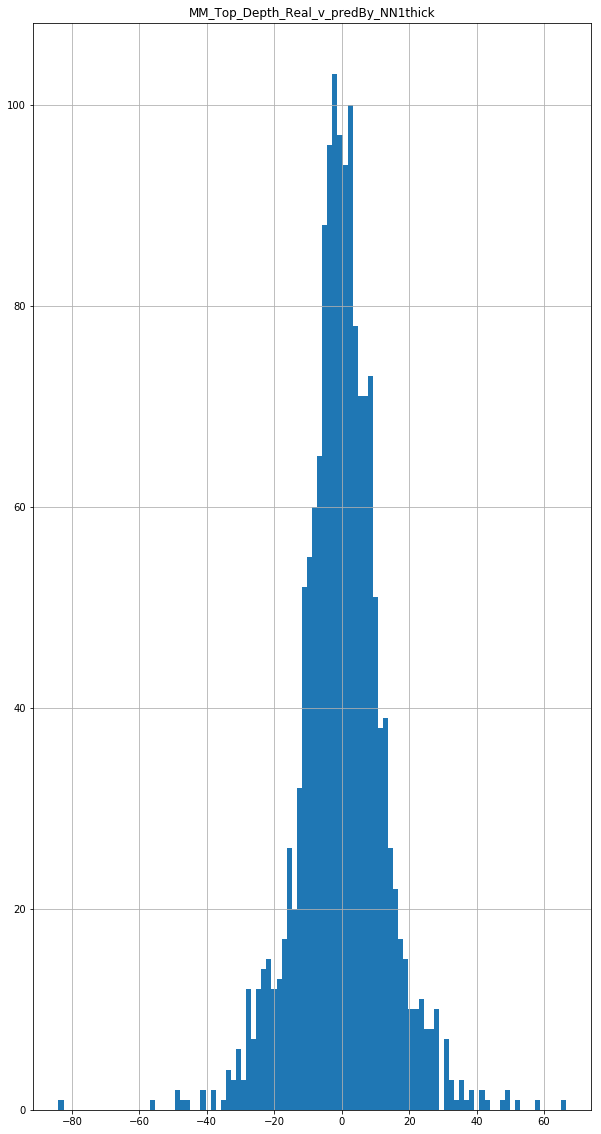

In [92]:
### Positive numbers are where real top is greater than predicted (200 vs. 100)
### Negative numbers are where real top is less than predicted top (0 vs. 500)
### Many negative numbers might be due to :
###    1) zeros & blanks being skipped in nearest neighbors and
###    2) not being skipped in 'real' tops 
doNotSaveThisDF_temp5.hist(column='MM_Top_Depth_Real_v_predBy_NN1thick', bins=100,figsize=(10,20))

## The really high negative values might be from wells that don't have a base pick ? 0 - thickness in neighboring well where as the high positive numbers might be wells that have a base in neighboring well but not in well being predicting for?

### Let's investigate further by looking at the distribution of the thickness in nieghboring wells

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2274da20>]],
      dtype=object)

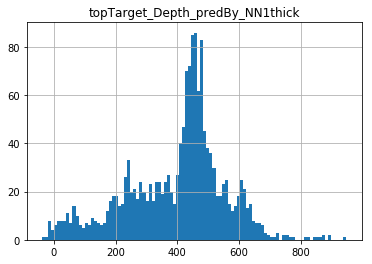

In [93]:
#MM_Top_Depth_Real_v_predBy_NN1thick
# temp5.hist(column='MM_Top_Depth_Real_v_predBy_NN1thick', bins=100)
doNotSaveThisDF_temp5.hist(column='topTarget_Depth_predBy_NN1thick', bins=100)

- Most are around 430 with a big range that has shoulders around 200 and 600 thickness. 
- There are a few with less than zero? Are thosse were there was a base but not a top or the other way?

#### Let's check to see how many McMurray_Top_DEPTH and McMurray_Base_DEPTH are zeros

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a22fad940>]],
      dtype=object)

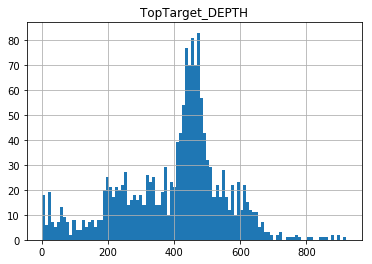

In [94]:
doNotSaveThisDF_temp5.hist(column='TopTarget_DEPTH', bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2312f518>]],
      dtype=object)

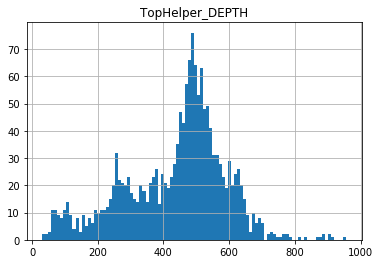

In [95]:
doNotSaveThisDF_temp5.hist(column='TopHelper_DEPTH', bins=100)

### Let's investigate what is causing the problem above and find out where the zeros or missing values are

First, get absolute numbers intead of just a histogram

In [96]:
df_test = doNotSaveThisDF_temp5.copy()

In [97]:
#### number of rows in each column with null values
df_test.isnull().sum()

SitID                                  0
lat                                    0
lng                                    0
UWI                                    0
TopHelper_HorID                        0
TopTarget_HorID                        0
TopHelper_DEPTH                        0
TopTarget_DEPTH                        0
TopHelper_HorID_Qual                   0
TopTarget_Qual                         0
Neighbors_Obj                          0
NN1_topTarget_DEPTH                    0
NN1_TopHelper_DEPTH                    0
NN1_thickness                          0
topTarget_Depth_predBy_NN1thick        0
MM_Top_Depth_Real_v_predBy_NN1thick    0
dtype: int64

In [98]:
#### number of rows in each column with zero values
df_test[df_test.NN1_topTarget_DEPTH == 0].count()

SitID                                  0
lat                                    0
lng                                    0
UWI                                    0
TopHelper_HorID                        0
TopTarget_HorID                        0
TopHelper_DEPTH                        0
TopTarget_DEPTH                        0
TopHelper_HorID_Qual                   0
TopTarget_Qual                         0
Neighbors_Obj                          0
NN1_topTarget_DEPTH                    0
NN1_TopHelper_DEPTH                    0
NN1_thickness                          0
topTarget_Depth_predBy_NN1thick        0
MM_Top_Depth_Real_v_predBy_NN1thick    0
dtype: int64

#### Looks like both are issue but Top is bigger issue.

In [99]:
df_test[df_test.TopHelper_DEPTH == 0].count()

SitID                                  0
lat                                    0
lng                                    0
UWI                                    0
TopHelper_HorID                        0
TopTarget_HorID                        0
TopHelper_DEPTH                        0
TopTarget_DEPTH                        0
TopHelper_HorID_Qual                   0
TopTarget_Qual                         0
Neighbors_Obj                          0
NN1_topTarget_DEPTH                    0
NN1_TopHelper_DEPTH                    0
NN1_thickness                          0
topTarget_Depth_predBy_NN1thick        0
MM_Top_Depth_Real_v_predBy_NN1thick    0
dtype: int64

### It appears there are 247 base McMurray picks with zero values and this is causing the problems
### Without a base, we can't add the nearest neighbor McMurray thickness to it and git a starting point to look for the top McMurray pick

### Below we will limit the dataset distribution to  only those wells that do have an interpreted McMurray base pick.

In [100]:
# no_zeros_df = df_test[(df_test['McMurray_Base_DEPTH']!=0) & (df_test['McMurray_Top_DEPTH']!=0)]
# no_zeros_df.hist(column='McMurray_Top_DEPTH', bins=100)

In [101]:
no_zeros_df =df_test.copy()

In [102]:
no_zeros_df['MM_Top_Depth_Real_v_predBy_NN1thick'][0:5]

0    0.0
1   -5.5
2    0.0
3   -3.5
4    5.0
Name: MM_Top_Depth_Real_v_predBy_NN1thick, dtype: float64

In [103]:
##no_zeros_df['MM_Top_Depth_Real_v_predBy_NN1thick'] =  no_zeros_df['McMurray_Top_DEPTH'] - no_zeros_df['MM_Top_Depth_predBy_NN1thick'] 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a23337128>]],
      dtype=object)

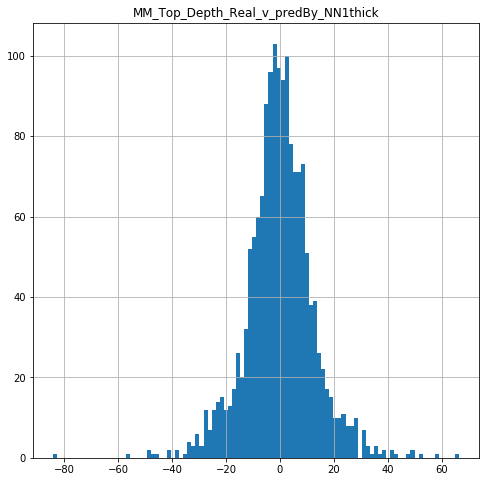

In [104]:
no_zeros_df.hist(column='MM_Top_Depth_Real_v_predBy_NN1thick', bins=100,figsize=(8,8))

In [105]:
len(no_zeros_df)

1601

### The histogram above seems more reasonable

Let's take out the column that might leak information about a wells top McMurray depth and then save this dataframe.

In [106]:
no_zeros_df_TopDepthVsNNleak = no_zeros_df.drop('MM_Top_Depth_Real_v_predBy_NN1thick', 1)

In [107]:
no_zeros_df_TopDepthVsNNleak

SitID        lat         lng                  UWI  TopHelper_HorID  \
0     102496  54.785907 -110.129320  00/12-08-067-01W4/0            14000   
1     102497  54.782284 -110.269446  00/07-08-067-02W4/0            14000   
2     102498  54.785892 -110.186851  00/09-11-067-02W4/0            14000   
3     102500  54.829624 -110.269422  00/10-29-067-02W4/0            14000   
4     102501  54.840471 -110.224832  00/06-34-067-02W4/0            14000   
5     102503  54.771449 -110.402983  00/11-04-067-03W4/0            14000   
6     102505  54.785901 -110.422131  00/10-08-067-03W4/0            14000   
7     102507  54.800533 -110.345762  00/10-14-067-03W4/0            14000   
8     102514  54.829633 -110.396621  00/10-28-067-03W4/0            14000   
9     102517  54.840441 -110.320301  00/07-36-067-03W4/0            14000   
10    102518  54.771451 -110.498414  00/10-02-067-04W4/0            14000   
11    102565  54.785896 -110.599928  00/10-07-067-04W4/0            14000   
12    102577  54.814989 -110.479147  00/11-24-067-04W4/0            14000   
13    102581  54.840482 -110.549109  00/07-33-067-04W4/0            14000   
14    102583  54.775090 -110.688675  00/13-03-067-05W4/0            14000   
15    102589  54.796954 -110.707896  00/06-16-067-05W4/0            14000   
16    102592  54.826012 -110.625318  00/07-25-067-05W4/0            14000   
17    102596  54.844116 -110.701599  00/10-33-067-05W4/0            14000   
18    102597  54.775087 -110.777910  00/15-01-067-06W4/0            14000   
19    102606  54.796947 -110.885862  00/06-17-067-06W4/0            14000   
20    141727  54.811402 -110.803309  00/07-23-067-06W4/0            14000   
21    102609  54.822471 -110.879581  00/02-29-067-06W4/0            14000   
22    102610  54.771468 -111.038407  00/11-05-067-07W4/0            14000   
23    102611  54.796937 -110.936727  00/06-13-067-07W4/0            14000   
24    102614  54.822460 -110.936727  00/03-25-067-07W4/0            14000   
25    102615  54.826041 -111.025865  00/08-29-067-07W4/0            14000   
26    102619  54.771478 -111.133860  00/10-03-067-08W4/0            14000   
27    102620  54.796927 -111.089256  00/06-13-067-08W4/0            14000   
28    141732  54.829658 -111.184726  00/10-29-067-08W4/0            14000   
29    102626  54.840503 -111.133864  00/07-34-067-08W4/0            14000   
30    163611  54.826009 -111.445246  00/06-27-067-10W4/0            14000   
31    163612  54.844056 -111.508948  00/09-31-067-10W4/0            14000   
32    102630  54.764109 -111.674106  00/03-06-067-11W4/0            14000   
33    163614  54.844075 -111.616965  00/10-33-067-11W4/0            14000   
34    141733  54.767736 -111.718675  00/07-02-067-12W4/0            14000   
35    102633  54.767676 -111.788610  00/08-05-067-12W4/0            14000   
36    102640  54.796863 -111.699581  00/06-13-067-12W4/0            14000   
37    141734  54.811292 -111.737853  00/08-22-067-12W4/2            14000   
38    102656  54.771211 -111.902778  00/11-03-067-13W4/0            14000   
39    102666  54.843896 -111.896572  00/10-34-067-13W4/0            14000   
40    102671  54.843897 -111.852009  00/11-36-067-13W4/0            14000   
41    102672  54.767516 -112.055371  00/06-03-067-14W4/0            14000   
42    102679  54.785519 -112.112394  00/12-08-067-14W4/0            14000   
43    102681  54.785555 -112.055334  00/11-10-067-14W4/0            14000   
44    102684  54.803748 -112.137831  00/13-18-067-14W4/0            14000   
45    102686  54.767425 -112.169807  00/08-02-067-15W4/0            14000   
46    141736  54.770993 -112.277768  00/10-06-067-15W4/0            14000   
47    102698  54.814564 -112.207734  00/11-22-067-15W4/0            14000   
48    102702  54.839992 -112.284017  00/06-31-067-15W4/0            14000   
49    102710  54.782042 -112.430364  00/07-07-067-16W4/0            14000   
50    102714  54.785454 -112.309435  00/11-12-067-16W4/0            14000   
51 

In [108]:
#### dumping wells dataframe that has no zeros in NN depth to pickle file
pickle.dump(no_zeros_df_TopDepthVsNNleak, open( "wells_df__NB_KDtreePost20180927_vA__NoMcTopLeak_v3.p", "wb" ) )
# pickle.dump( wells_df_new_cleaned_plus_nn, open( "wells_df_new_cleaned_plus_nn.p", "wb" ) )

### Let's look at the results on a map

In [109]:
import os
import folium
print(folium.__version__)
import branca.colormap as cm
import os
import math
env = %env
pd.set_option('display.max_rows', 2000)

0.5.0


In [110]:
linear2 = cm.LinearColormap(
    ['#edf8b1','#7fcdbb','#2c7fb8','#273891'],
    vmin=-100, vmax=75
)

linear2


# linear3 = cm.LinearColormap(
#     ['darkblue','blue','lightblue','lightgreen','green','darkgreen'],
#      vmax=75,vmin=-100,
# )

# linear3

In [111]:
def depth_color(depth):
    if(math.isnan(depth)):
        print(" math.isnan(depth) => ", depth)
        return 'blue'
    else:
        depth = float(depth)
        if depth >= 50:
            color = '#3182bd'
        elif depth > 10 and depth < 50:
            color = '#9ecae1'
        elif depth > -10 and depth < 10:
            color = 'green'
        elif depth > -50 and depth < -10:
            color = '#ffeda0'
        elif depth > -150 and depth < -50:
            color = '#feb24c'
        elif depth > -300 and depth < -150:
            color = '#f03b20'
        else:
            color = 'blue'
    return color

In [112]:
def depth_color3(depth,colorMap):
    if(math.isnan(depth)):
        print("!!!!!!!!!!!!!!!!!!!!  ' '  or nan is in depth => ", depth)
        color = '#000000'
    else:
        depth = float(depth)
        print("depth in colormap 3",depth)
        color = colorMap(depth)
        
    print("color = ",color)    
    return color

In [113]:
center2 = [54.840471, -110.269399]
zoom2 = 6
m5 = folium.Map(center2, tiles='Stamen Toner', zoom_start=zoom2)

In [114]:


list_df_for_map = no_zeros_df.values.tolist()

for row in list_df_for_map[0:]:
    print("location = ",row[1:3]," and depth is",row[12:13][0], " and UWI is ",row[3:4][0])
    folium.CircleMarker(
    location=row[1:3],
    radius=2,
    color=depth_color(row[13:14][0]),
    fill=True,
#     popup=folium.Popup(str(row[9:10][0])+ " & depth Top McMurray=", parse_html=True)    
#     popup=folium.Popup(str(row[9:10][0]+ ", depth Top McMurray="+str(row[15:16][0])), parse_html=True)
    ).add_to(m5)


# for row in list_df_for_map[0:]:
#     print("location = ",row[7:9]," and depth is",row[15:16][0], " and UWI is ",row[9:10][0])
#     folium.CircleMarker(
#     location=row[7:9],
#     radius=2,
#     color=depth_color(row[15:16][0]),
#     fill=True,
# #     popup=folium.Popup(str(row[9:10][0])+ " & depth Top McMurray=", parse_html=True)    
# #     popup=folium.Popup(str(row[9:10][0]+ ", depth Top McMurray="+str(row[15:16][0])), parse_html=True)
#     ).add_to(m5)

location =  [54.785906999999995, -110.12931999999999]  and depth is 630.0  and UWI is  00/12-08-067-01W4/0
location =  [54.782284, -110.269446]  and depth is 613.0  and UWI is  00/07-08-067-02W4/0
location =  [54.785892000000004, -110.186851]  and depth is 613.0  and UWI is  00/09-11-067-02W4/0
location =  [54.829624, -110.26942199999999]  and depth is 613.0  and UWI is  00/10-29-067-02W4/0
location =  [54.840470999999994, -110.224832]  and depth is 603.0  and UWI is  00/06-34-067-02W4/0
location =  [54.771449, -110.402983]  and depth is 558.0  and UWI is  00/11-04-067-03W4/0
location =  [54.785901, -110.42213100000001]  and depth is 558.0  and UWI is  00/10-08-067-03W4/0
location =  [54.800532999999994, -110.34576200000001]  and depth is 558.0  and UWI is  00/10-14-067-03W4/0
location =  [54.829632999999994, -110.396621]  and depth is 572.5  and UWI is  00/10-28-067-03W4/0
location =  [54.840441000000006, -110.320301]  and depth is 606.5  and UWI is  00/07-36-067-03W4/0
location =  [5

location =  [54.916755, -111.89666100000001]  and depth is 472.44  and UWI is  00/10-27-068-13W4/0
location =  [54.92759, -111.89663700000001]  and depth is 472.44  and UWI is  00/07-34-068-13W4/0
location =  [54.916751, -112.00455600000001]  and depth is 445.01  and UWI is  00/11-25-068-14W4/0
location =  [54.92759399999999, -112.049124]  and depth is 478.54  and UWI is  00/07-34-068-14W4/0
location =  [54.931203000000004, -112.284175]  and depth is 454.15  and UWI is  00/11-31-068-15W4/0
location =  [54.858266, -112.309458]  and depth is 561.44  and UWI is  00/11-01-068-16W4/0
location =  [54.872958999999994, -112.58929199999999]  and depth is 489.81  and UWI is  00/11-07-068-17W4/0
location =  [54.887595, -112.59553500000001]  and depth is 489.81  and UWI is  00/12-18-068-17W4/0
location =  [54.913081000000005, -112.58298]  and depth is 533.4  and UWI is  00/07-30-068-17W4/0
location =  [54.858523, -112.665477]  and depth is 505.66  and UWI is  00/11-03-068-18W4/0
location =  [54.87

location =  [55.058528, -111.76970700000001]  and depth is 490.73  and UWI is  00/07-16-070-12W4/0
location =  [55.076579, -111.776028]  and depth is 465.12  and UWI is  00/11-21-070-12W4/0
location =  [55.09129, -111.744183]  and depth is 486.77  and UWI is  00/10-27-070-12W4/0
location =  [55.029452, -111.95369299999999]  and depth is 469.0  and UWI is  00/06-05-070-13W4/0
location =  [55.043803000000004, -111.87756599999999]  and depth is 480.0  and UWI is  00/06-11-070-13W4/0
location =  [55.072952, -111.909252]  and depth is 483.0  and UWI is  00/05-22-070-13W4/0
location =  [55.087517000000005, -111.877633]  and depth is 483.0  and UWI is  00/06-26-070-13W4/0
location =  [55.102132999999995, -112.125386]  and depth is 517.0  and UWI is  00/07-31-070-14W4/0
location =  [55.102141, -112.112443]  and depth is 517.0  and UWI is  00/05-32-070-14W4/0
location =  [55.033105000000006, -112.28421499999999]  and depth is 505.0  and UWI is  00/11-06-070-15W4/0
location =  [55.058615, -112.2

location =  [55.117231999999994, -113.233851]  and depth is 601.0  and UWI is  00/05-06-071-21W4/0
location =  [55.131826000000004, -113.381231]  and depth is 601.37  and UWI is  00/06-07-071-22W4/0
location =  [55.13183000000001, -113.278779]  and depth is 623.0  and UWI is  00/06-11-071-22W4/0
location =  [55.157331000000006, -113.298073]  and depth is 601.37  and UWI is  00/02-22-071-22W4/0
location =  [55.175552, -113.355674]  and depth is 625.45  and UWI is  00/06-29-071-22W4/0
location =  [55.160913, -113.400609]  and depth is 601.37  and UWI is  00/07-24-071-23W4/0
location =  [55.193603, -113.4776]  and depth is 592.0  and UWI is  00/10-33-071-23W4/0
location =  [55.150011, -113.68278400000001]  and depth is 638.56  and UWI is  00/10-18-071-24W4/0
location =  [55.164496, -113.637832]  and depth is 633.98  and UWI is  00/11-21-071-24W4/0
location =  [55.193553, -113.682823]  and depth is 643.74  and UWI is  00/10-31-071-24W4/0
location =  [55.197188, -113.58655700000001]  and de

location =  [55.208211999999996, -113.554585]  and depth is 635.0  and UWI is  00/10-01-072-24W4/0
location =  [55.219079, -113.65712099999999]  and depth is 612.65  and UWI is  00/07-08-072-24W4/0
location =  [55.262787, -113.682782]  and depth is 535.23  and UWI is  00/07-30-072-24W4/0
location =  [55.280846, -113.68276399999999]  and depth is 600.0  and UWI is  00/10-31-072-24W4/0
location =  [55.204601000000004, -113.836597]  and depth is 622.4  and UWI is  00/07-06-072-25W4/0
location =  [55.219086, -113.766079]  and depth is 622.4  and UWI is  00/06-10-072-25W4/0
location =  [55.280855, -113.785322]  and depth is 598.02  and UWI is  00/10-33-072-25W4/0
location =  [55.208681999999996, -114.06933500000001]  and depth is 670.0  and UWI is  00/11-03-072-01W5/0
location =  [55.223151, -114.120617]  and depth is 693.72  and UWI is  00/11-08-072-01W5/0
location =  [55.241381000000004, -114.01172199999999]  and depth is 693.72  and UWI is  00/15-13-072-01W5/0
location =  [55.281312, -11

location =  [55.339463, -114.57571399999999]  and depth is 615.0  and UWI is  00/10-20-073-04W5/0
location =  [55.288691, -114.62065600000001]  and depth is 587.5  and UWI is  00/01-01-073-05W5/0
location =  [55.339473999999996, -114.74256399999999]  and depth is 587.5  and UWI is  00/12-20-073-05W5/0
location =  [55.346877, -114.652626]  and depth is 615.0  and UWI is  00/02-26-073-05W5/0
location =  [55.357765, -114.723423]  and depth is 587.5  and UWI is  00/16-29-073-05W5/0
location =  [55.393588, -110.12421599999999]  and depth is 579.0  and UWI is  00/06-08-074-01W4/0
location =  [55.440925, -110.12421299999998]  and depth is 517.55  and UWI is  00/11-29-074-01W4/0
location =  [55.437389, -110.35508999999999]  and depth is 488.0  and UWI is  00/06-26-074-03W4/0
location =  [55.382811, -110.586281]  and depth is 480.0  and UWI is  00/11-05-074-04W4/0
location =  [55.39726700000001, -110.57993300000001]  and depth is 415.0  and UWI is  00/10-08-074-04W4/0
location =  [55.4227319999

location =  [55.542637, -111.30938]  and depth is 492.0  and UWI is  00/10-34-075-09W4/0
location =  [55.466421, -111.471001]  and depth is 512.5  and UWI is  00/06-03-075-10W4/0
location =  [55.480853, -111.61981599999999]  and depth is 505.97  and UWI is  00/07-10-075-11W4/0
location =  [55.513554000000006, -111.652078]  and depth is 508.41  and UWI is  00/11-21-075-11W4/0
location =  [55.495477, -111.729699]  and depth is 515.0  and UWI is  00/06-13-075-12W4/0
location =  [55.499091, -111.85906499999999]  and depth is 528.52  and UWI is  00/11-18-075-12W4/0
location =  [55.524564, -111.729698]  and depth is 505.97  and UWI is  00/06-25-075-12W4/0
location =  [55.528181000000004, -111.852675]  and depth is 544.07  and UWI is  00/10-30-075-12W4/0
location =  [55.473615, -112.00795500000001]  and depth is 627.89  and UWI is  00/15-06-075-13W4/0
location =  [55.480841000000005, -111.878555]  and depth is 544.07  and UWI is  00/07-12-075-13W4/0
location =  [55.509928, -111.87855400000001

location =  [55.61545, -111.93671299999998]  and depth is 576.0  and UWI is  00/11-27-076-13W4/0
location =  [55.553658, -112.14371799999999]  and depth is 540.0  and UWI is  00/06-05-076-14W4/0
location =  [55.57173100000001, -112.091967]  and depth is 525.0  and UWI is  00/11-10-076-14W4/0
location =  [55.5972, -112.14372]  and depth is 557.78  and UWI is  00/06-20-076-14W4/0
location =  [55.60826899999999, -112.08558000000001]  and depth is 535.0  and UWI is  00/02-27-076-14W4/0
location =  [55.61544, -112.163207]  and depth is 496.0  and UWI is  00/10-30-076-14W4/0
location =  [55.553681000000005, -112.221347]  and depth is 565.1  and UWI is  00/06-02-076-15W4/0
location =  [55.568135999999996, -112.29258700000001]  and depth is 565.0  and UWI is  00/07-08-076-15W4/0
location =  [55.571752000000004, -112.247225]  and depth is 585.0  and UWI is  00/11-10-076-15W4/0
location =  [55.626316, -112.29258999999999]  and depth is 565.1  and UWI is  00/07-32-076-15W4/0
location =  [55.59724

location =  [55.684487, -112.350727]  and depth is 555.0  and UWI is  00/06-24-077-16W4/0
location =  [55.702749, -112.376599]  and depth is 555.0  and UWI is  00/11-26-077-16W4/0
location =  [55.71719399999999, -112.58359499999999]  and depth is 571.5  and UWI is  00/11-33-077-17W4/0
location =  [55.702688, -113.043002]  and depth is 394.41  and UWI is  00/10-28-077-20W4/0
location =  [55.644493999999995, -113.17875500000001]  and depth is 586.0  and UWI is  00/11-03-077-21W4/0
location =  [55.658931, -113.250003]  and depth is 647.4  and UWI is  00/10-07-077-21W4/0
location =  [55.640879000000005, -113.33401]  and depth is 596.8  and UWI is  00/06-03-077-22W4/0
location =  [55.68441899999999, -113.359889]  and depth is 527.91  and UWI is  00/06-21-077-22W4/0
location =  [55.713502000000005, -113.379377]  and depth is 527.91  and UWI is  00/07-32-077-22W4/0
location =  [55.717119999999994, -113.334011]  and depth is 536.0  and UWI is  00/11-34-077-22W4/0
location =  [55.640889, -113.5

location =  [55.790303, -114.327952]  and depth is 624.23  and UWI is  00/11-25-078-03W5/0
location =  [55.80483, -114.767738]  and depth is 644.96  and UWI is  00/11-31-078-05W5/0
location =  [55.858947, -110.315196]  and depth is 326.0  and UWI is  00/05-19-079-02W4/0
location =  [55.819041000000006, -110.43289399999999]  and depth is 395.5  and UWI is  00/10-05-079-03W4/0
location =  [55.815428000000004, -110.458996]  and depth is 393.0  and UWI is  00/07-06-079-03W4/0
location =  [55.837104000000004, -110.348142]  and depth is 395.5  and UWI is  00/16-11-079-03W4/0
location =  [55.840947, -110.43289399999999]  and depth is 403.0  and UWI is  00/02-17-079-03W4/0
location =  [55.819038, -110.58952]  and depth is 372.5  and UWI is  00/10-05-079-04W4/0
location =  [55.858965000000005, -110.58952]  and depth is 298.7  and UWI is  00/07-20-079-04W4/0
location =  [55.87721, -110.511204]  and depth is 298.7  and UWI is  00/10-26-079-04W4/0
location =  [55.89166899999999, -110.5634149999999

location =  [55.902663000000004, -110.98754]  and depth is 376.0  and UWI is  00/06-02-080-07W4/0
location =  [55.96445500000001, -110.98107399999999]  and depth is 339.0  and UWI is  AA/10-26-080-07W4/0
location =  [55.964451000000004, -111.05938]  and depth is 431.5  and UWI is  AA/10-29-080-07W4/0
location =  [55.971678000000004, -111.065822]  and depth is 431.5  and UWI is  00/03-32-080-07W4/0
location =  [55.913513, -111.144131]  and depth is 393.0  and UWI is  00/03-11-080-08W4/0
location =  [55.93536999999999, -111.13768400000001]  and depth is 443.0  and UWI is  00/10-14-080-08W4/0
location =  [55.960843000000004, -111.13768]  and depth is 403.5  and UWI is  AA/07-26-080-08W4/0
location =  [55.964456000000006, -111.21598200000001]  and depth is 443.0  and UWI is  AA/10-29-080-08W4/0
location =  [55.917116, -111.37903899999999]  and depth is 467.26  and UWI is  00/06-08-080-09W4/0
location =  [55.920730000000006, -111.294288]  and depth is 490.0  and UWI is  00/10-11-080-09W4/0


location =  [56.062535, -111.829172]  and depth is 531.0  and UWI is  00/05-33-081-12W4/0
location =  [56.007964, -111.99908500000001]  and depth is 500.0  and UWI is  AA/10-08-081-13W4/0
location =  [56.007968000000005, -111.933582]  and depth is 530.0  and UWI is  AA/12-11-081-13W4/0
location =  [56.051683999999995, -111.99908899999998]  and depth is 455.5  and UWI is  AA/10-29-081-13W4/0
location =  [56.00796, -112.155699]  and depth is 452.63  and UWI is  AA/10-08-081-14W4/0
location =  [56.022589, -112.07095100000001]  and depth is 478.0  and UWI is  00/09-14-081-14W4/0
location =  [56.051677000000005, -112.07739699999999]  and depth is 347.0  and UWI is  AA/10-26-081-14W4/0
location =  [56.051680000000005, -112.15570100000001]  and depth is 382.0  and UWI is  AA/10-29-081-14W4/0
location =  [56.066128000000006, -112.234008]  and depth is 323.5  and UWI is  00/10-35-081-15W4/0
location =  [55.993506000000004, -112.416723]  and depth is 334.0  and UWI is  00/10-03-081-16W4/0
locati

location =  [56.124274, -113.101818]  and depth is 369.42  and UWI is  AA/11-20-082-20W4/0
location =  [56.135293000000004, -113.023509]  and depth is 386.49  and UWI is  00/06-26-082-20W4/0
location =  [56.084337, -113.258436]  and depth is 443.18  and UWI is  AA/14-05-082-21W4/0
location =  [56.09157, -113.219443]  and depth is 428.0  and UWI is  00/08-09-082-21W4/0
location =  [56.113422, -113.25843400000001]  and depth is 443.18  and UWI is  AA/14-17-082-21W4/0
location =  [56.135286, -113.19978300000001]  and depth is 442.5  and UWI is  00/07-27-082-21W4/0
location =  [56.12063199999999, -113.33673600000002]  and depth is 442.5  and UWI is  00/06-23-082-22W4/0
location =  [56.138875, -113.33029099999999]  and depth is 442.5  and UWI is  AA/10-26-082-22W4/0
location =  [56.087934, -113.48046799999999]  and depth is 456.0  and UWI is  00/01-11-082-23W4/0
location =  [56.138884999999995, -113.66962]  and depth is 392.0  and UWI is  00/10-27-082-24W4/0
location =  [56.091574, -113.800

location =  [56.342704000000005, -111.60248100000001]  and depth is 372.0  and UWI is  00/11-01-085-11W4/0
location =  [56.342696999999994, -111.734145]  and depth is 256.64  and UWI is  AA/11-06-085-11W4/0
location =  [56.371791, -111.69481299999998]  and depth is 282.0  and UWI is  AA/09-17-085-11W4/0
location =  [56.382631999999994, -111.628817]  and depth is 273.5  and UWI is  00/06-23-085-11W4/0
location =  [56.3718, -111.81315]  and depth is 289.56  and UWI is  AA/11-15-085-12W4/0
location =  [56.382619999999996, -111.75398100000001]  and depth is 251.5  and UWI is  AA/07-24-085-12W4/0
location =  [56.335469999999994, -112.274176]  and depth is 262.0  and UWI is  00/01-03-085-15W4/0
location =  [56.335468000000006, -112.326844]  and depth is 246.0  and UWI is  00/01-05-085-15W4/0
location =  [56.371795, -112.52423799999998]  and depth is 282.0  and UWI is  00/11-18-085-16W4/0
location =  [56.379020999999995, -112.58340700000001]  and depth is 251.16  and UWI is  00/04-23-085-17W4

location =  [56.807947999999996, -113.09902199999999]  and depth is 231.0  and UWI is  00/10-15-090-20W4/0
location =  [56.822399, -113.105585]  and depth is 231.0  and UWI is  00/11-22-090-20W4/0
location =  [56.855138000000004, -113.10558400000001]  and depth is 244.5  and UWI is  00/14-34-090-20W4/0
location =  [56.844243999999996, -113.058897]  and depth is 245.0  and UWI is  00/04-36-090-20W4/0
location =  [56.85909100000001, -111.122431]  and depth is 185.0  and UWI is  AA/03-06-091-07W4/0
location =  [56.859097, -111.155796]  and depth is 185.0  and UWI is  AA/04-01-091-08W4/0
location =  [56.877201, -111.497932]  and depth is 101.5  and UWI is  AA/06-11-091-10W4/0
location =  [56.891822999999995, -112.034526]  and depth is 123.0  and UWI is  AA/06-16-091-13W4/0
location =  [56.928132999999995, -112.13525700000001]  and depth is 210.0  and UWI is  AA/15-26-091-14W4/0
location =  [56.924515, -112.296297]  and depth is 186.54  and UWI is  AA/10-26-091-15W4/0
location =  [56.924516

location =  [57.229921999999995, -110.856481]  and depth is 325.0  and UWI is  AA/10-11-095-06W4/0
location =  [57.20821, -110.98517199999999]  and depth is 301.0  and UWI is  AA/01-01-095-07W4/0
location =  [57.237367000000006, -111.025622]  and depth is 297.0  and UWI is  00/03-14-095-07W4/0
location =  [57.280846999999994, -111.012245]  and depth is 175.0  and UWI is  AA/01-35-095-07W4/0
location =  [57.27723100000001, -111.55374499999999]  and depth is 113.0  and UWI is  AB/16-28-095-10W4/0
location =  [57.226259999999996, -112.42041599999999]  and depth is 287.0  and UWI is  00/08-07-095-15W4/0
location =  [57.22264499999999, -112.46087]  and depth is 316.69  and UWI is  00/03-12-095-16W4/0
location =  [57.269968999999996, -112.46087299999999]  and depth is 300.0  and UWI is  AA/06-25-095-16W4/0
location =  [57.28441899999999, -112.46087299999999]  and depth is 300.0  and UWI is  00/06-36-095-16W4/0
location =  [57.208192000000004, -112.738302]  and depth is 278.0  and UWI is  00/

In [115]:
m5

### In general it seems the variance is relatively evenly distributed. 
A lot of the map has green, which means the neighboring wells thickness + base results in a top prediction that is within plus or minues 10 feet. Where the difference is outside that range, it seems it isn't that much farther off most of the time. There might be some areas in NE and eastern margin where variance is larger than in central area.

In [116]:
m5.save(os.path.join('.', 'MM_Top_Depth_Real_v_predBy_NN1thick_v2.html'))

## Lets now look at the distribution of the difference between target depth and depth predicted just from nearest neighbor

In [117]:
no_zeros_df_TopDepthVsNN = no_zeros_df.copy()

In [118]:
no_zeros_df_TopDepthVsNN.head()

SitID        lat         lng                  UWI  TopHelper_HorID  \
0  102496  54.785907 -110.129320  00/12-08-067-01W4/0            14000   
1  102497  54.782284 -110.269446  00/07-08-067-02W4/0            14000   
2  102498  54.785892 -110.186851  00/09-11-067-02W4/0            14000   
3  102500  54.829624 -110.269422  00/10-29-067-02W4/0            14000   
4  102501  54.840471 -110.224832  00/06-34-067-02W4/0            14000   

   TopTarget_HorID  TopHelper_DEPTH  TopTarget_DEPTH  TopHelper_HorID_Qual  \
0            13000            561.0            475.0                     1   
1            13000            604.5            515.0                     1   
2            13000            564.0            480.0                     1   
3            13000            636.5            549.0                     1   
4            13000            613.0            529.0                     1   

   TopTarget_Qual                                      Neighbors_Obj  \
0               3  [{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0',...   
1               3  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...   
2               3  [{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0',...   
3               3  [{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0',...   
4               2  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...   

   NN1_topTarget_DEPTH  NN1_TopHelper_DEPTH  NN1_thickness  \
0                544.0                630.0           86.0   
1                529.0                613.0           84.0   
2                529.0                613.0           84.0   
3                529.0                613.0           84.0   
4                514.0                603.0           89.0   

   topTarget_Depth_predBy_NN1thick  MM_Top_Depth_Real_v_predBy_NN1thick  
0                            475.0                                  0.0  
1                            520.5                                 -5.5  
2                            480.0                                  0.0  
3                            552.5                                 -3.5  
4                            524.0                                  5.0

In [119]:
def error_color(depth):
    if(math.isnan(depth)):
        print(" math.isnan(depth) => ", depth)
        return 'blue'
    else:
        depth = float(depth)
        if depth >= 80:
            color = 'black'
        elif depth >= 30 and depth < 60:
            color = 'orange'
        elif depth > 5 and depth < 30:
            color = 'yellow'
        elif depth >= -5 and depth <= 5:
            color = 'green'
        elif depth >= -30 and depth < -5:
            color = 'brown'
        elif depth >= -60 and depth < -30:
            color = 'purple'
        else:
            color = 'pink'
    return color

In [120]:
def makeMap(centerLatLongArray,tilesStr,zoom_startInt,radiusInt,df):
    m7 = folium.Map(centerLatLongArray, tiles=tilesStr, zoom_start=zoom_startInt)
    list_df_for_map = df.values.tolist()

    for row in list_df_for_map[0:]:
        #print("location = ",row[1:3]," and depth is",row[12:13][0], " and UWI is ",row[3:4][0])
        folium.CircleMarker(
        location=row[1:3],
        radius=radiusInt,
        color=error_color(row[15:16][0]),
        fill=True,
         #popup=folium.Popup(str(row[9:10][0])+ " & depth Top McMurray=", parse_html=True)    
         popup=folium.Popup((str(row[1:3])+ ", error in Top Target="+str(row[15:16][0])), parse_html=True)
        ).add_to(m7)
    return m7


In [121]:
m7 = makeMap([54.840471, -110.269399],'Stamen Toner',6,2,no_zeros_df_TopDepthVsNN)

In [122]:
m7

# Now we'll do that same things as above but only for the train rows!

In [123]:
no_zeros_df.head()

SitID        lat         lng                  UWI  TopHelper_HorID  \
0  102496  54.785907 -110.129320  00/12-08-067-01W4/0            14000   
1  102497  54.782284 -110.269446  00/07-08-067-02W4/0            14000   
2  102498  54.785892 -110.186851  00/09-11-067-02W4/0            14000   
3  102500  54.829624 -110.269422  00/10-29-067-02W4/0            14000   
4  102501  54.840471 -110.224832  00/06-34-067-02W4/0            14000   

   TopTarget_HorID  TopHelper_DEPTH  TopTarget_DEPTH  TopHelper_HorID_Qual  \
0            13000            561.0            475.0                     1   
1            13000            604.5            515.0                     1   
2            13000            564.0            480.0                     1   
3            13000            636.5            549.0                     1   
4            13000            613.0            529.0                     1   

   TopTarget_Qual                                      Neighbors_Obj  \
0               3  [{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0',...   
1               3  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...   
2               3  [{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0',...   
3               3  [{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0',...   
4               2  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...   

   NN1_topTarget_DEPTH  NN1_TopHelper_DEPTH  NN1_thickness  \
0                544.0                630.0           86.0   
1                529.0                613.0           84.0   
2                529.0                613.0           84.0   
3                529.0                613.0           84.0   
4                514.0                603.0           89.0   

   topTarget_Depth_predBy_NN1thick  MM_Top_Depth_Real_v_predBy_NN1thick  
0                            475.0                                  0.0  
1                            520.5                                 -5.5  
2                            480.0                                  0.0  
3                            552.5                                 -3.5  
4                            524.0                                  5.0

## Import df with train/test split column

In [124]:
# h5_filename_df_wells_wTrainTestSplitCol = 'df_all_wells_noKNNorFeatures_wTrainSplit_20180927_c.h5'

wellsLoaded_df_fromh5 = pd.read_hdf(loaded_wells_splitTrainTest_dir+loaded_wells_splitTrainTest_df, 'df')

In [125]:
wellsLoaded_df_fromh5.head()

CALI  COND  DELT     DEPT   DPHI  DT       GR    ILD  ILM   NPHI  PHID  \
0  167.003   NaN   NaN  149.602  0.227 NaN  102.473  0.000  NaN  0.460   NaN   
1  199.159   NaN   NaN  149.852  0.263 NaN  122.589  4.202  NaN  0.550   NaN   
2  200.496   NaN   NaN  150.102  0.252 NaN  120.196  4.643  NaN  0.537   NaN   
3  203.933   NaN   NaN  150.352  0.244 NaN  115.975  5.280  NaN  0.513   NaN   
4  203.664   NaN   NaN  150.602  0.240 NaN  109.271  6.592  NaN  0.487   NaN   

   RHOB  SFL  SFLU  SN  SP                      UWI trainOrTest  
0   NaN  NaN   NaN NaN NaN  00-10-32-080-20W4-0.LAS       train  
1   NaN  NaN   NaN NaN NaN  00-10-32-080-20W4-0.LAS       train  
2   NaN  NaN   NaN NaN NaN  00-10-32-080-20W4-0.LAS       train  
3   NaN  NaN   NaN NaN NaN  00-10-32-080-20W4-0.LAS       train  
4   NaN  NaN   NaN NaN NaN  00-10-32-080-20W4-0.LAS       train

In [126]:
def changeUWIcol(df,colName):
    #df['a'] = df['a'].apply(lambda x: x + 1)
    df[colName] = df[colName].apply(lambda x: changeLASfileToBeUWIstr(x))
    return df

In [127]:
wellsLoaded_df_fromh5_newUWI = changeUWIcol(wellsLoaded_df_fromh5,'UWI')

### Now lets only keep the train wells

In [128]:
wells_train_only = wellsLoaded_df_fromh5_newUWI.loc[wellsLoaded_df_fromh5_newUWI['trainOrTest'] == 'train']

In [129]:
wells_train_only.head()

CALI  COND  DELT     DEPT   DPHI  DT       GR    ILD  ILM   NPHI  PHID  \
0  167.003   NaN   NaN  149.602  0.227 NaN  102.473  0.000  NaN  0.460   NaN   
1  199.159   NaN   NaN  149.852  0.263 NaN  122.589  4.202  NaN  0.550   NaN   
2  200.496   NaN   NaN  150.102  0.252 NaN  120.196  4.643  NaN  0.537   NaN   
3  203.933   NaN   NaN  150.352  0.244 NaN  115.975  5.280  NaN  0.513   NaN   
4  203.664   NaN   NaN  150.602  0.240 NaN  109.271  6.592  NaN  0.487   NaN   

   RHOB  SFL  SFLU  SN  SP                  UWI trainOrTest  
0   NaN  NaN   NaN NaN NaN  00/10-32-080-20W4/0       train  
1   NaN  NaN   NaN NaN NaN  00/10-32-080-20W4/0       train  
2   NaN  NaN   NaN NaN NaN  00/10-32-080-20W4/0       train  
3   NaN  NaN   NaN NaN NaN  00/10-32-080-20W4/0       train  
4   NaN  NaN   NaN NaN NaN  00/10-32-080-20W4/0       train

In [130]:
len(wells_train_only)

1046749

In [131]:
len(wells_train_only['UWI'].unique())

1280

## Okay, now let's do the nearest neighbor process with only the train wells!

In [132]:
# def useThicknessOfNeighborsToEst_TRAIN(df_new2):
#     df_new2['NN1_topTarget_DEPTH_train'] = df_new2['NN1_topTarget_DEPTH_train'].apply(convertStringToFloat)
#     df_new2['NN1_TopHelper_DEPTH_train'] = df_new2['NN1_TopHelper_DEPTH_train'].apply(convertStringToFloat)
#     df_new2['TopHelper_DEPTH'] = df_new2['TopHelper_DEPTH'].apply(convertStringToFloat)
#     df_new2['TopTarget_DEPTH'] = df_new2['TopTarget_DEPTH'].apply(convertStringToFloat)
#     df_new2['NN1_thickness_train'] = df_new2['NN1_TopHelper_DEPTH_train'] - df_new2['NN1_topTarget_DEPTH_train']
#     df_new2['topTarget_Depth_predBy_NN1thick_train'] =  df_new2['TopHelper_DEPTH'] - df_new2['NN1_thickness_train'] 
#     return df_new2

def useThicknessOfNeighborsToEst_TRAIN(df_new2):
    df_new2['NN1_topTarget_DEPTH'] = df_new2['NN1_topTarget_DEPTH'].apply(convertStringToFloat)
    df_new2['NN1_TopHelper_DEPTH'] = df_new2['NN1_TopHelper_DEPTH'].apply(convertStringToFloat)
    df_new2['TopHelper_DEPTH'] = df_new2['TopHelper_DEPTH'].apply(convertStringToFloat)
    df_new2['TopTarget_DEPTH'] = df_new2['TopTarget_DEPTH'].apply(convertStringToFloat)
    df_new2['NN1_thickness'] = df_new2['NN1_TopHelper_DEPTH'] - df_new2['NN1_topTarget_DEPTH']
    df_new2['topTarget_Depth_predBy_NN1thick'] =  df_new2['TopHelper_DEPTH'] - df_new2['NN1_thickness'] 
    return df_new2

In [133]:
def makeKNearNeighObj_train(df_new,KDtree,numberNeighbors):
    #### Takes in 
    #### Returns 
    
    ##### first part......
    #### make a data frame of UWI & index from main dataframe
    UWIs = df_new[['UWI']]
    position = df_new[['lat','lng']]
    #UWIs.join(position, how='outer') 
    UWIs_Geog = pd.concat([UWIs, position], axis=1)
    #print(UWIs_Geog.head())
    #### Add object of tree for 8 neighbors to a dataframe
    latlng_kd_tree_leaf2 = KDtree
    #### Finding 8 nearest neighbors based on lat/long
    #### K is number of neighbors
    dist, ind = latlng_kd_tree_leaf2.query([position][0], k=numberNeighbors) 
    neighbor_array_per_well_row = []
    #### for i in ind.length
    for i in range(len(ind)):
        #### get the array of index values of neighbors, note: first one is the point in question which should be ignored!
        neighbors_ind = ind[i][1:]
        # for each index in that array, 
        counter = 1
        array_of_holder_obj = []
        for n in neighbors_ind:
            #### start temp object of {"neighbor":"int","UWI":"string","distance":"float"}
            holder_obj = {"neighbor":"int","UWI":"string","distance":"float"}
            #### get the distance into the temp object using index of i and each,
            holder_obj['distance'] = dist[i][counter]
            #### get the UWI using i and the dataframe
            holder_obj['UWI'] = UWIs_Geog.loc[n,'UWI']
            #### and position via "counter"
            holder_obj['neighbor'] = counter
            #### add the temp object populated as a column entry into an array
            counter = counter + 1
            array_of_holder_obj.append(holder_obj)
        #### turn array of objects into series and add as new column to dataframe
        neighbor_array_per_well_row.append(array_of_holder_obj)
    UWIs_Geog['Neighbors_Obj'] = pd.Series(neighbor_array_per_well_row,index=UWIs.index)
    return UWIs_Geog

In [134]:
def bigFunctionNearestNeighbor(df_geo,df_wells_train,wells_train_list, picks_dic,picks,wells,gis):
    df_new = pd.merge(wells, picks_targetTop, on='SitID')
    df_paleoz = pd.merge(wells, picks_targetBase, on='SitID')
    df_gis = pd.merge(df_paleoz, gis, on='SitID')
    df_new=pd.merge(df_gis, df_new, on='SitID')
    
    #### find list of wells , returns a list of well names
#     wellsLoaded_list = wellsLoaded_df_fromh5[['UWI']]['UWI'].unique()
    #wellsLoaded_df_fromh5 = pd.read_hdf(loaded_wells_splitTrainTest_dir+loaded_wells_splitTrainTest_df, 'df')
    new_wells_loaded_list_inUWIstyle =list(df_wells_train['UWI'].unique())
    
#     new_wells_loaded_list_inUWIstyle = findListOfConvertedUWInamesForWellsLoaded(wellsLoaded_df_fromh5)
    print(type(new_wells_loaded_list_inUWIstyle))
    print(len(new_wells_loaded_list_inUWIstyle))
    #### gets a tops and geography dataframe that only has those wells in the list above
    df = df_new[df_new['UWI'].isin(wells_train_list)]
    print("len df",len(df))
    print("got to first df")
    print(len(df['UWI'].unique()))
    #### reset index here but know that we'll have to remap to merge with nearest neighbor columns that were done on both train/test datasets
    df = df.reset_index(drop=True)
    #### this is the nearest neighbors part
    print("got into start of NN")
    position_forTrain = df[['lat','lng']]
    tree_forTrain = neighbors.KDTree(position_forTrain, leaf_size=2)
    dist_forTrain, ind_forTrain = tree_forTrain.query([position_forTrain][0], k=8) 
    #### get df with UWIs, lat/long, and basic nearest neighbor columns
    print('got to above UWIs_Geog')
    UWIs_Geog = makeKNearNeighObj_train(df,tree_forTrain,8)
    print("got here >")
    print(len(UWIs_Geog),"len(UWIs_Geog)")
    #### clean the dataframe to only the stuff with need
    df_new_cleaned = cleanRenameDF(df,13000,14000)
    print(len( df_new_cleaned),"len( df_new_cleaned)")
    df_new_cleaned_plus_nn = mergeCleanedAndUWIGeog_dfs(df_new_cleaned,UWIs_Geog)
    print("got to above temp2")
    temp2 = broadcastFuncForFindNearestNPickDepth(df_new_cleaned_plus_nn,7,'NN1_topTarget_DEPTH')
    df_new2 = broadcastFuncForFindNearestNPickDepth(temp2,6,'NN1_TopHelper_DEPTH')
    df_new3 = useThicknessOfNeighborsToEst_TRAIN(df_new2)
    df_new3['MM_Top_Depth_Real_v_predBy_NN1thick'] =  df_new3['TopTarget_DEPTH'] - df_new3['topTarget_Depth_predBy_NN1thick']
    return df_new3


# def bigFunctionNearestNeighbor(df_geo,df_wells_train, picks_dic,picks,wells,gis):
#     df_new = pd.merge(wells, picks_targetTop, on='SitID')
#     df_paleoz = pd.merge(wells, picks_targetBase, on='SitID')
#     df_gis = pd.merge(df_paleoz, gis, on='SitID')
#     df_new=pd.merge(df_gis, df_new, on='SitID')
    
#     #### find list of wells , returns a list of well names
# #     wellsLoaded_list = wellsLoaded_df_fromh5[['UWI']]['UWI'].unique()
#     wellsLoaded_df_fromh5 = pd.read_hdf(loaded_wells_splitTrainTest_dir+loaded_wells_splitTrainTest_df, 'df')
#     new_wells_loaded_list_inUWIstyle = findListOfConvertedUWInamesForWellsLoaded(wellsLoaded_df_fromh5)
#     print(type(new_wells_loaded_list_inUWIstyle))
#     #### gets a tops and geography dataframe that only has those wells in the list above
#     df = df_new[df_new['UWI'].isin(new_wells_loaded_list_inUWIstyle)]
#     print("got to first df")
#     #### reset index here but know that we'll have to remap to merge with nearest neighbor columns that were done on both train/test datasets
#     df = df.reset_index(drop=True)
#     #### this is the nearest neighbors part
#     print("got into start of NN")
#     position_forTrain = df[['lat','lng']]
#     tree_forTrain = neighbors.KDTree(position_forTrain, leaf_size=2)
#     dist_forTrain, ind_forTrain = tree_forTrain.query([position][0], k=8) 
#     #### get df with UWIs, lat/long, and basic nearest neighbor columns
#     print('got to above UWIs_Geog')
#     UWIs_Geog = makeKNearNeighObj_train(df,tree_forTrain,8)
#     print("got here >")
#     #### clean the dataframe to only the stuff with need
#     df_new_cleaned = cleanRenameDF(df,13000,14000)
#     df_new_cleaned_plus_nn = mergeCleanedAndUWIGeog_dfs(df_new_cleaned,UWIs_Geog)
#     print("got to above temp2")
#     temp2 = broadcastFuncForFindNearestNPickDepth(df_new_cleaned_plus_nn,7,'NN1_topTarget_DEPTH_train')
#     df_new2 = broadcastFuncForFindNearestNPickDepth(temp2,6,'NN1_TopHelper_DEPTH_train')
#     df_new2 = useThicknessOfNeighborsToEst_TRAIN(df_new2)
#     doNotSaveThisDF_temp5['MM_Top_Depth_Real_v_predBy_NN1thick_train'] =  df_new2['TopTarget_DEPTH'] - df_new2['topTarget_Depth_predBy_NN1thick_train']
#     return doNotSaveThisDF_temp5

In [135]:
len(wells_train_only['UWI'].unique())

1280

In [136]:
testA = bigFunctionNearestNeighbor(df_new,wells_train_only,wells_train_only['UWI'].unique(),picks_dic,picks,wells,gis)

<class 'list'>
1280
len df 1280
got to first df
1280
got into start of NN
got to above UWIs_Geog
got here >
1280 len(UWIs_Geog)
1280 len( df_new_cleaned)
got to above temp2
0   NaN
Name: NN1_topTarget_DEPTH, dtype: float64
len(df) 1280
0
<class 'str'> type to right of  00/11-08-068-01W4/0
index_of_neigh_UWI=  45
pick_depth  544


/Users/justingosses/anaconda/envs/MannvilleDask2/lib/python3.6/site-packages/ipykernel/__main__.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


len(df) 1280
1
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  529
len(df) 1280
2
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  529
len(df) 1280
3
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  529
len(df) 1280
4
<class 'str'> type to right of  00/09-11-068-02W4/0
index_of_neigh_UWI=  47
pick_depth  514
len(df) 1280
5
<class 'str'> type to right of  00/10-14-067-03W4/0
index_of_neigh_UWI=  7
pick_depth  553.5
len(df) 1280
6
<class 'str'> type to right of  00/11-24-067-04W4/0
index_of_neigh_UWI=  10
pick_depth  487.5
len(df) 1280
7
<class 'str'> type to right of  00/10-08-067-03W4/0
index_of_neigh_UWI=  6
pick_depth  501.5
len(df) 1280
8
<class 'str'> type to right of  00/10-08-067-03W4/0
index_of_neigh_UWI=  6
pick_depth  501.5
len(df) 1280
9
<class 'str'> type to right of  00/13-03-067-05W4/0
index_of_neigh_UWI=  11
pick_depth  487
len(df) 1280
10
<class 'str'> type 

len(df) 1280
80
<class 'str'> type to right of  00/11-12-068-13W4/0
index_of_neigh_UWI=  81
pick_depth  457.2
len(df) 1280
81
<class 'str'> type to right of  00/10-03-068-13W4/0
index_of_neigh_UWI=  80
pick_depth  457.2
len(df) 1280
82
<class 'str'> type to right of  00/11-21-069-13W4/0
index_of_neigh_UWI=  127
pick_depth  441
len(df) 1280
83
<class 'str'> type to right of  00/07-07-069-13W4/0
index_of_neigh_UWI=  125
pick_depth  420.93
len(df) 1280
84
<class 'str'> type to right of  00/07-21-069-14W4/0
index_of_neigh_UWI=  129
pick_depth  457.2
len(df) 1280
85
<class 'str'> type to right of  00/07-24-069-16W4/0
index_of_neigh_UWI=  136
pick_depth  442.26
len(df) 1280
86
<class 'str'> type to right of  00/11-12-067-16W4/0
index_of_neigh_UWI=  42
pick_depth  534.62
len(df) 1280
87
<class 'str'> type to right of  00/07-30-068-17W4/0
index_of_neigh_UWI=  89
pick_depth  470
len(df) 1280
88
<class 'str'> type to right of  00/07-30-068-17W4/0
index_of_neigh_UWI=  89
pick_depth  470
len(df) 1

len(df) 1280
156
<class 'str'> type to right of  00/06-31-070-11W4/0
index_of_neigh_UWI=  157
pick_depth  435.5
len(df) 1280
157
<class 'str'> type to right of  00/06-07-070-11W4/0
index_of_neigh_UWI=  156
pick_depth  436.78
len(df) 1280
158
<class 'str'> type to right of  00/13-18-070-10W4/0
index_of_neigh_UWI=  152
pick_depth  464
len(df) 1280
159
<class 'str'> type to right of  00/11-26-069-12W4/0
index_of_neigh_UWI=  123
pick_depth  434.5
len(df) 1280
160
<class 'str'> type to right of  00/07-31-069-12W4/0
index_of_neigh_UWI=  124
pick_depth  440
len(df) 1280
161
<class 'str'> type to right of  00/11-21-069-13W4/0
index_of_neigh_UWI=  127
pick_depth  441
len(df) 1280
162
<class 'str'> type to right of  00/06-26-070-13W4/0
index_of_neigh_UWI=  164
pick_depth  432
len(df) 1280
163
<class 'str'> type to right of  00/06-11-070-13W4/0
index_of_neigh_UWI=  162
pick_depth  441
len(df) 1280
164
<class 'str'> type to right of  00/06-11-070-13W4/0
index_of_neigh_UWI=  162
pick_depth  441
len

len(df) 1280
230
<class 'str'> type to right of  00/13-15-071-12W4/0
index_of_neigh_UWI=  228
pick_depth  438
len(df) 1280
231
<class 'str'> type to right of  00/06-26-070-13W4/0
index_of_neigh_UWI=  164
pick_depth  432
len(df) 1280
232
<class 'str'> type to right of  00/11-08-072-14W4/0
index_of_neigh_UWI=  310
pick_depth  453.54
len(df) 1280
233
<class 'str'> type to right of  00/07-12-071-15W4/0
index_of_neigh_UWI=  237
pick_depth  484
len(df) 1280
234
<class 'str'> type to right of  00/10-10-071-15W4/0
index_of_neigh_UWI=  236
pick_depth  488.29
len(df) 1280
235
<class 'str'> type to right of  00/06-25-070-16W4/0
index_of_neigh_UWI=  171
pick_depth  461
len(df) 1280
236
<class 'str'> type to right of  00/16-33-070-15W4/0
index_of_neigh_UWI=  169
pick_depth  445.5
len(df) 1280
237
<class 'str'> type to right of  00/11-30-071-14W4/0
index_of_neigh_UWI=  233
pick_depth  526
len(df) 1280
238
<class 'str'> type to right of  00/07-24-071-17W4/0
index_of_neigh_UWI=  242
pick_depth  445.01

len(df) 1280
309
<class 'str'> type to right of  00/07-09-072-13W4/0
index_of_neigh_UWI=  307
pick_depth  477
len(df) 1280
310
<class 'str'> type to right of  00/10-20-072-14W4/0
index_of_neigh_UWI=  312
pick_depth  452.32
len(df) 1280
311
<class 'str'> type to right of  00/11-08-072-14W4/0
index_of_neigh_UWI=  310
pick_depth  453.54
len(df) 1280
312
<class 'str'> type to right of  02/10-30-072-14W4/0
index_of_neigh_UWI=  313
pick_depth  454
len(df) 1280
313
<class 'str'> type to right of  00/10-20-072-14W4/0
index_of_neigh_UWI=  312
pick_depth  452.32
len(df) 1280
314
<class 'str'> type to right of  00/11-24-072-15W4/0
index_of_neigh_UWI=  316
pick_depth  449.28
len(df) 1280
315
<class 'str'> type to right of  00/11-24-072-15W4/0
index_of_neigh_UWI=  316
pick_depth  449.28
len(df) 1280
316
<class 'str'> type to right of  00/10-01-073-15W4/0
index_of_neigh_UWI=  383
pick_depth  463.3
len(df) 1280
317
<class 'str'> type to right of  00/06-22-072-16W4/0
index_of_neigh_UWI=  319
pick_dept

len(df) 1280
385
<class 'str'> type to right of  00/10-36-073-16W4/0
index_of_neigh_UWI=  389
pick_depth  451.1
len(df) 1280
386
<class 'str'> type to right of  00/02-29-073-15W4/0
index_of_neigh_UWI=  385
pick_depth  455
len(df) 1280
387
<class 'str'> type to right of  00/06-25-073-17W4/0
index_of_neigh_UWI=  392
pick_depth  423.06
len(df) 1280
388
<class 'str'> type to right of  00/06-31-072-16W4/0
index_of_neigh_UWI=  320
pick_depth  428.24
len(df) 1280
389
<class 'str'> type to right of  00/11-07-074-15W4/0
index_of_neigh_UWI=  460
pick_depth  473.66
len(df) 1280
390
<class 'str'> type to right of  00/06-36-072-17W4/0
index_of_neigh_UWI=  321
pick_depth  448.06
len(df) 1280
391
<class 'str'> type to right of  00/11-19-073-16W4/0
index_of_neigh_UWI=  387
pick_depth  422.76
len(df) 1280
392
<class 'str'> type to right of  00/11-19-073-16W4/0
index_of_neigh_UWI=  387
pick_depth  422.76
len(df) 1280
393
<class 'str'> type to right of  00/11-36-072-19W4/0
index_of_neigh_UWI=  325
pick_d

len(df) 1280
468
<class 'str'> type to right of  00/11-33-074-23W4/0
index_of_neigh_UWI=  470
pick_depth  674
len(df) 1280
469
<class 'str'> type to right of  00/11-20-074-23W4/0
index_of_neigh_UWI=  468
pick_depth  612.65
len(df) 1280
470
<class 'str'> type to right of  00/03-09-075-23W4/0
index_of_neigh_UWI=  528
pick_depth  596.5
len(df) 1280
471
<class 'str'> type to right of  00/09-30-073-24W4/0
index_of_neigh_UWI=  408
pick_depth  575
len(df) 1280
472
<class 'str'> type to right of  00/11-04-074-24W4/0
index_of_neigh_UWI=  471
pick_depth  579.12
len(df) 1280
473
<class 'str'> type to right of  00/06-04-075-24W4/0
index_of_neigh_UWI=  530
pick_depth  629.11
len(df) 1280
474
<class 'str'> type to right of  00/09-10-073-25W4/0
index_of_neigh_UWI=  409
pick_depth  585
len(df) 1280
475
<class 'str'> type to right of  00/10-34-074-01W5/0
index_of_neigh_UWI=  478
pick_depth  649.22
len(df) 1280
476
<class 'str'> type to right of  00/07-19-074-01W5/0
index_of_neigh_UWI=  477
pick_depth  

index_of_neigh_UWI=  500
pick_depth  409
len(df) 1280
546
<class 'str'> type to right of  00/07-24-076-07W4/0
index_of_neigh_UWI=  548
pick_depth  324.5
len(df) 1280
547
<class 'str'> type to right of  00/07-24-076-07W4/0
index_of_neigh_UWI=  548
pick_depth  324.5
len(df) 1280
548
<class 'str'> type to right of  AA/06-14-076-07W4/0
index_of_neigh_UWI=  546
pick_depth  373.5
len(df) 1280
549
<class 'str'> type to right of  00/10-11-076-08W4/0
index_of_neigh_UWI=  550
pick_depth  406.91
len(df) 1280
550
<class 'str'> type to right of  00/07-35-075-08W4/0
index_of_neigh_UWI=  500
pick_depth  409
len(df) 1280
551
<class 'str'> type to right of  00/11-02-077-08W4/0
index_of_neigh_UWI=  604
pick_depth  325
len(df) 1280
552
<class 'str'> type to right of  00/11-02-077-08W4/0
index_of_neigh_UWI=  604
pick_depth  325
len(df) 1280
553
<class 'str'> type to right of  00/11-06-077-09W4/0
index_of_neigh_UWI=  608
pick_depth  387
len(df) 1280
554
<class 'str'> type to right of  00/10-22-077-09W4/0
i

len(df) 1280
620
<class 'str'> type to right of  00/05-19-078-12W4/0
index_of_neigh_UWI=  679
pick_depth  429.16
len(df) 1280
621
<class 'str'> type to right of  00/11-27-076-13W4/0
index_of_neigh_UWI=  561
pick_depth  496.82
len(df) 1280
622
<class 'str'> type to right of  00/11-27-076-13W4/0
index_of_neigh_UWI=  561
pick_depth  496.82
len(df) 1280
623
<class 'str'> type to right of  00/06-11-077-13W4/0
index_of_neigh_UWI=  621
pick_depth  466.95
len(df) 1280
624
<class 'str'> type to right of  00/07-14-078-13W4/0
index_of_neigh_UWI=  681
pick_depth  448.06
len(df) 1280
625
<class 'str'> type to right of  00/07-16-077-14W4/0
index_of_neigh_UWI=  627
pick_depth  482
len(df) 1280
626
<class 'str'> type to right of  00/10-30-076-14W4/0
index_of_neigh_UWI=  565
pick_depth  491.95
len(df) 1280
627
<class 'str'> type to right of  00/07-07-077-14W4/0
index_of_neigh_UWI=  626
pick_depth  456
len(df) 1280
628
<class 'str'> type to right of  00/07-07-077-14W4/0
index_of_neigh_UWI=  626
pick_dep

len(df) 1280
704
<class 'str'> type to right of  00/01-10-078-26W4/0
index_of_neigh_UWI=  708
pick_depth  535
len(df) 1280
705
<class 'str'> type to right of  AA/06-06-078-25W4/0
index_of_neigh_UWI=  704
pick_depth  557
len(df) 1280
706
<class 'str'> type to right of  00/10-19-078-24W4/0
index_of_neigh_UWI=  702
pick_depth  482.8
len(df) 1280
707
<class 'str'> type to right of  00/10-01-079-01W5/0
index_of_neigh_UWI=  765
pick_depth  504.14
len(df) 1280
708
<class 'str'> type to right of  AA/06-06-078-25W4/0
index_of_neigh_UWI=  704
pick_depth  557
len(df) 1280
709
<class 'str'> type to right of  00/02-08-078-02W5/0
index_of_neigh_UWI=  711
pick_depth  568
len(df) 1280
710
<class 'str'> type to right of  00/10-09-078-26W4/0
index_of_neigh_UWI=  707
pick_depth  508.5
len(df) 1280
711
<class 'str'> type to right of  00/07-11-078-02W5/0
index_of_neigh_UWI=  712
pick_depth  548.03
len(df) 1280
712
<class 'str'> type to right of  00/02-08-078-02W5/0
index_of_neigh_UWI=  711
pick_depth  568


index_of_neigh_UWI=  782
pick_depth  393.5
len(df) 1280
784
<class 'str'> type to right of  AA/10-26-080-09W4/0
index_of_neigh_UWI=  785
pick_depth  444
len(df) 1280
785
<class 'str'> type to right of  00/04-15-081-09W4/0
index_of_neigh_UWI=  842
pick_depth  424.28
len(df) 1280
786
<class 'str'> type to right of  00/10-29-079-10W4/0
index_of_neigh_UWI=  734
pick_depth  410
len(df) 1280
787
<class 'str'> type to right of  00/05-15-080-11W4/0
index_of_neigh_UWI=  788
pick_depth  417.5
len(df) 1280
788
<class 'str'> type to right of  00/11-29-079-11W4/0
index_of_neigh_UWI=  735
pick_depth  434
len(df) 1280
789
<class 'str'> type to right of  00/05-14-080-12W4/0
index_of_neigh_UWI=  791
pick_depth  429
len(df) 1280
790
<class 'str'> type to right of  00/08-02-080-13W4/0
index_of_neigh_UWI=  793
pick_depth  437.5
len(df) 1280
791
<class 'str'> type to right of  00/06-03-080-12W4/0
index_of_neigh_UWI=  789
pick_depth  434
len(df) 1280
792
<class 'str'> type to right of  00/14-01-081-12W4/0
i

len(df) 1280
859
<class 'str'> type to right of  00/06-06-082-17W4/0
index_of_neigh_UWI=  929
pick_depth  314.55
len(df) 1280
860
<class 'str'> type to right of  00/10-01-082-17W4/0
index_of_neigh_UWI=  928
pick_depth  287.73
len(df) 1280
861
<class 'str'> type to right of  00/10-14-081-17W4/0
index_of_neigh_UWI=  860
pick_depth  306.02
len(df) 1280
862
<class 'str'> type to right of  00/15-36-080-19W4/0
index_of_neigh_UWI=  811
pick_depth  361.19
len(df) 1280
863
<class 'str'> type to right of  00/11-09-082-19W4/0
index_of_neigh_UWI=  933
pick_depth  362.1
len(df) 1280
864
<class 'str'> type to right of  00/07-32-081-20W4/0
index_of_neigh_UWI=  866
pick_depth  377.95
len(df) 1280
865
<class 'str'> type to right of  00/10-32-080-20W4/0
index_of_neigh_UWI=  813
pick_depth  377.95
len(df) 1280
866
<class 'str'> type to right of  AA/11-20-082-20W4/0
index_of_neigh_UWI=  936
pick_depth  385.27
len(df) 1280
867
<class 'str'> type to right of  00/07-23-081-22W4/0
index_of_neigh_UWI=  874
pic

len(df) 1280
936
<class 'str'> type to right of  00/07-11-082-20W4/0
index_of_neigh_UWI=  935
pick_depth  369.42
len(df) 1280
937
<class 'str'> type to right of  00/06-34-081-21W4/0
index_of_neigh_UWI=  870
pick_depth  429.16
len(df) 1280
938
<class 'str'> type to right of  AA/14-05-082-21W4/0
index_of_neigh_UWI=  937
pick_depth  415
len(df) 1280
939
<class 'str'> type to right of  00/06-34-081-21W4/0
index_of_neigh_UWI=  870
pick_depth  429.16
len(df) 1280
940
<class 'str'> type to right of  AA/14-05-082-21W4/0
index_of_neigh_UWI=  937
pick_depth  415
len(df) 1280
941
<class 'str'> type to right of  AA/14-05-082-21W4/0
index_of_neigh_UWI=  937
pick_depth  415
len(df) 1280
942
<class 'str'> type to right of  00/07-15-081-23W4/0
index_of_neigh_UWI=  877
pick_depth  443
len(df) 1280
943
<class 'str'> type to right of  00/08-34-083-24W4/0
index_of_neigh_UWI=  988
pick_depth  381
len(df) 1280
944
<class 'str'> type to right of  00/10-24-081-25W4/0
index_of_neigh_UWI=  885
pick_depth  434.6

index_of_neigh_UWI=  1022
pick_depth  332.84
len(df) 1280
1024
<class 'str'> type to right of  00/07-04-085-23W4/0
index_of_neigh_UWI=  1045
pick_depth  371.25
len(df) 1280
1025
<class 'str'> type to right of  00/07-04-085-23W4/0
index_of_neigh_UWI=  1045
pick_depth  371.25
len(df) 1280
1026
<class 'str'> type to right of  AA/07-31-084-23W4/0
index_of_neigh_UWI=  1025
pick_depth  384
len(df) 1280
1027
<class 'str'> type to right of  00/07-19-085-24W4/0
index_of_neigh_UWI=  1046
pick_depth  350.52
len(df) 1280
1028
<class 'str'> type to right of  AA/14-18-085-06W4/0
index_of_neigh_UWI=  1029
pick_depth  181.5
len(df) 1280
1029
<class 'str'> type to right of  AA/11-36-085-07W4/0
index_of_neigh_UWI=  1031
pick_depth  172
len(df) 1280
1030
<class 'str'> type to right of  00/11-24-084-06W4/0
index_of_neigh_UWI=  999
pick_depth  190
len(df) 1280
1031
<class 'str'> type to right of  AA/07-23-086-07W4/0
index_of_neigh_UWI=  1049
pick_depth  171
len(df) 1280
1032
<class 'str'> type to right of 

<class 'str'> type to right of  00/03-18-089-19W4/0
index_of_neigh_UWI=  1107
pick_depth  231.5
len(df) 1280
1109
<class 'str'> type to right of  00/03-18-089-19W4/0
index_of_neigh_UWI=  1107
pick_depth  231.5
len(df) 1280
1110
<class 'str'> type to right of  AA/16-31-089-07W4/0
index_of_neigh_UWI=  1091
pick_depth  135
len(df) 1280
1111
<class 'str'> type to right of  AA/16-31-089-07W4/0
index_of_neigh_UWI=  1091
pick_depth  135
len(df) 1280
1112
<class 'str'> type to right of  AA/02-19-090-07W4/0
index_of_neigh_UWI=  1111
pick_depth  124
len(df) 1280
1113
<class 'str'> type to right of  AA/09-28-090-10W4/0
index_of_neigh_UWI=  1114
pick_depth  56
len(df) 1280
1114
<class 'str'> type to right of  AA/06-35-089-10W4/0
index_of_neigh_UWI=  1096
pick_depth  70.5
len(df) 1280
1115
<class 'str'> type to right of  AA/01-05-092-12W4/0
index_of_neigh_UWI=  1149
pick_depth  109
len(df) 1280
1116
<class 'str'> type to right of  AA/10-08-089-14W4/0
index_of_neigh_UWI=  1098
pick_depth  202
len(df

len(df) 1280
1191
<class 'str'> type to right of  AA/10-30-094-07W4/0
index_of_neigh_UWI=  1189
pick_depth  152
len(df) 1280
1192
<class 'str'> type to right of  AA/09-30-094-11W4/0
index_of_neigh_UWI=  1193
pick_depth  28.65
len(df) 1280
1193
<class 'str'> type to right of  AA/07-35-093-12W4/0
index_of_neigh_UWI=  1177
pick_depth  70
len(df) 1280
1194
<class 'str'> type to right of  AA/12-18-093-12W4/0
index_of_neigh_UWI=  1176
pick_depth  125
len(df) 1280
1195
<class 'str'> type to right of  AA/07-35-093-12W4/0
index_of_neigh_UWI=  1177
pick_depth  70
len(df) 1280
1196
<class 'str'> type to right of  AA/07-29-093-13W4/0
index_of_neigh_UWI=  1178
pick_depth  84
len(df) 1280
1197
<class 'str'> type to right of  AA/07-29-093-13W4/0
index_of_neigh_UWI=  1178
pick_depth  84
len(df) 1280
1198
<class 'str'> type to right of  AA/07-10-094-14W4/0
index_of_neigh_UWI=  1199
pick_depth  127.5
len(df) 1280
1199
<class 'str'> type to right of  AA/10-08-094-14W4/0
index_of_neigh_UWI=  1198
pick_dep

index_of_neigh_UWI=  1267
pick_depth  530.5
len(df) 1280
1270
<class 'str'> type to right of  AA/11-13-100-13W4/0
index_of_neigh_UWI=  1272
pick_depth  530.5
len(df) 1280
1271
<class 'str'> type to right of  AA/11-22-099-14W4/0
index_of_neigh_UWI=  1266
pick_depth  545.5
len(df) 1280
1272
<class 'str'> type to right of  AA/09-23-099-13W4/0
index_of_neigh_UWI=  1264
pick_depth  569.5
len(df) 1280
1273
<class 'str'> type to right of  AA/06-29-101-14W4/0
index_of_neigh_UWI=  1279
pick_depth  517
len(df) 1280
1274
<class 'str'> type to right of  AA/06-31-101-12W4/0
index_of_neigh_UWI=  1275
pick_depth  515
len(df) 1280
1275
<class 'str'> type to right of  AA/07-08-101-12W4/0
index_of_neigh_UWI=  1274
pick_depth  561
len(df) 1280
1276
<class 'str'> type to right of  AA/15-14-101-13W4/0
index_of_neigh_UWI=  1277
pick_depth  537
len(df) 1280
1277
<class 'str'> type to right of  AA/07-08-101-12W4/0
index_of_neigh_UWI=  1274
pick_depth  561
len(df) 1280
1278
<class 'str'> type to right of  AA/1

index_of_neigh_UWI=  67
pick_depth  493
len(df) 1280
66
<class 'str'> type to right of  00/07-34-067-08W4/0
index_of_neigh_UWI=  23
pick_depth  560.5
len(df) 1280
67
<class 'str'> type to right of  00/16-21-068-08W4/0
index_of_neigh_UWI=  66
pick_depth  540
len(df) 1280
68
<class 'str'> type to right of  00/07-28-068-09W4/0
index_of_neigh_UWI=  70
pick_depth  730
len(df) 1280
69
<class 'str'> type to right of  00/07-28-068-09W4/0
index_of_neigh_UWI=  70
pick_depth  730
len(df) 1280
70
<class 'str'> type to right of  00/07-06-069-09W4/0
index_of_neigh_UWI=  111
pick_depth  681.5
len(df) 1280
71
<class 'str'> type to right of  00/06-27-067-10W4/0
index_of_neigh_UWI=  24
pick_depth  567.5
len(df) 1280
72
<class 'str'> type to right of  00/13-09-068-11W4/0
index_of_neigh_UWI=  73
pick_depth  481
len(df) 1280
73
<class 'str'> type to right of  00/10-33-067-11W4/0
index_of_neigh_UWI=  27
pick_depth  545
len(df) 1280
74
<class 'str'> type to right of  00/13-09-068-11W4/0
index_of_neigh_UWI=  

index_of_neigh_UWI=  105
pick_depth  583
len(df) 1280
145
<class 'str'> type to right of  00/10-33-070-06W4/0
index_of_neigh_UWI=  146
pick_depth  493
len(df) 1280
146
<class 'str'> type to right of  00/10-17-071-06W4/0
index_of_neigh_UWI=  208
pick_depth  507
len(df) 1280
147
<class 'str'> type to right of  00/09-14-071-06W4/0
index_of_neigh_UWI=  207
pick_depth  519.5
len(df) 1280
148
<class 'str'> type to right of  00/06-30-069-09W4/0
index_of_neigh_UWI=  114
pick_depth  633
len(df) 1280
149
<class 'str'> type to right of  00/11-05-070-09W4/0
index_of_neigh_UWI=  148
pick_depth  540.5
len(df) 1280
150
<class 'str'> type to right of  00/06-16-070-09W4/0
index_of_neigh_UWI=  149
pick_depth  474
len(df) 1280
151
<class 'str'> type to right of  00/11-28-070-09W4/0
index_of_neigh_UWI=  150
pick_depth  463
len(df) 1280
152
<class 'str'> type to right of  00/07-35-070-11W4/0
index_of_neigh_UWI=  158
pick_depth  489.5
len(df) 1280
153
<class 'str'> type to right of  00/13-18-070-10W4/0
inde

len(df) 1280
227
<class 'str'> type to right of  00/11-29-071-11W4/0
index_of_neigh_UWI=  226
pick_depth  462
len(df) 1280
228
<class 'str'> type to right of  00/10-30-071-12W4/0
index_of_neigh_UWI=  230
pick_depth  534
len(df) 1280
229
<class 'str'> type to right of  00/06-07-072-11W4/0
index_of_neigh_UWI=  302
pick_depth  522
len(df) 1280
230
<class 'str'> type to right of  00/13-15-071-12W4/0
index_of_neigh_UWI=  228
pick_depth  479
len(df) 1280
231
<class 'str'> type to right of  00/06-26-070-13W4/0
index_of_neigh_UWI=  164
pick_depth  480
len(df) 1280
232
<class 'str'> type to right of  00/11-08-072-14W4/0
index_of_neigh_UWI=  310
pick_depth  472.44
len(df) 1280
233
<class 'str'> type to right of  00/07-12-071-15W4/0
index_of_neigh_UWI=  237
pick_depth  517
len(df) 1280
234
<class 'str'> type to right of  00/10-10-071-15W4/0
index_of_neigh_UWI=  236
pick_depth  517.55
len(df) 1280
235
<class 'str'> type to right of  00/06-25-070-16W4/0
index_of_neigh_UWI=  171
pick_depth  509
len(

len(df) 1280
316
<class 'str'> type to right of  00/10-01-073-15W4/0
index_of_neigh_UWI=  383
pick_depth  484.63
len(df) 1280
317
<class 'str'> type to right of  00/06-22-072-16W4/0
index_of_neigh_UWI=  319
pick_depth  437.39
len(df) 1280
318
<class 'str'> type to right of  00/06-31-072-16W4/0
index_of_neigh_UWI=  320
pick_depth  440.74
len(df) 1280
319
<class 'str'> type to right of  00/06-31-072-16W4/0
index_of_neigh_UWI=  320
pick_depth  440.74
len(df) 1280
320
<class 'str'> type to right of  00/10-11-073-17W4/0
index_of_neigh_UWI=  390
pick_depth  422.76
len(df) 1280
321
<class 'str'> type to right of  00/10-11-073-17W4/0
index_of_neigh_UWI=  390
pick_depth  422.76
len(df) 1280
322
<class 'str'> type to right of  00/12-30-071-19W4/0
index_of_neigh_UWI=  245
pick_depth  490.5
len(df) 1280
323
<class 'str'> type to right of  00/06-23-072-19W4/0
index_of_neigh_UWI=  324
pick_depth  533
len(df) 1280
324
<class 'str'> type to right of  00/11-36-072-19W4/0
index_of_neigh_UWI=  325
pick_d

len(df) 1280
415
<class 'str'> type to right of  00/08-05-073-02W5/0
index_of_neigh_UWI=  414
pick_depth  599.5
len(df) 1280
416
<class 'str'> type to right of  00/07-20-073-02W5/0
index_of_neigh_UWI=  415
pick_depth  601.07
len(df) 1280
417
<class 'str'> type to right of  00/11-36-072-03W5/0
index_of_neigh_UWI=  346
pick_depth  632
len(df) 1280
418
<class 'str'> type to right of  00/01-01-073-05W5/0
index_of_neigh_UWI=  419
pick_depth  645
len(df) 1280
419
<class 'str'> type to right of  00/02-26-073-05W5/0
index_of_neigh_UWI=  420
pick_depth  587.5
len(df) 1280
420
<class 'str'> type to right of  00/02-06-074-04W5/0
index_of_neigh_UWI=  484
pick_depth  615
len(df) 1280
421
<class 'str'> type to right of  00/02-01-074-05W5/0
index_of_neigh_UWI=  485
pick_depth  628.5
len(df) 1280
422
<class 'str'> type to right of  00/06-26-074-03W4/0
index_of_neigh_UWI=  424
pick_depth  548
len(df) 1280
423
<class 'str'> type to right of  00/06-26-074-03W4/0
index_of_neigh_UWI=  424
pick_depth  548
l

len(df) 1280
497
<class 'str'> type to right of  AA/06-14-076-07W4/0
index_of_neigh_UWI=  546
pick_depth  409
len(df) 1280
498
<class 'str'> type to right of  00/11-18-074-08W4/0
index_of_neigh_UWI=  438
pick_depth  502
len(df) 1280
499
<class 'str'> type to right of  00/11-08-075-08W4/0
index_of_neigh_UWI=  498
pick_depth  491.5
len(df) 1280
500
<class 'str'> type to right of  00/12-14-075-08W4/0
index_of_neigh_UWI=  499
pick_depth  491
len(df) 1280
501
<class 'str'> type to right of  00/07-27-074-09W4/0
index_of_neigh_UWI=  442
pick_depth  487.68
len(df) 1280
502
<class 'str'> type to right of  00/07-27-074-09W4/0
index_of_neigh_UWI=  442
pick_depth  487.68
len(df) 1280
503
<class 'str'> type to right of  00/06-04-075-09W4/0
index_of_neigh_UWI=  501
pick_depth  488.5
len(df) 1280
504
<class 'str'> type to right of  00/07-20-076-09W4/0
index_of_neigh_UWI=  553
pick_depth  492
len(df) 1280
505
<class 'str'> type to right of  00/12-08-074-10W4/0
index_of_neigh_UWI=  443
pick_depth  512.

len(df) 1280
576
<class 'str'> type to right of  00/10-06-076-20W4/0
index_of_neigh_UWI=  575
pick_depth  523.04
len(df) 1280
577
<class 'str'> type to right of  00/10-33-075-22W4/0
index_of_neigh_UWI=  527
pick_depth  589.18
len(df) 1280
578
<class 'str'> type to right of  00/06-03-077-22W4/0
index_of_neigh_UWI=  639
pick_depth  658.98
len(df) 1280
579
<class 'str'> type to right of  00/06-03-077-22W4/0
index_of_neigh_UWI=  639
pick_depth  658.98
len(df) 1280
580
<class 'str'> type to right of  00/07-23-076-22W4/0
index_of_neigh_UWI=  578
pick_depth  647.4
len(df) 1280
581
<class 'str'> type to right of  00/06-21-075-25W4/0
index_of_neigh_UWI=  533
pick_depth  647.7
len(df) 1280
582
<class 'str'> type to right of  00/10-09-078-26W4/0
index_of_neigh_UWI=  707
pick_depth  517
len(df) 1280
583
<class 'str'> type to right of  00/16-12-076-03W5/0
index_of_neigh_UWI=  584
pick_depth  755
len(df) 1280
584
<class 'str'> type to right of  00/08-09-076-03W5/0
index_of_neigh_UWI=  583
pick_depth

index_of_neigh_UWI=  649
pick_depth  644.96
len(df) 1280
651
<class 'str'> type to right of  00/07-04-077-04W5/0
index_of_neigh_UWI=  648
pick_depth  654.41
len(df) 1280
652
<class 'str'> type to right of  00/11-34-077-03W4/0
index_of_neigh_UWI=  590
pick_depth  450
len(df) 1280
653
<class 'str'> type to right of  00/07-32-078-03W4/0
index_of_neigh_UWI=  655
pick_depth  393
len(df) 1280
654
<class 'str'> type to right of  00/07-32-078-03W4/0
index_of_neigh_UWI=  655
pick_depth  393
len(df) 1280
655
<class 'str'> type to right of  00/07-19-078-03W4/0
index_of_neigh_UWI=  654
pick_depth  407
len(df) 1280
656
<class 'str'> type to right of  00/03-34-078-05W4/0
index_of_neigh_UWI=  659
pick_depth  353.5
len(df) 1280
657
<class 'str'> type to right of  00/07-22-077-05W4/0
index_of_neigh_UWI=  595
pick_depth  420
len(df) 1280
658
<class 'str'> type to right of  00/05-04-078-05W4/0
index_of_neigh_UWI=  657
pick_depth  414
len(df) 1280
659
<class 'str'> type to right of  00/05-21-078-05W4/0
in

index_of_neigh_UWI=  680
pick_depth  470.61
len(df) 1280
738
<class 'str'> type to right of  00/11-32-079-12W4/0
index_of_neigh_UWI=  739
pick_depth  486
len(df) 1280
739
<class 'str'> type to right of  00/11-18-079-12W4/0
index_of_neigh_UWI=  738
pick_depth  513.5
len(df) 1280
740
<class 'str'> type to right of  00/05-14-080-12W4/0
index_of_neigh_UWI=  791
pick_depth  483
len(df) 1280
741
<class 'str'> type to right of  00/11-18-079-12W4/0
index_of_neigh_UWI=  738
pick_depth  513.5
len(df) 1280
742
<class 'str'> type to right of  00/06-25-078-14W4/0
index_of_neigh_UWI=  686
pick_depth  506.5
len(df) 1280
743
<class 'str'> type to right of  00/06-25-078-14W4/0
index_of_neigh_UWI=  686
pick_depth  506.5
len(df) 1280
744
<class 'str'> type to right of  AA/09-11-079-15W4/0
index_of_neigh_UWI=  746
pick_depth  450
len(df) 1280
745
<class 'str'> type to right of  00/10-22-078-14W4/0
index_of_neigh_UWI=  685
pick_depth  514
len(df) 1280
746
<class 'str'> type to right of  AA/10-08-079-14W4/0

len(df) 1280
821
<class 'str'> type to right of  00/13-31-080-23W4/0
index_of_neigh_UWI=  820
pick_depth  479
len(df) 1280
822
<class 'str'> type to right of  00/06-29-080-24W4/0
index_of_neigh_UWI=  823
pick_depth  424.28
len(df) 1280
823
<class 'str'> type to right of  00/14-17-081-24W4/0
index_of_neigh_UWI=  880
pick_depth  458
len(df) 1280
824
<class 'str'> type to right of  00/10-27-079-01W5/0
index_of_neigh_UWI=  767
pick_depth  534.01
len(df) 1280
825
<class 'str'> type to right of  00/10-27-079-01W5/0
index_of_neigh_UWI=  767
pick_depth  534.01
len(df) 1280
826
<class 'str'> type to right of  00/10-23-081-02W5/0
index_of_neigh_UWI=  888
pick_depth  457.81
len(df) 1280
827
<class 'str'> type to right of  00/10-29-081-02W4/0
index_of_neigh_UWI=  828
pick_depth  260
len(df) 1280
828
<class 'str'> type to right of  00/06-11-082-02W4/0
index_of_neigh_UWI=  892
pick_depth  311.81
len(df) 1280
829
<class 'str'> type to right of  00/11-23-080-04W4/0
index_of_neigh_UWI=  772
pick_depth 

len(df) 1280
897
<class 'str'> type to right of  00/06-21-082-05W4/0
index_of_neigh_UWI=  896
pick_depth  285
len(df) 1280
898
<class 'str'> type to right of  AA/14-36-082-07W4/0
index_of_neigh_UWI=  901
pick_depth  407.5
len(df) 1280
899
<class 'str'> type to right of  00/10-27-081-07W4/0
index_of_neigh_UWI=  839
pick_depth  446.5
len(df) 1280
900
<class 'str'> type to right of  00/07-11-082-07W4/0
index_of_neigh_UWI=  899
pick_depth  470.61
len(df) 1280
901
<class 'str'> type to right of  00/16-03-083-07W4/0
index_of_neigh_UWI=  958
pick_depth  451
len(df) 1280
902
<class 'str'> type to right of  AA/10-23-081-08W4/0
index_of_neigh_UWI=  841
pick_depth  488
len(df) 1280
903
<class 'str'> type to right of  00/11-11-083-08W4/0
index_of_neigh_UWI=  962
pick_depth  507.5
len(df) 1280
904
<class 'str'> type to right of  00/06-35-082-09W4/0
index_of_neigh_UWI=  907
pick_depth  492.25
len(df) 1280
905
<class 'str'> type to right of  00/04-15-081-09W4/0
index_of_neigh_UWI=  842
pick_depth  47

len(df) 1280
975
<class 'str'> type to right of  00/06-27-082-14W4/0
index_of_neigh_UWI=  923
pick_depth  357.84
len(df) 1280
976
<class 'str'> type to right of  00/10-32-083-15W4/0
index_of_neigh_UWI=  977
pick_depth  279.2
len(df) 1280
977
<class 'str'> type to right of  00/04-20-084-15W4/0
index_of_neigh_UWI=  1014
pick_depth  260
len(df) 1280
978
<class 'str'> type to right of  00/06-34-082-16W4/0
index_of_neigh_UWI=  926
pick_depth  265.18
len(df) 1280
979
<class 'str'> type to right of  00/06-31-083-17W4/0
index_of_neigh_UWI=  981
pick_depth  283
len(df) 1280
980
<class 'str'> type to right of  00/01-21-084-17W4/0
index_of_neigh_UWI=  1019
pick_depth  292.5
len(df) 1280
981
<class 'str'> type to right of  00/11-19-083-17W4/0
index_of_neigh_UWI=  979
pick_depth  303
len(df) 1280
982
<class 'str'> type to right of  00/06-27-083-18W4/0
index_of_neigh_UWI=  984
pick_depth  309.37
len(df) 1280
983
<class 'str'> type to right of  00/06-31-083-17W4/0
index_of_neigh_UWI=  981
pick_depth 

len(df) 1280
1049
<class 'str'> type to right of  AA/06-13-087-07W4/0
index_of_neigh_UWI=  1060
pick_depth  173
len(df) 1280
1050
<class 'str'> type to right of  AA/10-26-086-09W4/0
index_of_neigh_UWI=  1051
pick_depth  209.5
len(df) 1280
1051
<class 'str'> type to right of  AA/10-08-086-09W4/0
index_of_neigh_UWI=  1050
pick_depth  234.5
len(df) 1280
1052
<class 'str'> type to right of  AA/10-26-086-09W4/0
index_of_neigh_UWI=  1051
pick_depth  209.5
len(df) 1280
1053
<class 'str'> type to right of  00/11-18-085-16W4/0
index_of_neigh_UWI=  1041
pick_depth  278
len(df) 1280
1054
<class 'str'> type to right of  00/15-04-088-18W4/0
index_of_neigh_UWI=  1083
pick_depth  227.5
len(df) 1280
1055
<class 'str'> type to right of  00/14-20-087-21W4/0
index_of_neigh_UWI=  1068
pick_depth  315.5
len(df) 1280
1056
<class 'str'> type to right of  00/11-32-086-22W4/0
index_of_neigh_UWI=  1057
pick_depth  353.57
len(df) 1280
1057
<class 'str'> type to right of  00/11-12-087-22W4/0
index_of_neigh_UWI=  

index_of_neigh_UWI=  1108
pick_depth  254.8
len(df) 1280
1125
<class 'str'> type to right of  00/14-34-090-20W4/0
index_of_neigh_UWI=  1127
pick_depth  231
len(df) 1280
1126
<class 'str'> type to right of  00/14-34-090-20W4/0
index_of_neigh_UWI=  1127
pick_depth  231
len(df) 1280
1127
<class 'str'> type to right of  00/10-15-090-20W4/0
index_of_neigh_UWI=  1125
pick_depth  244.5
len(df) 1280
1128
<class 'str'> type to right of  00/11-22-090-20W4/0
index_of_neigh_UWI=  1126
pick_depth  245
len(df) 1280
1129
<class 'str'> type to right of  AA/02-19-090-07W4/0
index_of_neigh_UWI=  1111
pick_depth  185
len(df) 1280
1130
<class 'str'> type to right of  AA/02-19-090-07W4/0
index_of_neigh_UWI=  1111
pick_depth  185
len(df) 1280
1131
<class 'str'> type to right of  AA/04-17-092-12W4/0
index_of_neigh_UWI=  1150
pick_depth  123
len(df) 1280
1132
<class 'str'> type to right of  AA/10-08-090-14W4/0
index_of_neigh_UWI=  1116
pick_depth  210
len(df) 1280
1133
<class 'str'> type to right of  AA/11-29

index_of_neigh_UWI=  1212
pick_depth  316.69
len(df) 1280
1214
<class 'str'> type to right of  00/03-12-095-16W4/0
index_of_neigh_UWI=  1213
pick_depth  300
len(df) 1280
1215
<class 'str'> type to right of  00/03-12-095-16W4/0
index_of_neigh_UWI=  1213
pick_depth  300
len(df) 1280
1216
<class 'str'> type to right of  00/05-24-094-18W4/0
index_of_neigh_UWI=  1205
pick_depth  278
len(df) 1280
1217
<class 'str'> type to right of  AA/01-03-096-07W4/0
index_of_neigh_UWI=  1218
pick_depth  175
len(df) 1280
1218
<class 'str'> type to right of  AA/01-01-096-07W4/0
index_of_neigh_UWI=  1217
pick_depth  200
len(df) 1280
1219
<class 'str'> type to right of  AA/01-36-096-09W4/0
index_of_neigh_UWI=  1222
pick_depth  87
len(df) 1280
1220
<class 'str'> type to right of  AA/10-32-096-08W4/0
index_of_neigh_UWI=  1219
pick_depth  70
len(df) 1280
1221
<class 'str'> type to right of  AA/06-18-097-09W4/0
index_of_neigh_UWI=  1243
pick_depth  138
len(df) 1280
1222
<class 'str'> type to right of  AA/10-32-09

In [137]:
testA.tail()

SitID        lat         lng                  UWI  TopHelper_HorID  \
1275  126234  57.807827 -111.965278  AA/06-31-101-12W4/0            14000   
1276  126235  57.731617 -112.088545  AA/01-05-101-13W4/0            14000   
1277  126236  57.771529 -112.013236  AA/15-14-101-13W4/0            14000   
1278  126240  57.753273 -112.266195  AA/11-08-101-14W4/0            14000   
1279  126243  57.793366 -112.266201  AA/06-29-101-14W4/0            14000   

      TopTarget_HorID  TopHelper_DEPTH  TopTarget_DEPTH  TopHelper_HorID_Qual  \
1275            13000            575.5            515.0                     1   
1276            13000            546.5            512.0                     1   
1277            13000            582.0            537.0                     1   
1278            13000            505.0            481.0                     2   
1279            13000            538.0            517.0                     1   

      TopTarget_Qual                                      Neighbors_Obj  \
1275               1  [{'neighbor': 1, 'UWI': 'AA/15-14-101-13W4/0',...   
1276               3  [{'neighbor': 1, 'UWI': 'AA/09-06-100-13W4/0',...   
1277               2  [{'neighbor': 1, 'UWI': 'AA/06-31-101-12W4/0',...   
1278               2  [{'neighbor': 1, 'UWI': 'AA/06-29-101-14W4/0',...   
1279               2  [{'neighbor': 1, 'UWI': 'AA/11-08-101-14W4/0',...   

      NN1_topTarget_DEPTH  NN1_TopHelper_DEPTH  NN1_thickness  \
1275                561.0                660.0           99.0   
1276                537.0                582.0           45.0   
1277                561.0                660.0           99.0   
1278                455.0                477.0           22.0   
1279                455.0                477.0           22.0   

      topTarget_Depth_predBy_NN1thick  MM_Top_Depth_Real_v_predBy_NN1thick  
1275                            476.5                                 38.5  
1276                            501.5                                 10.5  
1277                            483.0                                 54.0  
1278                            483.0                                 -2.0  
1279                            516.0                                  1.0

## Now we have to 
### (1.) Find the previous dataframe and limit it to only test (the one that had neighbors from both test and train)
### (2.) Merge the train rows and test rows dataframes
### (3.) Save a h5 for knn data
### (4.) Save a h5 for picks data
### (5.) Save a h5 for curve data
As there might not always be a knn dataset, these will be merged in feature creation. 

In [138]:
# wells_df__NB_KDtreePost062018_vA__v1
# wells_train_only = wellsLoaded_df_fromh5_newUWI.loc[wellsLoaded_df_fromh5_newUWI['trainOrTest'] == 'test']

In [139]:
def getTestRowsOnlyPicksDF(df,wellsLoaded_df_fromh5_newUWI):
    #### funtion that takes in curves df and gets lists of test only wells
    wells_test_only = wellsLoaded_df_fromh5_newUWI.loc[wellsLoaded_df_fromh5_newUWI['trainOrTest'] == 'test']
    #print(wells_test_only.head())
    #print(wells_test_only['UWI'].unique())
    UWI_test = list(wells_test_only['UWI'].unique())
    print(type(UWI_test))
    #### function that takes in list of test only wells and picks df and returns only well from picks dataframe that match
    df_new = df[df['UWI'].isin(UWI_test)]
    #### returns dataframe
    return df_new
    

In [140]:
df_finish_testOnly = getTestRowsOnlyPicksDF(wells_df__NB_KDtreePost062018_vA__v1,wellsLoaded_df_fromh5_newUWI)

<class 'list'>


In [141]:
df_finish_testOnly

SitID        lat         lng                  UWI  TopHelper_HorID  \
8     102514  54.829633 -110.396621  00/10-28-067-03W4/0            14000   
9     102517  54.840441 -110.320301  00/07-36-067-03W4/0            14000   
13    102581  54.840482 -110.549109  00/07-33-067-04W4/0            14000   
16    102592  54.826012 -110.625318  00/07-25-067-05W4/0            14000   
17    102596  54.844116 -110.701599  00/10-33-067-05W4/0            14000   
27    102620  54.796927 -111.089256  00/06-13-067-08W4/0            14000   
38    102656  54.771211 -111.902778  00/11-03-067-13W4/0            14000   
47    102698  54.814564 -112.207734  00/11-22-067-15W4/0            14000   
51    102754  54.782048 -112.487492  00/06-11-067-17W4/0            14000   
58    103704  54.916925 -110.275652  00/11-29-068-02W4/0            14000   
67    103729  54.869595 -110.727018  00/07-08-068-05W4/0            14000   
69    103732  54.887844 -110.707861  00/11-16-068-05W4/0            14000   
76    141802  54.887816 -111.070126  00/12-18-068-07W4/0            14000   
79    141807  54.862363 -111.184725  00/15-05-068-08W4/0            14000   
86    103752  54.927733 -111.388128  00/07-36-068-10W4/0            14000   
92    103775  54.880391 -111.826646  00/03-18-068-12W4/0            14000   
98    103834  54.916755 -111.896661  00/10-27-068-13W4/0            14000   
111   153271  54.956857 -110.301060  00/06-07-069-02W4/0            14000   
137   104710  54.975072 -111.553317  00/12-13-069-11W4/0            14000   
139   104715  54.985923 -111.572445  00/06-23-069-11W4/0            14000   
155   104826  54.945834 -112.303318  00/10-01-069-16W4/0            14000   
156   104832  54.974897 -112.379554  00/10-16-069-16W4/0            14000   
159   104837  54.989388 -112.538352  00/11-21-069-17W4/0            14000   
163   141959  55.058780 -110.549018  00/07-16-070-04W4/0            14000   
166   141962  55.044149 -110.714024  00/05-09-070-05W4/0            14000   
167   141963  55.058780 -110.650700  00/07-14-070-05W4/0            14000   
174   153340  55.029691 -111.133869  00/07-03-070-08W4/0            14000   
179   105683  55.040517 -111.426106  00/04-11-070-10W4/0            14000   
188   105717  55.058528 -111.769707  00/07-16-070-12W4/0            14000   
190   105720  55.091290 -111.744183  00/10-27-070-12W4/0            14000   
199   105751  55.069453 -112.258853  00/03-20-070-15W4/0            14000   
201   105758  55.043945 -112.411415  00/06-08-070-16W4/0            14000   
207   105785  55.102110 -112.481420  00/07-35-070-17W4/0            14000   
215   105897  55.073039 -113.732908  00/06-22-070-25W4/0            14000   
222   105911  55.048670 -114.145092  00/11-07-070-01W5/0            14000   
225   105917  55.106837 -114.119680  00/11-32-070-01W5/0            14000   
227   105922  55.070554 -114.221262  00/03-22-070-02W5/0            14000   
238   106446  55.150084 -110.618260  00/12-18-071-04W4/0            14000   
252   106469  55.193667 -111.067560  00/10-31-071-07W4/0            14000   
255   106477  55.175611 -111.150787  00/06-27-071-08W4/0            14000   
261   106494  55.121044 -111.509712  00/11-05-071-10W4/0            14000   
270   106526  55.164585 -111.811073  00/10-20-071-12W4/0            14000   
291   106621  55.193630 -112.996869  00/11-34-071-20W4/0            14000   
292   106626  55.117232 -113.233851  00/05-06-071-21W4/0            14000   
295   106649  55.157331 -113.298073  00/02-22-071-22W4/0            14000   
310   106682  55.161346 -113.990523  00/07-19-071-26W4/0            14000   
319   106735  55.164932 -114.434426  00/12-20-071-03W5/0            14000   
322   107168  55.284336 -110.008902  00/16-36-072-01W4/0            14000   
334   107196  55.266478 -110.874948  00/12-28-072-06W4/0            14000   
344   107236  55.201142 -111.330216  00/03-04-072-09W4/0            14000   
348   107252  55.211922 -111.407139  00/14-01-072-10W4/0            14000   
355

In [142]:
## df_finish_testOnly
## testA

In [143]:
print(len( testA))
print(len( df_finish_testOnly))

1280
321


In [144]:
trainAndTest_1 = pd.concat([testA, df_finish_testOnly])

In [145]:
len(trainAndTest_1)

1601

In [146]:
trainAndTest_1.head()

SitID        lat         lng                  UWI  TopHelper_HorID  \
0  102496  54.785907 -110.129320  00/12-08-067-01W4/0            14000   
1  102497  54.782284 -110.269446  00/07-08-067-02W4/0            14000   
2  102498  54.785892 -110.186851  00/09-11-067-02W4/0            14000   
3  102500  54.829624 -110.269422  00/10-29-067-02W4/0            14000   
4  102501  54.840471 -110.224832  00/06-34-067-02W4/0            14000   

   TopTarget_HorID  TopHelper_DEPTH  TopTarget_DEPTH  TopHelper_HorID_Qual  \
0            13000            561.0            475.0                     1   
1            13000            604.5            515.0                     1   
2            13000            564.0            480.0                     1   
3            13000            636.5            549.0                     1   
4            13000            613.0            529.0                     1   

   TopTarget_Qual                                      Neighbors_Obj  \
0               3  [{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0',...   
1               3  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...   
2               3  [{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0',...   
3               3  [{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0',...   
4               2  [{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0',...   

   NN1_topTarget_DEPTH  NN1_TopHelper_DEPTH  NN1_thickness  \
0                544.0                630.0           86.0   
1                529.0                613.0           84.0   
2                529.0                613.0           84.0   
3                529.0                613.0           84.0   
4                514.0                603.0           89.0   

   topTarget_Depth_predBy_NN1thick  MM_Top_Depth_Real_v_predBy_NN1thick  
0                            475.0                                  0.0  
1                            520.5                                 -5.5  
2                            480.0                                  0.0  
3                            552.5                                 -3.5  
4                            524.0                                  5.0

In [147]:
len(trainAndTest_1['UWI'].unique())

1601

In [148]:
trainAndTest_1[50:80]

SitID        lat         lng                  UWI  TopHelper_HorID  \
50  103710  54.884202 -110.326522  00/06-13-068-03W4/0            14000   
51  103711  54.884217 -110.396549  00/07-16-068-03W4/0            14000   
52  103713  54.916935 -110.396506  00/10-28-068-03W4/0            14000   
53  103715  54.858730 -110.504559  00/11-02-068-04W4/0            14000   
54  103717  54.869577 -110.555355  00/06-09-068-04W4/0            14000   
55  103723  54.916928 -110.498201  00/10-26-068-04W4/0            14000   
56  103724  54.913303 -110.580733  00/06-29-068-04W4/0            14000   
57  103730  54.869560 -110.625306  00/07-12-068-05W4/0            14000   
58  103734  54.920534 -110.650717  00/15-26-068-05W4/0            14000   
59  103738  54.855130 -110.777878  00/07-01-068-06W4/0            14000   
60  103742  54.884229 -110.828717  00/07-15-068-06W4/0            14000   
61  103744  54.902274 -110.911297  00/11-19-068-06W4/0            14000   
62  103746  54.913322 -110.828714  00/07-27-068-06W4/0            14000   
63  141799  54.862358 -111.038422  00/14-05-068-07W4/0            14000   
64  141803  54.913311 -110.962152  00/06-26-068-07W4/0            14000   
65  141805  54.913315 -111.044628  00/05-29-068-07W4/0            14000   
66  141809  54.905916 -111.153019  00/16-21-068-08W4/0            14000   
67  141810  54.909749 -111.102157  00/01-26-068-08W4/0            14000   
68  141811  54.920527 -111.222627  00/13-30-068-08W4/0            14000   
69  103748  54.895029 -111.368963  00/03-19-068-09W4/0            14000   
70  103749  54.913308 -111.311852  00/07-28-068-09W4/0            14000   
71  103751  54.898635 -111.489848  00/07-20-068-10W4/0            14000   
72  153250  54.855083 -111.629538  00/05-04-068-11W4/0            14000   
73  103753  54.876765 -111.629562  00/13-09-068-11W4/0            14000   
74  103756  54.913273 -111.604145  00/05-27-068-11W4/0            14000   
75  103757  54.916890 -111.597866  00/11-27-068-11W4/0            14000   
76  103759  54.920494 -111.674156  00/14-30-068-11W4/0            14000   
77  153251  54.898593 -111.725000  00/06-23-068-12W4/0            14000   
78  103784  54.916768 -111.801237  00/11-29-068-12W4/0            14000   
79  103787  54.927575 -111.826639  00/06-31-068-12W4/0            14000   

    TopTarget_HorID  TopHelper_DEPTH  TopTarget_DEPTH  TopHelper_HorID_Qual  \
50            13000           616.00           546.00                     1   
51            13000           598.00           528.00                     1   
52            13000           610.00           552.00                     1   
53            13000           577.00           511.00                     1   
54            13000           563.00           497.50                     1   
55            13000           590.00           531.00                     1   
56            13000           580.00           510.50                     1   
57            13000           555.00           494.00                     1   
58            13000           600.00           523.00                     1   
59            13000           547.50           492.00                     1   
60            13000           576.00           513.00                     1   
61            13000           548.00           487.50                     1   
62            13000           573.00           515.00                     1   
63            13000           508.00           441.50                     1   
64            13000           503.00           453.00                     1   
65            13000           519.00           455.50                     2   
66            13000           540.00           481.00                     1   
67            13000           493.00           435.00                     1   
68            13000           621.00           563.00                     1   
69            13000           606.00           556.50                     1   
70            13000 

In [149]:
trainAndTest_1.to_hdf(h5_name_wells_curves_picks_knn_nofeature, key='df', mode='w')

/Users/justingosses/anaconda/envs/MannvilleDask2/lib/python3.6/site-packages/pandas/core/generic.py:1996: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['UWI', 'Neighbors_Obj']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


## Now lets save a separate h5 file for the curve data

In [156]:
#### wellsLoaded_df_fromh5
#### This should be the well's curves dataframe loaded at the start of this notebook from the loaded notebook
wellsLoaded_df_fromh5.to_hdf('wellsLoaded_checked_curveDataOnly.h5', key='df', mode='w')

#### might try this d3.js block of leaflet.js for ideas on how to draw polygons over the map and then use those polygons as features.

https://bl.ocks.org/danswick/d30c44b081be31aea483

### Future work

In [151]:
#### 1. Find average pick depth of N neighbor wells within a certain maximum distance
#### takes in array or pandas df? returns dataframe?
def avgPickDepthForKneighborsWcertainDist(array,k_neighbors,max_distance):
    
    
    return uwi_array, distance_array
    

In [152]:
#### 1. Find average pick depth of N neighbor wells within a certain maximum distance
#### takes in array or pandas df? returns dataframe?
def avgPickDepthForKneighborsWcertainDist(array,k_neighbors,max_distance):
    return uwi_nearest, uwi_array, nearest_TopM_depth, avg_TopM_depth, nearest_BaseM_depth, avg_BaseM_depth
    

In [153]:
#### 2. Return an array of pick depths at N neighbor wells within a certain maximum distance.
#### takes in array or pandas df? returns dataframe?
def arrayOfPickDepthForKneighborsWcertainDist(array,k_neighbors,max_distance):
    return array_of_depths
    

In [154]:
#### 3. Return the average depth above or below another known pickin N nearest neighbor wells
#### takes in array or pandas df? returns dataframe?
def avgDepthAbvOrBelowKneighborsWcertainDist(array,k_neighbors,max_distance,aboveOrbelow,pickA,pickB):
    return avg_of_depthsAbvBelow

In [155]:
#### 4. Return the average depth above or below another known pickin N nearest neighbor wells
#### takes in array or pandas df? returns dataframe?
def arrayDepthAbvOrBelowKneighborsWcertainDist(array,k_neighbors,max_distance,aboveOrbelow,pickA,pickB):
    return array_of_depthsAbvBelow

# Next step is to bring in the dataframe with the well data that has been split into train and test portions. 
# We will:
## 1. Merge it with the location, picks, and nearest neighbors data.
## 2. Get a list of the wells that are in the test dataset and re-run the nearest neighbors process using only the wells in the training dataset!
## 3. We'll then over-write the neighbor thickness feature columns but only for the rows that correspond to the training wells, not the test wells.